### Messy Colab Implementation

# years of imports

In [ ]:
# if not already installed

In [2]:
!git clone https://github.com/Stanford-CAESAR/art-aeroconf24.git
%cd art-aeroconf24
!pip install -r requirements.txt

fatal: destination path 'art-aeroconf24' already exists and is not an empty directory.
/content/art-aeroconf24
  Using cached accelerate-0.21.0-py3-none-any.whl.metadata (17 kB)
  Using cached matplotlib-3.7.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)
  Using cached numpy-1.25.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)
  Using cached scipy-1.11.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (59 kB)
  Using cached tokenizers-0.13.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
  Using cached tqdm-4.66.1-py3-none-any.whl.metadata (57 kB)
  Using cached transformers-4.32.0-py3-none-any.whl.metadata (118 kB)
  Using cached pyparsing-3.0.9-py3-none-any.whl.metadata (4.2 kB)
Using cached accelerate-0.21.0-py3-none-any.whl (244 kB)
Using cached matplotlib-3.7.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.6 MB)
Using cached numpy-1.25.2-cp311-cp311-man

In [ ]:
%cd ..

In [2]:
!git clone https://github.com/mit-han-lab/radial-attention.git

Cloning into 'radial-attention'...
remote: Enumerating objects: 67, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 67 (delta 31), reused 36 (delta 10), pack-reused 0 (from 0)
Receiving objects: 100% (67/67), 38.14 KiB | 1.47 MiB/s, done.
Resolving deltas: 100% (31/31), done.


In [1]:
# ignore restart error
%cd radial-attention

/content/radial-attention


In [2]:
# versioning
!pip install torch==2.5.1 torchvision==0.20.1 torchaudio==2.5.1 --index-url https://download.pytorch.org/whl/cu124
!pip install -r requirements.txt
!pip install flash-attn --no-build-isolation

# flashinfer
!pip install flashinfer-python -i https://flashinfer.ai/whl/cu124/torch2.5/

Looking in indexes: https://download.pytorch.org/whl/cu124
  Cloning https://github.com/huggingface/diffusers to /tmp/pip-req-build-24i0th9h
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/diffusers /tmp/pip-req-build-24i0th9h
  Resolved https://github.com/huggingface/diffusers to commit 425a715e35479338c06b2a68eb3a95790c1db3c5
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Looking in indexes: https://flashinfer.ai/whl/cu124/torch2.5/


In [3]:
from radial_attn.attn_mask import RadialAttention, MaskMap

In [4]:
%cd ..
%cd art-aeroconf24

/content
/content/art-aeroconf24


In [ ]:
# if necessary
# !pip install -U accelerate
# !pip install -U transformers
# !pip install -q peft accelerate einops

In [5]:
# imports
import torch, json, pathlib, math, random
from pathlib import Path
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from peft import LoraConfig, get_peft_model
from transformers import DecisionTransformerConfig, GPT2Config, GPT2LMHeadModel
from transformer.art import AutonomousRendezvousTransformer # get actual model
import os, sys
import shutil
from torch.optim import AdamW
from accelerate import Accelerator

get dataset+weights

In [7]:
# local dataset from shared drive
# mount drive and access files from shortcut
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
ckpt_path = "/content/drive/MyDrive/ART-AeroConf24/checkpoint_rtn_art"
!cp -r {ckpt_path} "transformer/saved_files/checkpoints/"

In [10]:
# setup util
# copy only files to avoid additions from recursive cp call
def copy_files(src_dir, dst_dir):
    src = Path(src_dir)
    dst = Path(dst_dir)
    if not os.path.exists(dst):
        os.makedirs(dst)

    for item in src.iterdir():
        if item.is_file():
            shutil.copy2(item, dst / item.name)

In [11]:
data_path = '/content/drive/MyDrive/ART-AeroConf24'
copy_files(data_path, 'dataset')

# Assemble + Use Radial Attention

In [6]:
# assemble radial attn
# imports from repo - RadialAttention, MaskMap
BLOCK=128

class RadialSelfAttention1D(nn.Module):
  """
    Create RadialSelfAttention1D layer.
  """
  def __init__(self, embed_dim, num_heads, radial_window, bias=True):
    super().__init__()
    self.embed_dim = embed_dim
    self.num_heads = num_heads
    self.qkv = nn.Linear(embed_dim, embed_dim * 3, bias=bias)
    self.out = nn.Linear(embed_dim, embed_dim, bias=bias)
    self.mask_map = MaskMap(video_token_num=0, num_frame=1)

  def copy_from_dense(self, dense_block):
    # weight+bias radial blocks
    with torch.no_grad():
      self.qkv.weight.copy_(dense_block.c_attn.weight.T)
      self.qkv.bias.copy_(dense_block.c_attn.bias)
      self.out.weight.copy_(dense_block.c_proj.weight.T)
      self.out.bias.copy_(dense_block.c_proj.bias)

  def forward(self, x, **_):
    B, T, D = x.shape
    qkv = self.qkv(x).view(B, T, 3, self.num_heads, D // self.num_heads)
    q, k, v = [
    t.permute(1, 0, 2, 3)          # (T, B, H, hdim)
     .reshape(T * B, self.num_heads, -1)
    for t in qkv.permute(2, 1, 0, 3, 4)
]

    # call actual radial attention - i think hunyuan vs. wan wont matter?
    y = RadialAttention(q, k, v,
                        mask_map=self.mask_map,
                        sparsity_type="radial",
                        block_size=BLOCK,
                        decay_factor=1.0,
                        model_type="hunyuan")
    y = y.view(T, B, self.num_heads, -1).permute(1, 0, 2, 3).reshape(B, T, D)
    y = self.out(y)
    return (y, None, None) # formatting output as was throwing errors

In [7]:
# in place swapping dense attn for radial
def radial_swap(model, w0=16, keep_dense=2):
  """
    Swap dense attn for radial in time, leaving keep_dense layers dense - defaults to boundary layers dense.
  """

  # exclude dense layers
  # for each block size radial block
  for i, block in enumerate(model.encoder.h):
    if i < keep_dense:
      continue
    dense_block = block.attn
    rad_block = RadialSelfAttention1D(
      embed_dim=dense_block.embed_dim,
      num_heads=dense_block.num_heads,
      radial_window=w0,
    )

    rad_block.copy_from_dense(dense_block) # helper

    # swap block
    block.attn = rad_block

# Setup for Fine Tune

In [25]:
# sample setup
n_state = 6 # rtn / roes
n_action = 3 # control action

# DecisionTransformerConfig
config = DecisionTransformerConfig(
    state_dim=n_state,
    act_dim=n_action,
    hidden_size=384,
    max_ep_len=100,
    n_layer=6,
    n_head=6,
    )

# load base model weights - load to cpu to avoid storage on gpu and then to cuda later
base_model = AutonomousRendezvousTransformer(config)
base_model.load_state_dict(torch.load("transformer/saved_files/checkpoints/checkpoint_rtn_art/pytorch_model.bin", map_location="cpu"), strict=True)

# call radial_swap
radial_swap(base_model)

lora_cfg = LoraConfig(
    target_modules=["qkv", "out"],
    r=8,
    lora_alpha=32,
    lora_dropout=0.05,
)

# fine tune setup
model = get_peft_model(base_model, lora_cfg)
model.cuda()
model.print_trainable_parameters()

/tmp/ipython-input-25-2234587047.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  base_model.load_state_dict(torch.load("transformer/saved_files/checkpoints/checkpoint_r

trainable params: 73,728 || all params: 11,163,273 || trainable%: 0.6605


In [9]:
import torch, math
from torch.utils.data import DataLoader, RandomSampler
from torch.optim import AdamW
from accelerate import Accelerator

#from transformer.main_train import RpodDataset, evaluate

In [10]:
%cd art-aeroconf24

/content/art-aeroconf24


In [8]:
from dynamics.orbit_dynamics import *
from optimization.rpod_scenario import *
from optimization.ocp import *

In [65]:
test_path = "transformer/saved_files/checkpoints/checkpoint_rtn_art_train"
data_test_path = 'dataset'
if not os.path.exists(data_test_path):
    raise FileNotFoundError(f"data_dir does not exist: {data_test_path}")

# Training Script

In [10]:
import numpy as np
import numpy.linalg as la
import numpy.matlib as matl
import scipy.io as io
import matplotlib.pyplot as plt

import torch
from torch.nn import functional as F
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from torch.optim import AdamW

from transformers import DecisionTransformerConfig, DecisionTransformerModel, Trainer, TrainingArguments, get_scheduler
from accelerate import Accelerator

# select device based on availability of GPU
verbose = False # set to True to get additional print statements
use_lr_scheduler = True
device = torch.device('cuda')
print(f"Running on device: {device}\n")

# Simulation configuration
data_dir = 'dataset'
state_representation = 'rtn'

# load the data
print('Loading data...', end='')


if state_representation == 'roe':
    torch_states = torch.cat((torch.load(data_dir + '/torch_states_roe_scp.pth'),torch.load(data_dir + '/torch_states_roe_cvx.pth')),0)
else:
    torch_states = torch.cat((torch.load(data_dir + '/torch_states_rtn_scp.pth'),torch.load(data_dir + '/torch_states_rtn_cvx.pth')),0)

torch_actions = torch.cat((torch.load(data_dir + '/torch_actions_scp.pth'),torch.load(data_dir + '/torch_actions_cvx.pth')),0)
torch_rtgs = torch.cat((torch.load(data_dir + '/torch_rtgs_scp.pth'),torch.load(data_dir + '/torch_rtgs_cvx.pth')),0)

n_data = torch_states.size(dim=0)
n_time = torch_states.size(dim=1) # this excludes the target state time
n_state = torch_states.size(dim=2)
n_action = torch_actions.size(dim=2)
n_reward = 1

n_constraint = 1
torch_ctgs = torch.cat((torch.load(data_dir + '/torch_ctgs_scp.pth'),torch.load(data_dir + '/torch_ctgs_cvx.pth')),0)
n_mdp = n_state+n_action+n_reward+n_constraint

print('Completed\n')

# Normalize data
states_mean = torch_states.mean(dim=0)
states_std = (torch_states.std(dim=0) + 1e-6)

actions_mean = torch_actions.mean(dim=0)
actions_std = (torch_actions.std(dim=0) + 1e-6)

rtgs_mean = torch_rtgs.mean(dim=0)
rtgs_std = (torch_rtgs.std(dim=0) + 1e-6)

ctgs_mean = torch_ctgs.mean(dim=0)
ctgs_std = (torch_ctgs.std(dim=0) + 1e-6)

states_norm = ((torch_states - states_mean) / (states_std + 1e-6))
actions_norm = ((torch_actions - actions_mean) / (actions_std + 1e-6))
rtgs_norm = ((torch_rtgs - rtgs_mean) / (rtgs_std + 1e-6))
ctgs_norm = ((torch_ctgs - ctgs_mean) / (ctgs_std + 1e-6))

# Separate dataset in train and val data
n = int(0.9*n_data)
train_data = {'states':states_norm[:n, :], 'actions':actions_norm[:n, :], 'rtgs':rtgs_norm[:n, :], 'ctgs':ctgs_norm[:n, :]}
val_data = {'states':states_norm[n:, :], 'actions':actions_norm[n:, :], 'rtgs':rtgs_norm[n:, :], 'ctgs':ctgs_norm[n:, :]}

# RPDO data class
class RpodDataset(Dataset):
    # Create a Dataset object
    def __init__(self, split):
        assert split in {'train', 'val', 'test'}
        self.split = split
        self.data = train_data if (self.split == 'train') or (self.split == 'val') else val_data
        self.n_data = len(self.data['states'])
        self.max_len = self.data['states'].shape[1]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        ix = torch.randint(self.n_data, (1,))
        states = torch.stack([self.data['states'][i, :, :]
                        for i in ix]).view(self.max_len, n_state).float()
        actions = torch.stack([self.data['actions'][i, :, :]
                        for i in ix]).view(self.max_len, n_action).float()
        rtgs = torch.stack([self.data['rtgs'][i, :]
                        for i in ix]).view(self.max_len, 1).float()
        ctgs = torch.stack([self.data['ctgs'][i, :]
                        for i in ix]).view(self.max_len, 1).float()
        timesteps = torch.tensor([[i for i in range(self.max_len)] for _ in ix]).view(self.max_len).long()
        attention_mask = torch.ones(1, self.max_len).view(self.max_len).long()
        return states, actions, rtgs, ctgs, timesteps, attention_mask, ix

    def get_data_size(self):
        return self.n_data

# Initialize dataset objects
train_dataset = RpodDataset('train')
test_dataset = RpodDataset('val')
states_i, actions_i, rtgs_i, ctgs_i, timesteps_i, attention_mask_i, ix = train_dataset[0]

if verbose:
    print("states:", states_i.shape)
    print("actions:", actions_i.shape)
    print("rtgs:", rtgs_i.shape)
    print("ctgs:", rtgs_i.shape)
    print("timesteps:", timesteps_i.shape)
    print("attention_mask:", attention_mask_i.shape)

# create a DataLoader object for both train and test
train_loader = DataLoader(
    train_dataset,
    sampler=torch.utils.data.RandomSampler(
        train_dataset, replacement=True, num_samples=int(1e10)),
    shuffle=False,
    pin_memory=True,
    batch_size=4,
    num_workers=0,
)
eval_loader = DataLoader(
    test_dataset,
    sampler=torch.utils.data.RandomSampler(
        test_dataset, replacement=True, num_samples=int(1e10)),
    shuffle=False,
    pin_memory=True,
    batch_size=4,
    num_workers=0,
)

config = DecisionTransformerConfig(
    state_dim=n_state,
    act_dim=n_action,
    hidden_size=384,
    max_ep_len=100,
    vocab_size=1,
    action_tanh=False,
    n_positions=1024,
    n_layer=6,
    n_head=6,
    n_inner=None,
    resid_pdrop=0.1,
    embd_pdrop=0.1,
    attn_pdrop=0.1,
    )

print('Intializing Transformer Model\n')
# load base model weights - load to cpu to avoid storage on gpu and then put model to cuda later
base_model = AutonomousRendezvousTransformer(config)
base_model.load_state_dict(torch.load("transformer/saved_files/checkpoints/checkpoint_rtn_art/pytorch_model.bin", map_location="cpu"), strict=True)

# call radial_swap
radial_swap(base_model)

lora_cfg = LoraConfig(
    target_modules=["qkv", "out"],
    r=8,
    lora_alpha=32,
    lora_dropout=0.05,
)

# fine tune
model = get_peft_model(base_model, lora_cfg)
model.half() # switch to float16

for n, p in model.named_parameters():
    if p.requires_grad:        # LoRA matrices only
        p.data = p.data.float()

model_size = sum(t.numel() for t in model.parameters())
print(f"GPT size: {model_size/1000**2:.1f}M parameters")
model.to(device);

trainable = filter(lambda p: p.requires_grad, model.parameters())
optimizer = AdamW(trainable, lr=5e-4)
accelerator = Accelerator(mixed_precision='fp16', gradient_accumulation_steps=8)
model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, optimizer, train_loader, eval_loader
)

# for now this is unused. Potentially we can implement learning rate schedules
num_train_epochs = 1
num_update_steps_per_epoch = len(train_dataloader)

if use_lr_scheduler:
    num_training_steps = 10000000000
    lr_scheduler = get_scheduler(
        name="linear",
        optimizer=optimizer,
        num_warmup_steps=10,
        num_training_steps=num_training_steps,
    )

# Eval function to plot results during training
eval_iters = 100
@torch.no_grad()
def evaluate():
    model.eval()
    losses = []
    losses_state = []
    losses_action = []
    for step in range(eval_iters):
        data_iter = iter(eval_dataloader)
        states_i, actions_i, rtgs_i, ctgs_i, timesteps_i, attention_mask_i, ix = next(data_iter)
        with torch.no_grad():
            state_preds, action_preds = model(
                states=states_i,
                actions=actions_i,
                returns_to_go=rtgs_i,
                constraints_to_go=ctgs_i,
                timesteps=timesteps_i,
                attention_mask=attention_mask_i,
                return_dict=False,
            )
        loss_i = torch.mean((action_preds - actions_i) ** 2)
        loss_i_state = torch.mean((state_preds[:,:-1,:] - states_i[:,1:,:]) ** 2)
        losses.append(accelerator.gather(loss_i + loss_i_state))
        losses_state.append(accelerator.gather(loss_i_state))
        losses_action.append(accelerator.gather(loss_i))
    loss = torch.mean(torch.tensor(losses))
    loss_state = torch.mean(torch.tensor(losses_state))
    loss_action = torch.mean(torch.tensor(losses_action))
    model.train()
    return loss.item(), loss_state.item(), loss_action.item()

print('\n======================')
print('Initializing training\n')
# Training loop
eval_steps = 500
samples_per_step = accelerator.state.num_processes * train_loader.batch_size

model.train()
completed_steps = 0
for epoch in range(num_train_epochs):
    for step, batch in enumerate(train_dataloader, start=0):
        with accelerator.accumulate(model):
            states_i, actions_i, rtgs_i, ctgs_i, timesteps_i, attention_mask_i, ix = batch
            state_preds, action_preds = model(
                states=states_i,
                actions=actions_i,
                returns_to_go=rtgs_i,
                constraints_to_go=ctgs_i,
                timesteps=timesteps_i,
                attention_mask=attention_mask_i,
                return_dict=False,
            )

            loss_i_action = torch.mean((action_preds - actions_i) ** 2)
            loss_i_state = torch.mean((state_preds[:,:-1,:] - states_i[:,1:,:]) ** 2)

            # loss_i_target = torch.mean((state_preds[:,-1,:] - target_state) ** 2)
            loss = loss_i_action + loss_i_state
            if step % 100 == 0:
                accelerator.print(
                    {
                        #"lr": lr_scheduler.get_lr(),
                        "lr":  lr_scheduler.get_lr() if use_lr_scheduler else optimizer.param_groups[0]['lr'],
                        "samples": step * samples_per_step,
                        "steps": completed_steps,
                        "loss/train": loss.item(),
                    }
                )
            accelerator.backward(loss)
            if accelerator.sync_gradients:
              accelerator.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            if use_lr_scheduler:
                lr_scheduler.step()
            optimizer.zero_grad()
            completed_steps += 1
            if (step % (eval_steps)) == 0:
                eval_loss, loss_state, loss_action = evaluate()
                accelerator.print({"loss/eval": eval_loss, "loss/state": loss_state, "loss/action": loss_action})
                model.train()
                accelerator.wait_for_everyone()
            if (step % eval_steps*10) == 0:
               accelerator.save_state("transformer/saved_files/checkpoints/checkpoint_rtn_art_train")
               accelerator.unwrap_model(model).save_pretrained(
        os.path.join("transformer/saved_files/checkpoints/checkpoint_rtn_art_train", f"lora_step_{completed_steps}")
    )

Running on device: cuda

Loading data...

/tmp/ipython-input-10-2831327232.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch_states = torch.cat((torch.load(data_dir + '/torch_states_rtn_scp.pth'),torch.load

Completed

Intializing Transformer Model



/tmp/ipython-input-10-2831327232.py:155: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  base_model.load_state_dict(torch.load("transformer/saved_files/checkpoints/checkpoint_

GPT size: 11.2M parameters

Initializing training

mask sparsity: 0.0
mask sparsity: 0.0
mask sparsity: 0.0
mask sparsity: 0.0
{'lr': [0.0], 'samples': 0, 'steps': 0, 'loss/train': 0.6675406694412231}
{'loss/eval': 0.667859673500061, 'loss/state': 0.4767701029777527, 'loss/action': 0.19108955562114716}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999999955], 'samples': 400, 'steps': 100, 'loss/train': 0.45060017704963684}
{'lr': [0.0004999999905], 'samples': 800, 'steps': 200, 'loss/train': 0.3210768699645996}
{'lr': [0.0004999999855], 'samples': 1200, 'steps': 300, 'loss/train': 0.29722100496292114}
{'lr': [0.0004999999805], 'samples': 1600, 'steps': 400, 'loss/train': 0.38094791769981384}
{'lr': [0.0004999999755], 'samples': 2000, 'steps': 500, 'loss/train': 0.22805868089199066}
{'loss/eval': 0.2914319932460785, 'loss/state': 0.21033677458763123, 'loss/action': 0.08109518140554428}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999999704999999], 'samples': 2400, 'steps': 600, 'loss/train': 0.31461194157600403}
{'lr': [0.0004999999655], 'samples': 2800, 'steps': 700, 'loss/train': 0.2219001054763794}
{'lr': [0.0004999999605], 'samples': 3200, 'steps': 800, 'loss/train': 0.1282602846622467}
{'lr': [0.0004999999555], 'samples': 3600, 'steps': 900, 'loss/train': 0.29071757197380066}
{'lr': [0.0004999999505], 'samples': 4000, 'steps': 1000, 'loss/train': 0.26464685797691345}
{'loss/eval': 0.21905280649662018, 'loss/state': 0.14077889919281006, 'loss/action': 0.07827388495206833}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999999454999999], 'samples': 4400, 'steps': 1100, 'loss/train': 0.13664434850215912}
{'lr': [0.0004999999404999999], 'samples': 4800, 'steps': 1200, 'loss/train': 0.181535005569458}
{'lr': [0.0004999999354999999], 'samples': 5200, 'steps': 1300, 'loss/train': 0.16248898208141327}
{'lr': [0.0004999999305], 'samples': 5600, 'steps': 1400, 'loss/train': 0.10800054669380188}
{'lr': [0.0004999999255], 'samples': 6000, 'steps': 1500, 'loss/train': 0.19434325397014618}
{'loss/eval': 0.19908753037452698, 'loss/state': 0.12559916079044342, 'loss/action': 0.07348836958408356}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999999204999999], 'samples': 6400, 'steps': 1600, 'loss/train': 0.2130860686302185}
{'lr': [0.0004999999154999999], 'samples': 6800, 'steps': 1700, 'loss/train': 0.21302445232868195}
{'lr': [0.0004999999104999999], 'samples': 7200, 'steps': 1800, 'loss/train': 0.20914262533187866}
{'lr': [0.0004999999055], 'samples': 7600, 'steps': 1900, 'loss/train': 0.13651925325393677}
{'lr': [0.0004999999005], 'samples': 8000, 'steps': 2000, 'loss/train': 0.2564641833305359}
{'loss/eval': 0.20082169771194458, 'loss/state': 0.11726341396570206, 'loss/action': 0.08355829119682312}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999998954999999], 'samples': 8400, 'steps': 2100, 'loss/train': 0.22316637635231018}
{'lr': [0.0004999998904999999], 'samples': 8800, 'steps': 2200, 'loss/train': 0.2087668925523758}
{'lr': [0.0004999998854999999], 'samples': 9200, 'steps': 2300, 'loss/train': 0.2694617509841919}
{'lr': [0.0004999998805], 'samples': 9600, 'steps': 2400, 'loss/train': 0.3499695658683777}
{'lr': [0.0004999998754999999], 'samples': 10000, 'steps': 2500, 'loss/train': 0.2908828854560852}
{'loss/eval': 0.18879343569278717, 'loss/state': 0.10714511573314667, 'loss/action': 0.08164829015731812}
{'lr': [0.0004999998704999999], 'samples': 10400, 'steps': 2600, 'loss/train': 0.2113959789276123}
{'lr': [0.0004999998654999999], 'samples': 10800, 'steps': 2700, 'loss/train': 0.28714263439178467}
{'lr': [0.0004999998604999998], 'samples': 11200, 'steps': 2800, 'loss/train': 0.24359029531478882}
{'lr': [0.0004999998554999998], 'samples': 11600, 'steps': 2900, 'loss/train': 0.09935601055622101}
{'lr': [0

/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999998454999999], 'samples': 12400, 'steps': 3100, 'loss/train': 0.31026870012283325}
{'lr': [0.0004999998404999999], 'samples': 12800, 'steps': 3200, 'loss/train': 0.17061001062393188}
{'lr': [0.0004999998354999998], 'samples': 13200, 'steps': 3300, 'loss/train': 0.3208288550376892}
{'lr': [0.0004999998304999998], 'samples': 13600, 'steps': 3400, 'loss/train': 0.14374223351478577}
{'lr': [0.0004999998254999998], 'samples': 14000, 'steps': 3500, 'loss/train': 0.15684789419174194}
{'loss/eval': 0.15679074823856354, 'loss/state': 0.09548087418079376, 'loss/action': 0.061309877783060074}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999998204999999], 'samples': 14400, 'steps': 3600, 'loss/train': 0.12079513072967529}
{'lr': [0.0004999998154999999], 'samples': 14800, 'steps': 3700, 'loss/train': 0.38476473093032837}
{'lr': [0.0004999998104999998], 'samples': 15200, 'steps': 3800, 'loss/train': 0.15854711830615997}
{'lr': [0.0004999998054999998], 'samples': 15600, 'steps': 3900, 'loss/train': 0.20736420154571533}
{'lr': [0.0004999998004999998], 'samples': 16000, 'steps': 4000, 'loss/train': 0.15068769454956055}
{'loss/eval': 0.15220531821250916, 'loss/state': 0.09162390977144241, 'loss/action': 0.06058141216635704}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999997954999999], 'samples': 16400, 'steps': 4100, 'loss/train': 0.1344374716281891}
{'lr': [0.0004999997904999998], 'samples': 16800, 'steps': 4200, 'loss/train': 0.2853371202945709}
{'lr': [0.0004999997854999998], 'samples': 17200, 'steps': 4300, 'loss/train': 0.15032759308815002}
{'lr': [0.0004999997804999998], 'samples': 17600, 'steps': 4400, 'loss/train': 0.09745778888463974}
{'lr': [0.0004999997754999998], 'samples': 18000, 'steps': 4500, 'loss/train': 0.11970030516386032}
{'loss/eval': 0.1479952484369278, 'loss/state': 0.08947420120239258, 'loss/action': 0.058521054685115814}
{'lr': [0.0004999997704999997], 'samples': 18400, 'steps': 4600, 'loss/train': 0.14643993973731995}
{'lr': [0.0004999997654999998], 'samples': 18800, 'steps': 4700, 'loss/train': 0.14659857749938965}
{'lr': [0.0004999997604999998], 'samples': 19200, 'steps': 4800, 'loss/train': 0.13918429613113403}
{'lr': [0.0004999997554999998], 'samples': 19600, 'steps': 4900, 'loss/train': 0.169192373752594

/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999997454999997], 'samples': 20400, 'steps': 5100, 'loss/train': 0.12267415225505829}
{'lr': [0.0004999997404999997], 'samples': 20800, 'steps': 5200, 'loss/train': 0.1198415458202362}
{'lr': [0.0004999997354999998], 'samples': 21200, 'steps': 5300, 'loss/train': 0.1621357798576355}
{'lr': [0.0004999997304999998], 'samples': 21600, 'steps': 5400, 'loss/train': 0.14750009775161743}
{'lr': [0.0004999997254999997], 'samples': 22000, 'steps': 5500, 'loss/train': 0.11630135774612427}
{'loss/eval': 0.14279751479625702, 'loss/state': 0.08726444095373154, 'loss/action': 0.05553306266665459}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999997204999997], 'samples': 22400, 'steps': 5600, 'loss/train': 0.351004421710968}
{'lr': [0.0004999997154999997], 'samples': 22800, 'steps': 5700, 'loss/train': 0.12280219793319702}
{'lr': [0.0004999997104999998], 'samples': 23200, 'steps': 5800, 'loss/train': 0.10993065685033798}
{'lr': [0.0004999997054999998], 'samples': 23600, 'steps': 5900, 'loss/train': 0.22926172614097595}
{'lr': [0.0004999997004999997], 'samples': 24000, 'steps': 6000, 'loss/train': 0.17756640911102295}
{'loss/eval': 0.13515977561473846, 'loss/state': 0.08440150320529938, 'loss/action': 0.05075826495885849}
{'lr': [0.0004999996954999997], 'samples': 24400, 'steps': 6100, 'loss/train': 0.08307848125696182}
{'lr': [0.0004999996904999997], 'samples': 24800, 'steps': 6200, 'loss/train': 0.1404578983783722}
{'lr': [0.0004999996854999996], 'samples': 25200, 'steps': 6300, 'loss/train': 0.11485899984836578}
{'lr': [0.0004999996804999997], 'samples': 25600, 'steps': 6400, 'loss/train': 0.1080487668514251

/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999996704999997], 'samples': 26400, 'steps': 6600, 'loss/train': 0.15628017485141754}
{'lr': [0.0004999996654999997], 'samples': 26800, 'steps': 6700, 'loss/train': 0.14176462590694427}
{'lr': [0.0004999996604999996], 'samples': 27200, 'steps': 6800, 'loss/train': 0.1408170759677887}
{'lr': [0.0004999996554999997], 'samples': 27600, 'steps': 6900, 'loss/train': 0.11851216852664948}
{'lr': [0.0004999996504999997], 'samples': 28000, 'steps': 7000, 'loss/train': 0.17229773104190826}
{'loss/eval': 0.14285287261009216, 'loss/state': 0.08649340271949768, 'loss/action': 0.05635947361588478}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999996454999997], 'samples': 28400, 'steps': 7100, 'loss/train': 0.08836300671100616}
{'lr': [0.0004999996404999996], 'samples': 28800, 'steps': 7200, 'loss/train': 0.1068856492638588}
{'lr': [0.0004999996354999996], 'samples': 29200, 'steps': 7300, 'loss/train': 0.10054077208042145}
{'lr': [0.0004999996304999996], 'samples': 29600, 'steps': 7400, 'loss/train': 0.1601710021495819}
{'lr': [0.0004999996254999997], 'samples': 30000, 'steps': 7500, 'loss/train': 0.3517504334449768}
{'loss/eval': 0.14396944642066956, 'loss/state': 0.087290458381176, 'loss/action': 0.05667898803949356}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999996204999997], 'samples': 30400, 'steps': 7600, 'loss/train': 0.1783299446105957}
{'lr': [0.0004999996154999996], 'samples': 30800, 'steps': 7700, 'loss/train': 0.20102357864379883}
{'lr': [0.0004999996104999996], 'samples': 31200, 'steps': 7800, 'loss/train': 0.12580056488513947}
{'lr': [0.0004999996054999996], 'samples': 31600, 'steps': 7900, 'loss/train': 0.21833761036396027}
{'lr': [0.0004999996004999995], 'samples': 32000, 'steps': 8000, 'loss/train': 0.17026889324188232}
{'loss/eval': 0.13552510738372803, 'loss/state': 0.08232031017541885, 'loss/action': 0.05320478603243828}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999995954999997], 'samples': 32400, 'steps': 8100, 'loss/train': 0.16929371654987335}
{'lr': [0.0004999995904999996], 'samples': 32800, 'steps': 8200, 'loss/train': 0.13083405792713165}
{'lr': [0.0004999995854999996], 'samples': 33200, 'steps': 8300, 'loss/train': 0.1897270381450653}
{'lr': [0.0004999995804999996], 'samples': 33600, 'steps': 8400, 'loss/train': 0.17016169428825378}
{'lr': [0.0004999995754999995], 'samples': 34000, 'steps': 8500, 'loss/train': 0.23898771405220032}
{'loss/eval': 0.13768455386161804, 'loss/state': 0.07922615110874176, 'loss/action': 0.05845839902758598}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999995704999996], 'samples': 34400, 'steps': 8600, 'loss/train': 0.15514245629310608}
{'lr': [0.0004999995654999996], 'samples': 34800, 'steps': 8700, 'loss/train': 0.14310704171657562}
{'lr': [0.0004999995604999996], 'samples': 35200, 'steps': 8800, 'loss/train': 0.1551281213760376}
{'lr': [0.0004999995554999996], 'samples': 35600, 'steps': 8900, 'loss/train': 0.2856004238128662}
{'lr': [0.0004999995504999995], 'samples': 36000, 'steps': 9000, 'loss/train': 0.12275193631649017}
{'loss/eval': 0.1371704787015915, 'loss/state': 0.08284874260425568, 'loss/action': 0.05432173237204552}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999995454999995], 'samples': 36400, 'steps': 9100, 'loss/train': 0.1568017303943634}
{'lr': [0.0004999995404999996], 'samples': 36800, 'steps': 9200, 'loss/train': 0.23854424059391022}
{'lr': [0.0004999995354999996], 'samples': 37200, 'steps': 9300, 'loss/train': 0.1196879893541336}
{'lr': [0.0004999995304999995], 'samples': 37600, 'steps': 9400, 'loss/train': 0.125971257686615}
{'lr': [0.0004999995254999995], 'samples': 38000, 'steps': 9500, 'loss/train': 0.114787757396698}
{'loss/eval': 0.13468393683433533, 'loss/state': 0.08028846979141235, 'loss/action': 0.05439547449350357}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999995204999995], 'samples': 38400, 'steps': 9600, 'loss/train': 0.1558130979537964}
{'lr': [0.0004999995154999995], 'samples': 38800, 'steps': 9700, 'loss/train': 0.09708896279335022}
{'lr': [0.0004999995104999996], 'samples': 39200, 'steps': 9800, 'loss/train': 0.19288158416748047}
{'lr': [0.0004999995054999995], 'samples': 39600, 'steps': 9900, 'loss/train': 0.1107705608010292}
{'lr': [0.0004999995004999995], 'samples': 40000, 'steps': 10000, 'loss/train': 0.0830262154340744}
{'loss/eval': 0.14287380874156952, 'loss/state': 0.08055303245782852, 'loss/action': 0.062320783734321594}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999994954999995], 'samples': 40400, 'steps': 10100, 'loss/train': 0.1717686653137207}
{'lr': [0.0004999994904999994], 'samples': 40800, 'steps': 10200, 'loss/train': 0.10847221314907074}
{'lr': [0.0004999994854999995], 'samples': 41200, 'steps': 10300, 'loss/train': 0.18635326623916626}
{'lr': [0.0004999994804999995], 'samples': 41600, 'steps': 10400, 'loss/train': 0.09204880148172379}
{'lr': [0.0004999994754999995], 'samples': 42000, 'steps': 10500, 'loss/train': 0.16211073100566864}
{'loss/eval': 0.12746509909629822, 'loss/state': 0.07864473015069962, 'loss/action': 0.048820365220308304}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999994704999995], 'samples': 42400, 'steps': 10600, 'loss/train': 0.17018944025039673}
{'lr': [0.0004999994654999994], 'samples': 42800, 'steps': 10700, 'loss/train': 0.09571250528097153}
{'lr': [0.0004999994604999995], 'samples': 43200, 'steps': 10800, 'loss/train': 0.1843961477279663}
{'lr': [0.0004999994554999995], 'samples': 43600, 'steps': 10900, 'loss/train': 0.09576499462127686}
{'lr': [0.0004999994504999995], 'samples': 44000, 'steps': 11000, 'loss/train': 0.11944837868213654}
{'loss/eval': 0.1377030313014984, 'loss/state': 0.07595598697662354, 'loss/action': 0.06174704432487488}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999994454999995], 'samples': 44400, 'steps': 11100, 'loss/train': 0.09072516858577728}
{'lr': [0.0004999994404999994], 'samples': 44800, 'steps': 11200, 'loss/train': 0.1731615662574768}
{'lr': [0.0004999994354999994], 'samples': 45200, 'steps': 11300, 'loss/train': 0.11304937303066254}
{'lr': [0.0004999994304999995], 'samples': 45600, 'steps': 11400, 'loss/train': 0.09678983688354492}
{'lr': [0.0004999994254999995], 'samples': 46000, 'steps': 11500, 'loss/train': 0.1559792160987854}
{'loss/eval': 0.14195771515369415, 'loss/state': 0.08077036589384079, 'loss/action': 0.061187341809272766}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999994204999994], 'samples': 46400, 'steps': 11600, 'loss/train': 0.13416728377342224}
{'lr': [0.0004999994154999994], 'samples': 46800, 'steps': 11700, 'loss/train': 0.16495932638645172}
{'lr': [0.0004999994104999994], 'samples': 47200, 'steps': 11800, 'loss/train': 0.1642119586467743}
{'lr': [0.0004999994054999994], 'samples': 47600, 'steps': 11900, 'loss/train': 0.21995198726654053}
{'lr': [0.0004999994004999994], 'samples': 48000, 'steps': 12000, 'loss/train': 0.0867251604795456}
{'loss/eval': 0.1270277351140976, 'loss/state': 0.07634129375219345, 'loss/action': 0.050686441361904144}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999993954999994], 'samples': 48400, 'steps': 12100, 'loss/train': 0.09628823399543762}
{'lr': [0.0004999993904999994], 'samples': 48800, 'steps': 12200, 'loss/train': 0.11248080432415009}
{'lr': [0.0004999993854999994], 'samples': 49200, 'steps': 12300, 'loss/train': 0.1956464648246765}
{'lr': [0.0004999993804999993], 'samples': 49600, 'steps': 12400, 'loss/train': 0.12728765606880188}
{'lr': [0.0004999993754999994], 'samples': 50000, 'steps': 12500, 'loss/train': 0.14643213152885437}
{'loss/eval': 0.13799947500228882, 'loss/state': 0.07690639793872833, 'loss/action': 0.061093080788850784}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999993704999994], 'samples': 50400, 'steps': 12600, 'loss/train': 0.16304723918437958}
{'lr': [0.0004999993654999994], 'samples': 50800, 'steps': 12700, 'loss/train': 0.12551511824131012}
{'lr': [0.0004999993604999994], 'samples': 51200, 'steps': 12800, 'loss/train': 0.19131843745708466}
{'lr': [0.0004999993554999993], 'samples': 51600, 'steps': 12900, 'loss/train': 0.19244349002838135}
{'lr': [0.0004999993504999994], 'samples': 52000, 'steps': 13000, 'loss/train': 0.12310251593589783}
{'loss/eval': 0.1335315853357315, 'loss/state': 0.07949747145175934, 'loss/action': 0.05403412878513336}
{'lr': [0.0004999993454999994], 'samples': 52400, 'steps': 13100, 'loss/train': 0.1971691995859146}
{'lr': [0.0004999993404999994], 'samples': 52800, 'steps': 13200, 'loss/train': 0.11093282699584961}
{'lr': [0.0004999993354999993], 'samples': 53200, 'steps': 13300, 'loss/train': 0.10553163290023804}
{'lr': [0.0004999993304999993], 'samples': 53600, 'steps': 13400, 'loss/train': 0.144305

/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999993204999994], 'samples': 54400, 'steps': 13600, 'loss/train': 0.13147863745689392}
{'lr': [0.0004999993154999993], 'samples': 54800, 'steps': 13700, 'loss/train': 0.15866388380527496}
{'lr': [0.0004999993104999993], 'samples': 55200, 'steps': 13800, 'loss/train': 0.12049296498298645}
{'lr': [0.0004999993054999993], 'samples': 55600, 'steps': 13900, 'loss/train': 0.1167474240064621}
{'lr': [0.0004999993004999993], 'samples': 56000, 'steps': 14000, 'loss/train': 0.13013578951358795}
{'loss/eval': 0.13068069517612457, 'loss/state': 0.07790131866931915, 'loss/action': 0.05277937278151512}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999992954999992], 'samples': 56400, 'steps': 14100, 'loss/train': 0.10333146154880524}
{'lr': [0.0004999992904999993], 'samples': 56800, 'steps': 14200, 'loss/train': 0.11735659837722778}
{'lr': [0.0004999992854999993], 'samples': 57200, 'steps': 14300, 'loss/train': 0.09713996946811676}
{'lr': [0.0004999992804999993], 'samples': 57600, 'steps': 14400, 'loss/train': 0.11958394944667816}
{'lr': [0.0004999992754999993], 'samples': 58000, 'steps': 14500, 'loss/train': 0.812285304069519}
{'loss/eval': 0.1273031085729599, 'loss/state': 0.07654602825641632, 'loss/action': 0.05075708404183388}
{'lr': [0.0004999992704999992], 'samples': 58400, 'steps': 14600, 'loss/train': 0.14980202913284302}
{'lr': [0.0004999992654999993], 'samples': 58800, 'steps': 14700, 'loss/train': 0.11868859827518463}
{'lr': [0.0004999992604999993], 'samples': 59200, 'steps': 14800, 'loss/train': 0.10244717448949814}
{'lr': [0.0004999992554999993], 'samples': 59600, 'steps': 14900, 'loss/train': 0.1082579

/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999992454999992], 'samples': 60400, 'steps': 15100, 'loss/train': 0.09011969715356827}
{'lr': [0.0004999992404999993], 'samples': 60800, 'steps': 15200, 'loss/train': 0.17081330716609955}
{'lr': [0.0004999992354999993], 'samples': 61200, 'steps': 15300, 'loss/train': 0.14770814776420593}
{'lr': [0.0004999992304999992], 'samples': 61600, 'steps': 15400, 'loss/train': 0.25464069843292236}
{'lr': [0.0004999992254999992], 'samples': 62000, 'steps': 15500, 'loss/train': 0.10003510117530823}
{'loss/eval': 0.12246537953615189, 'loss/state': 0.07512547820806503, 'loss/action': 0.04733991622924805}
{'lr': [0.0004999992204999992], 'samples': 62400, 'steps': 15600, 'loss/train': 0.12122239172458649}
{'lr': [0.0004999992154999992], 'samples': 62800, 'steps': 15700, 'loss/train': 0.20155900716781616}
{'lr': [0.0004999992104999993], 'samples': 63200, 'steps': 15800, 'loss/train': 0.14667615294456482}
{'lr': [0.0004999992054999992], 'samples': 63600, 'steps': 15900, 'loss/train': 0.1014

/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999991954999992], 'samples': 64400, 'steps': 16100, 'loss/train': 0.3335105776786804}
{'lr': [0.0004999991904999992], 'samples': 64800, 'steps': 16200, 'loss/train': 0.15476292371749878}
{'lr': [0.0004999991854999991], 'samples': 65200, 'steps': 16300, 'loss/train': 0.08567545562982559}
{'lr': [0.0004999991804999992], 'samples': 65600, 'steps': 16400, 'loss/train': 0.14115414023399353}
{'lr': [0.0004999991754999992], 'samples': 66000, 'steps': 16500, 'loss/train': 0.0921425074338913}
{'loss/eval': 0.13228748738765717, 'loss/state': 0.07925768941640854, 'loss/action': 0.05302979424595833}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999991704999992], 'samples': 66400, 'steps': 16600, 'loss/train': 0.2501673400402069}
{'lr': [0.0004999991654999992], 'samples': 66800, 'steps': 16700, 'loss/train': 0.0932847261428833}
{'lr': [0.0004999991604999991], 'samples': 67200, 'steps': 16800, 'loss/train': 0.16059815883636475}
{'lr': [0.0004999991554999992], 'samples': 67600, 'steps': 16900, 'loss/train': 0.09801340103149414}
{'lr': [0.0004999991504999992], 'samples': 68000, 'steps': 17000, 'loss/train': 0.13250987231731415}
{'loss/eval': 0.11653617769479752, 'loss/state': 0.06951136142015457, 'loss/action': 0.04702480882406235}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999991454999991], 'samples': 68400, 'steps': 17100, 'loss/train': 0.11702398955821991}
{'lr': [0.0004999991404999992], 'samples': 68800, 'steps': 17200, 'loss/train': 0.10205191373825073}
{'lr': [0.0004999991354999991], 'samples': 69200, 'steps': 17300, 'loss/train': 0.0903501808643341}
{'lr': [0.0004999991304999991], 'samples': 69600, 'steps': 17400, 'loss/train': 0.09861979633569717}
{'lr': [0.0004999991254999992], 'samples': 70000, 'steps': 17500, 'loss/train': 0.12545384466648102}
{'loss/eval': 0.13926196098327637, 'loss/state': 0.07621931284666061, 'loss/action': 0.06304266303777695}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999991204999991], 'samples': 70400, 'steps': 17600, 'loss/train': 0.1567503958940506}
{'lr': [0.0004999991154999991], 'samples': 70800, 'steps': 17700, 'loss/train': 0.1187731921672821}
{'lr': [0.0004999991104999991], 'samples': 71200, 'steps': 17800, 'loss/train': 0.17020098865032196}
{'lr': [0.0004999991054999991], 'samples': 71600, 'steps': 17900, 'loss/train': 0.12508271634578705}
{'lr': [0.0004999991004999992], 'samples': 72000, 'steps': 18000, 'loss/train': 0.12706440687179565}
{'loss/eval': 0.13644561171531677, 'loss/state': 0.06946644186973572, 'loss/action': 0.06697916984558105}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999990954999991], 'samples': 72400, 'steps': 18100, 'loss/train': 0.12756624817848206}
{'lr': [0.0004999990904999991], 'samples': 72800, 'steps': 18200, 'loss/train': 0.0950755923986435}
{'lr': [0.0004999990854999991], 'samples': 73200, 'steps': 18300, 'loss/train': 0.11127710342407227}
{'lr': [0.0004999990804999991], 'samples': 73600, 'steps': 18400, 'loss/train': 0.17619121074676514}
{'lr': [0.000499999075499999], 'samples': 74000, 'steps': 18500, 'loss/train': 0.16304844617843628}
{'loss/eval': 0.12404980510473251, 'loss/state': 0.07245737314224243, 'loss/action': 0.05159243196249008}
{'lr': [0.0004999990704999991], 'samples': 74400, 'steps': 18600, 'loss/train': 0.14294280111789703}
{'lr': [0.0004999990654999991], 'samples': 74800, 'steps': 18700, 'loss/train': 0.10260647535324097}
{'lr': [0.000499999060499999], 'samples': 75200, 'steps': 18800, 'loss/train': 0.10838578641414642}
{'lr': [0.0004999990554999991], 'samples': 75600, 'steps': 18900, 'loss/train': 0.1020859

/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.000499999045499999], 'samples': 76400, 'steps': 19100, 'loss/train': 0.13435353338718414}
{'lr': [0.0004999990404999991], 'samples': 76800, 'steps': 19200, 'loss/train': 0.13339920341968536}
{'lr': [0.000499999035499999], 'samples': 77200, 'steps': 19300, 'loss/train': 0.15649990737438202}
{'lr': [0.0004999990304999991], 'samples': 77600, 'steps': 19400, 'loss/train': 0.09566685557365417}
{'lr': [0.000499999025499999], 'samples': 78000, 'steps': 19500, 'loss/train': 0.08542212843894958}
{'loss/eval': 0.12849858403205872, 'loss/state': 0.07109462469816208, 'loss/action': 0.05740395188331604}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.000499999020499999], 'samples': 78400, 'steps': 19600, 'loss/train': 0.12682248651981354}
{'lr': [0.0004999990154999991], 'samples': 78800, 'steps': 19700, 'loss/train': 0.15314848721027374}
{'lr': [0.000499999010499999], 'samples': 79200, 'steps': 19800, 'loss/train': 0.07488448917865753}
{'lr': [0.000499999005499999], 'samples': 79600, 'steps': 19900, 'loss/train': 0.13671457767486572}
{'lr': [0.000499999000499999], 'samples': 80000, 'steps': 20000, 'loss/train': 0.29646065831184387}
{'loss/eval': 0.1311606466770172, 'loss/state': 0.07261142134666443, 'loss/action': 0.058549217879772186}
{'lr': [0.000499998995499999], 'samples': 80400, 'steps': 20100, 'loss/train': 0.11435669660568237}
{'lr': [0.000499998990499999], 'samples': 80800, 'steps': 20200, 'loss/train': 0.13177679479122162}
{'lr': [0.000499998985499999], 'samples': 81200, 'steps': 20300, 'loss/train': 0.1998259425163269}
{'lr': [0.000499998980499999], 'samples': 81600, 'steps': 20400, 'loss/train': 0.1323465853929

/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.000499998970499999], 'samples': 82400, 'steps': 20600, 'loss/train': 0.08710993081331253}
{'lr': [0.0004999989654999989], 'samples': 82800, 'steps': 20700, 'loss/train': 0.1369616985321045}
{'lr': [0.000499998960499999], 'samples': 83200, 'steps': 20800, 'loss/train': 0.10326370596885681}
{'lr': [0.000499998955499999], 'samples': 83600, 'steps': 20900, 'loss/train': 0.20186257362365723}
{'lr': [0.0004999989504999989], 'samples': 84000, 'steps': 21000, 'loss/train': 0.21662940084934235}
{'loss/eval': 0.14232704043388367, 'loss/state': 0.07536739110946655, 'loss/action': 0.06695964932441711}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.000499998945499999], 'samples': 84400, 'steps': 21100, 'loss/train': 0.15674734115600586}
{'lr': [0.0004999989404999989], 'samples': 84800, 'steps': 21200, 'loss/train': 0.0777970552444458}
{'lr': [0.000499998935499999], 'samples': 85200, 'steps': 21300, 'loss/train': 0.10077240318059921}
{'lr': [0.000499998930499999], 'samples': 85600, 'steps': 21400, 'loss/train': 0.11419767141342163}
{'lr': [0.0004999989254999989], 'samples': 86000, 'steps': 21500, 'loss/train': 0.12412118911743164}
{'loss/eval': 0.12089747190475464, 'loss/state': 0.07083025574684143, 'loss/action': 0.05006720870733261}
{'lr': [0.0004999989204999989], 'samples': 86400, 'steps': 21600, 'loss/train': 0.18664565682411194}
{'lr': [0.0004999989154999989], 'samples': 86800, 'steps': 21700, 'loss/train': 0.08892463892698288}
{'lr': [0.0004999989104999989], 'samples': 87200, 'steps': 21800, 'loss/train': 0.17093291878700256}
{'lr': [0.000499998905499999], 'samples': 87600, 'steps': 21900, 'loss/train': 0.114627547

/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999988954999989], 'samples': 88400, 'steps': 22100, 'loss/train': 0.13041582703590393}
{'lr': [0.0004999988904999989], 'samples': 88800, 'steps': 22200, 'loss/train': 0.09433279931545258}
{'lr': [0.0004999988854999989], 'samples': 89200, 'steps': 22300, 'loss/train': 0.0817224308848381}
{'lr': [0.0004999988804999988], 'samples': 89600, 'steps': 22400, 'loss/train': 0.2693621814250946}
{'lr': [0.0004999988754999989], 'samples': 90000, 'steps': 22500, 'loss/train': 0.10096780955791473}
{'loss/eval': 0.1216418445110321, 'loss/state': 0.07230425626039505, 'loss/action': 0.04933760315179825}
{'lr': [0.0004999988704999989], 'samples': 90400, 'steps': 22600, 'loss/train': 0.1194981038570404}
{'lr': [0.0004999988654999989], 'samples': 90800, 'steps': 22700, 'loss/train': 0.06576528400182724}
{'lr': [0.0004999988604999989], 'samples': 91200, 'steps': 22800, 'loss/train': 0.11881830543279648}
{'lr': [0.0004999988554999988], 'samples': 91600, 'steps': 22900, 'loss/train': 0.17188274

/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999988454999989], 'samples': 92400, 'steps': 23100, 'loss/train': 1.0945066213607788}
{'lr': [0.0004999988404999988], 'samples': 92800, 'steps': 23200, 'loss/train': 0.12088479101657867}
{'lr': [0.0004999988354999988], 'samples': 93200, 'steps': 23300, 'loss/train': 0.183783158659935}
{'lr': [0.0004999988304999988], 'samples': 93600, 'steps': 23400, 'loss/train': 0.16836994886398315}
{'lr': [0.0004999988254999988], 'samples': 94000, 'steps': 23500, 'loss/train': 0.0759149044752121}
{'loss/eval': 0.13412094116210938, 'loss/state': 0.0712958499789238, 'loss/action': 0.06282507628202438}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999988204999989], 'samples': 94400, 'steps': 23600, 'loss/train': 0.14473389089107513}
{'lr': [0.0004999988154999988], 'samples': 94800, 'steps': 23700, 'loss/train': 0.12604686617851257}
{'lr': [0.0004999988104999988], 'samples': 95200, 'steps': 23800, 'loss/train': 0.1082918718457222}
{'lr': [0.0004999988054999988], 'samples': 95600, 'steps': 23900, 'loss/train': 0.16988202929496765}
{'lr': [0.0004999988004999988], 'samples': 96000, 'steps': 24000, 'loss/train': 0.1762792319059372}
{'loss/eval': 0.12329556792974472, 'loss/state': 0.07087681442499161, 'loss/action': 0.052418746054172516}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999987954999989], 'samples': 96400, 'steps': 24100, 'loss/train': 0.11568478494882584}
{'lr': [0.0004999987904999988], 'samples': 96800, 'steps': 24200, 'loss/train': 0.12295244634151459}
{'lr': [0.0004999987854999988], 'samples': 97200, 'steps': 24300, 'loss/train': 0.10078164935112}
{'lr': [0.0004999987804999988], 'samples': 97600, 'steps': 24400, 'loss/train': 0.09112286567687988}
{'lr': [0.0004999987754999988], 'samples': 98000, 'steps': 24500, 'loss/train': 0.29078105092048645}
{'loss/eval': 0.1186298355460167, 'loss/state': 0.06649410724639893, 'loss/action': 0.05213573947548866}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999987704999987], 'samples': 98400, 'steps': 24600, 'loss/train': 0.1054815798997879}
{'lr': [0.0004999987654999988], 'samples': 98800, 'steps': 24700, 'loss/train': 0.1476045697927475}
{'lr': [0.0004999987604999988], 'samples': 99200, 'steps': 24800, 'loss/train': 0.17141781747341156}
{'lr': [0.0004999987554999988], 'samples': 99600, 'steps': 24900, 'loss/train': 0.07531329989433289}
{'lr': [0.0004999987504999987], 'samples': 100000, 'steps': 25000, 'loss/train': 0.1678663194179535}
{'loss/eval': 0.11544150114059448, 'loss/state': 0.06652403622865677, 'loss/action': 0.04891747608780861}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999987454999987], 'samples': 100400, 'steps': 25100, 'loss/train': 0.161392480134964}
{'lr': [0.0004999987404999988], 'samples': 100800, 'steps': 25200, 'loss/train': 0.19298261404037476}
{'lr': [0.0004999987354999988], 'samples': 101200, 'steps': 25300, 'loss/train': 0.134680837392807}
{'lr': [0.0004999987304999987], 'samples': 101600, 'steps': 25400, 'loss/train': 0.10641822963953018}
{'lr': [0.0004999987254999987], 'samples': 102000, 'steps': 25500, 'loss/train': 0.12561829388141632}
{'loss/eval': 0.1304628700017929, 'loss/state': 0.06664211302995682, 'loss/action': 0.06382076442241669}
{'lr': [0.0004999987204999987], 'samples': 102400, 'steps': 25600, 'loss/train': 0.1468774974346161}
{'lr': [0.0004999987154999987], 'samples': 102800, 'steps': 25700, 'loss/train': 0.17837417125701904}
{'lr': [0.0004999987104999988], 'samples': 103200, 'steps': 25800, 'loss/train': 0.16934654116630554}
{'lr': [0.0004999987054999987], 'samples': 103600, 'steps': 25900, 'loss/train': 0.2

/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999986704999987], 'samples': 106400, 'steps': 26600, 'loss/train': 0.06547068059444427}
{'lr': [0.0004999986654999986], 'samples': 106800, 'steps': 26700, 'loss/train': 0.15854471921920776}
{'lr': [0.0004999986604999986], 'samples': 107200, 'steps': 26800, 'loss/train': 0.06193496659398079}
{'lr': [0.0004999986554999987], 'samples': 107600, 'steps': 26900, 'loss/train': 0.10854052007198334}
{'lr': [0.0004999986504999987], 'samples': 108000, 'steps': 27000, 'loss/train': 0.10679139196872711}
{'loss/eval': 0.11516410857439041, 'loss/state': 0.06523878872394562, 'loss/action': 0.049925316125154495}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999986454999987], 'samples': 108400, 'steps': 27100, 'loss/train': 0.0904940664768219}
{'lr': [0.0004999986404999986], 'samples': 108800, 'steps': 27200, 'loss/train': 0.0974593311548233}
{'lr': [0.0004999986354999986], 'samples': 109200, 'steps': 27300, 'loss/train': 0.1045256108045578}
{'lr': [0.0004999986304999987], 'samples': 109600, 'steps': 27400, 'loss/train': 0.10393447428941727}
{'lr': [0.0004999986254999987], 'samples': 110000, 'steps': 27500, 'loss/train': 0.16134245693683624}
{'loss/eval': 0.12817801535129547, 'loss/state': 0.06662958115339279, 'loss/action': 0.06154843792319298}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999986204999986], 'samples': 110400, 'steps': 27600, 'loss/train': 0.1005498468875885}
{'lr': [0.0004999986154999986], 'samples': 110800, 'steps': 27700, 'loss/train': 0.11938309669494629}
{'lr': [0.0004999986104999986], 'samples': 111200, 'steps': 27800, 'loss/train': 0.17597880959510803}
{'lr': [0.0004999986054999986], 'samples': 111600, 'steps': 27900, 'loss/train': 0.07409930229187012}
{'lr': [0.0004999986004999987], 'samples': 112000, 'steps': 28000, 'loss/train': 0.13749247789382935}
{'loss/eval': 0.10810932517051697, 'loss/state': 0.06394793838262558, 'loss/action': 0.044161390513181686}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999985954999986], 'samples': 112400, 'steps': 28100, 'loss/train': 0.0778253898024559}
{'lr': [0.0004999985904999986], 'samples': 112800, 'steps': 28200, 'loss/train': 0.1441369652748108}
{'lr': [0.0004999985854999986], 'samples': 113200, 'steps': 28300, 'loss/train': 0.0945761427283287}
{'lr': [0.0004999985804999985], 'samples': 113600, 'steps': 28400, 'loss/train': 0.0986504852771759}
{'lr': [0.0004999985754999987], 'samples': 114000, 'steps': 28500, 'loss/train': 0.11488891392946243}
{'loss/eval': 0.12294468283653259, 'loss/state': 0.06968451291322708, 'loss/action': 0.053260158747434616}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999985704999986], 'samples': 114400, 'steps': 28600, 'loss/train': 0.1488473117351532}
{'lr': [0.0004999985654999986], 'samples': 114800, 'steps': 28700, 'loss/train': 0.16938398778438568}
{'lr': [0.0004999985604999986], 'samples': 115200, 'steps': 28800, 'loss/train': 0.13749298453330994}
{'lr': [0.0004999985554999985], 'samples': 115600, 'steps': 28900, 'loss/train': 0.11322665214538574}
{'lr': [0.0004999985504999985], 'samples': 116000, 'steps': 29000, 'loss/train': 0.12791486084461212}
{'loss/eval': 0.12835894525051117, 'loss/state': 0.07252894341945648, 'loss/action': 0.05582999810576439}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999985454999986], 'samples': 116400, 'steps': 29100, 'loss/train': 0.14349091053009033}
{'lr': [0.0004999985404999986], 'samples': 116800, 'steps': 29200, 'loss/train': 0.0740179568529129}
{'lr': [0.0004999985354999985], 'samples': 117200, 'steps': 29300, 'loss/train': 0.1251049041748047}
{'lr': [0.0004999985304999985], 'samples': 117600, 'steps': 29400, 'loss/train': 0.11760319024324417}
{'lr': [0.0004999985254999985], 'samples': 118000, 'steps': 29500, 'loss/train': 0.12751102447509766}
{'loss/eval': 0.112211674451828, 'loss/state': 0.06517758965492249, 'loss/action': 0.04703408107161522}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999985204999985], 'samples': 118400, 'steps': 29600, 'loss/train': 0.08880583941936493}
{'lr': [0.0004999985154999986], 'samples': 118800, 'steps': 29700, 'loss/train': 0.16858139634132385}
{'lr': [0.0004999985104999985], 'samples': 119200, 'steps': 29800, 'loss/train': 0.1533581018447876}
{'lr': [0.0004999985054999985], 'samples': 119600, 'steps': 29900, 'loss/train': 0.08535288274288177}
{'lr': [0.0004999985004999985], 'samples': 120000, 'steps': 30000, 'loss/train': 0.6392695307731628}
{'loss/eval': 0.11516832560300827, 'loss/state': 0.07020723819732666, 'loss/action': 0.044961076229810715}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999984954999984], 'samples': 120400, 'steps': 30100, 'loss/train': 0.10567036271095276}
{'lr': [0.0004999984904999986], 'samples': 120800, 'steps': 30200, 'loss/train': 0.11658139526844025}
{'lr': [0.0004999984854999985], 'samples': 121200, 'steps': 30300, 'loss/train': 0.07558278739452362}
{'lr': [0.0004999984804999985], 'samples': 121600, 'steps': 30400, 'loss/train': 0.10311701893806458}
{'lr': [0.0004999984754999985], 'samples': 122000, 'steps': 30500, 'loss/train': 0.15622645616531372}
{'loss/eval': 0.11428391188383102, 'loss/state': 0.06644586473703384, 'loss/action': 0.04783804714679718}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999984704999984], 'samples': 122400, 'steps': 30600, 'loss/train': 0.17470966279506683}
{'lr': [0.0004999984654999986], 'samples': 122800, 'steps': 30700, 'loss/train': 0.1481720209121704}
{'lr': [0.0004999984604999985], 'samples': 123200, 'steps': 30800, 'loss/train': 0.10336790978908539}
{'lr': [0.0004999984554999985], 'samples': 123600, 'steps': 30900, 'loss/train': 0.10227542370557785}
{'lr': [0.0004999984504999985], 'samples': 124000, 'steps': 31000, 'loss/train': 0.12958276271820068}
{'loss/eval': 0.1132853701710701, 'loss/state': 0.06759908050298691, 'loss/action': 0.04568629711866379}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999984454999984], 'samples': 124400, 'steps': 31100, 'loss/train': 0.10655967891216278}
{'lr': [0.0004999984404999984], 'samples': 124800, 'steps': 31200, 'loss/train': 0.09063266962766647}
{'lr': [0.0004999984354999985], 'samples': 125200, 'steps': 31300, 'loss/train': 0.1263757348060608}
{'lr': [0.0004999984304999985], 'samples': 125600, 'steps': 31400, 'loss/train': 0.1282113492488861}
{'lr': [0.0004999984254999984], 'samples': 126000, 'steps': 31500, 'loss/train': 0.06661565601825714}
{'loss/eval': 0.11419367790222168, 'loss/state': 0.06779114156961441, 'loss/action': 0.04640253633260727}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999984204999984], 'samples': 126400, 'steps': 31600, 'loss/train': 0.23640012741088867}
{'lr': [0.0004999984154999984], 'samples': 126800, 'steps': 31700, 'loss/train': 0.09069593250751495}
{'lr': [0.0004999984104999984], 'samples': 127200, 'steps': 31800, 'loss/train': 0.1557144820690155}
{'lr': [0.0004999984054999985], 'samples': 127600, 'steps': 31900, 'loss/train': 0.10369621217250824}
{'lr': [0.0004999984004999984], 'samples': 128000, 'steps': 32000, 'loss/train': 0.14711980521678925}
{'loss/eval': 0.12100976705551147, 'loss/state': 0.0692179873585701, 'loss/action': 0.05179178714752197}
{'lr': [0.0004999983954999984], 'samples': 128400, 'steps': 32100, 'loss/train': 0.11809848248958588}
{'lr': [0.0004999983904999984], 'samples': 128800, 'steps': 32200, 'loss/train': 0.12998104095458984}
{'lr': [0.0004999983854999983], 'samples': 129200, 'steps': 32300, 'loss/train': 0.12282953411340714}
{'lr': [0.0004999983804999985], 'samples': 129600, 'steps': 32400, 'loss/train':

/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999983704999984], 'samples': 130400, 'steps': 32600, 'loss/train': 0.12282799184322357}
{'lr': [0.0004999983654999984], 'samples': 130800, 'steps': 32700, 'loss/train': 0.1148710623383522}
{'lr': [0.0004999983604999983], 'samples': 131200, 'steps': 32800, 'loss/train': 0.33243465423583984}
{'lr': [0.0004999983554999983], 'samples': 131600, 'steps': 32900, 'loss/train': 0.09483155608177185}
{'lr': [0.0004999983504999984], 'samples': 132000, 'steps': 33000, 'loss/train': 0.1117863655090332}
{'loss/eval': 0.1251242458820343, 'loss/state': 0.06845615059137344, 'loss/action': 0.056668106466531754}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999983454999984], 'samples': 132400, 'steps': 33100, 'loss/train': 0.1001821830868721}
{'lr': [0.0004999983404999984], 'samples': 132800, 'steps': 33200, 'loss/train': 0.13597258925437927}
{'lr': [0.0004999983354999983], 'samples': 133200, 'steps': 33300, 'loss/train': 0.9027962684631348}
{'lr': [0.0004999983304999983], 'samples': 133600, 'steps': 33400, 'loss/train': 0.1099645122885704}
{'lr': [0.0004999983254999984], 'samples': 134000, 'steps': 33500, 'loss/train': 0.18550747632980347}
{'loss/eval': 0.1164761632680893, 'loss/state': 0.06949354708194733, 'loss/action': 0.046982623636722565}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999983204999984], 'samples': 134400, 'steps': 33600, 'loss/train': 0.07593608647584915}
{'lr': [0.0004999983154999983], 'samples': 134800, 'steps': 33700, 'loss/train': 0.11419284343719482}
{'lr': [0.0004999983104999983], 'samples': 135200, 'steps': 33800, 'loss/train': 0.11693058162927628}
{'lr': [0.0004999983054999983], 'samples': 135600, 'steps': 33900, 'loss/train': 0.07984960824251175}
{'lr': [0.0004999983004999983], 'samples': 136000, 'steps': 34000, 'loss/train': 0.2759249210357666}
{'loss/eval': 0.1109837144613266, 'loss/state': 0.07093942910432816, 'loss/action': 0.04004427790641785}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999982954999984], 'samples': 136400, 'steps': 34100, 'loss/train': 0.09569912403821945}
{'lr': [0.0004999982904999983], 'samples': 136800, 'steps': 34200, 'loss/train': 0.09214399009943008}
{'lr': [0.0004999982854999983], 'samples': 137200, 'steps': 34300, 'loss/train': 0.1062583178281784}
{'lr': [0.0004999982804999983], 'samples': 137600, 'steps': 34400, 'loss/train': 0.09686779975891113}
{'lr': [0.0004999982754999982], 'samples': 138000, 'steps': 34500, 'loss/train': 0.10746313631534576}
{'loss/eval': 0.12985759973526, 'loss/state': 0.06729564815759659, 'loss/action': 0.06256195902824402}
{'lr': [0.0004999982704999982], 'samples': 138400, 'steps': 34600, 'loss/train': 0.09757344424724579}
{'lr': [0.0004999982654999983], 'samples': 138800, 'steps': 34700, 'loss/train': 0.10406620800495148}
{'lr': [0.0004999982604999983], 'samples': 139200, 'steps': 34800, 'loss/train': 0.11064110696315765}
{'lr': [0.0004999982554999983], 'samples': 139600, 'steps': 34900, 'loss/train': 0

/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999982454999982], 'samples': 140400, 'steps': 35100, 'loss/train': 0.13133826851844788}
{'lr': [0.0004999982404999983], 'samples': 140800, 'steps': 35200, 'loss/train': 0.1525716781616211}
{'lr': [0.0004999982354999983], 'samples': 141200, 'steps': 35300, 'loss/train': 0.16000673174858093}
{'lr': [0.0004999982304999983], 'samples': 141600, 'steps': 35400, 'loss/train': 0.5186042189598083}
{'lr': [0.0004999982254999982], 'samples': 142000, 'steps': 35500, 'loss/train': 0.15745943784713745}
{'loss/eval': 0.11597704142332077, 'loss/state': 0.06759998202323914, 'loss/action': 0.04837704822421074}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999982204999982], 'samples': 142400, 'steps': 35600, 'loss/train': 0.14559556543827057}
{'lr': [0.0004999982154999983], 'samples': 142800, 'steps': 35700, 'loss/train': 0.10422750562429428}
{'lr': [0.0004999982104999983], 'samples': 143200, 'steps': 35800, 'loss/train': 0.10723478347063065}
{'lr': [0.0004999982054999982], 'samples': 143600, 'steps': 35900, 'loss/train': 0.09862357378005981}
{'lr': [0.0004999982004999982], 'samples': 144000, 'steps': 36000, 'loss/train': 0.21206486225128174}
{'loss/eval': 0.1281047761440277, 'loss/state': 0.07365510612726212, 'loss/action': 0.05444968864321709}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999981954999982], 'samples': 144400, 'steps': 36100, 'loss/train': 0.16987167298793793}
{'lr': [0.0004999981904999981], 'samples': 144800, 'steps': 36200, 'loss/train': 0.15971891582012177}
{'lr': [0.0004999981854999982], 'samples': 145200, 'steps': 36300, 'loss/train': 0.08497171103954315}
{'lr': [0.0004999981804999982], 'samples': 145600, 'steps': 36400, 'loss/train': 0.09918376803398132}
{'lr': [0.0004999981754999982], 'samples': 146000, 'steps': 36500, 'loss/train': 0.15301752090454102}
{'loss/eval': 0.11552734673023224, 'loss/state': 0.06876496970653534, 'loss/action': 0.0467623695731163}
{'lr': [0.0004999981704999982], 'samples': 146400, 'steps': 36600, 'loss/train': 0.12128571420907974}
{'lr': [0.0004999981654999981], 'samples': 146800, 'steps': 36700, 'loss/train': 0.12049359083175659}
{'lr': [0.0004999981604999981], 'samples': 147200, 'steps': 36800, 'loss/train': 0.12591345608234406}
{'lr': [0.0004999981554999982], 'samples': 147600, 'steps': 36900, 'loss/train'

/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999981204999982], 'samples': 150400, 'steps': 37600, 'loss/train': 0.10159741342067719}
{'lr': [0.0004999981154999981], 'samples': 150800, 'steps': 37700, 'loss/train': 0.11810310184955597}
{'lr': [0.0004999981104999981], 'samples': 151200, 'steps': 37800, 'loss/train': 0.13039666414260864}
{'lr': [0.0004999981054999981], 'samples': 151600, 'steps': 37900, 'loss/train': 0.08889441937208176}
{'lr': [0.0004999981004999981], 'samples': 152000, 'steps': 38000, 'loss/train': 0.12094096839427948}
{'loss/eval': 0.11864209920167923, 'loss/state': 0.06752311438322067, 'loss/action': 0.05111898109316826}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999980954999981], 'samples': 152400, 'steps': 38100, 'loss/train': 0.16183313727378845}
{'lr': [0.0004999980904999981], 'samples': 152800, 'steps': 38200, 'loss/train': 0.0894230380654335}
{'lr': [0.0004999980854999981], 'samples': 153200, 'steps': 38300, 'loss/train': 0.1642395406961441}
{'lr': [0.000499998080499998], 'samples': 153600, 'steps': 38400, 'loss/train': 0.1405607908964157}
{'lr': [0.000499998075499998], 'samples': 154000, 'steps': 38500, 'loss/train': 0.0957261249423027}
{'loss/eval': 0.13054437935352325, 'loss/state': 0.06600791215896606, 'loss/action': 0.06453647464513779}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999980704999981], 'samples': 154400, 'steps': 38600, 'loss/train': 0.10623694956302643}
{'lr': [0.0004999980654999981], 'samples': 154800, 'steps': 38700, 'loss/train': 0.1764281690120697}
{'lr': [0.0004999980604999981], 'samples': 155200, 'steps': 38800, 'loss/train': 0.13963469862937927}
{'lr': [0.000499998055499998], 'samples': 155600, 'steps': 38900, 'loss/train': 0.08039211481809616}
{'lr': [0.000499998050499998], 'samples': 156000, 'steps': 39000, 'loss/train': 0.158011794090271}
{'loss/eval': 0.1116112694144249, 'loss/state': 0.0670366883277893, 'loss/action': 0.04457458481192589}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999980454999981], 'samples': 156400, 'steps': 39100, 'loss/train': 0.09615202993154526}
{'lr': [0.0004999980404999981], 'samples': 156800, 'steps': 39200, 'loss/train': 0.08591629564762115}
{'lr': [0.0004999980354999981], 'samples': 157200, 'steps': 39300, 'loss/train': 0.09025919437408447}
{'lr': [0.000499998030499998], 'samples': 157600, 'steps': 39400, 'loss/train': 0.18261823058128357}
{'lr': [0.000499998025499998], 'samples': 158000, 'steps': 39500, 'loss/train': 0.08309581875801086}
{'loss/eval': 0.10869885236024857, 'loss/state': 0.06589768081903458, 'loss/action': 0.042801178991794586}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.000499998020499998], 'samples': 158400, 'steps': 39600, 'loss/train': 0.16648033261299133}
{'lr': [0.000499998015499998], 'samples': 158800, 'steps': 39700, 'loss/train': 0.1052314043045044}
{'lr': [0.0004999980104999981], 'samples': 159200, 'steps': 39800, 'loss/train': 0.10662050545215607}
{'lr': [0.000499998005499998], 'samples': 159600, 'steps': 39900, 'loss/train': 0.09784349799156189}
{'lr': [0.000499998000499998], 'samples': 160000, 'steps': 40000, 'loss/train': 0.08478216081857681}
{'loss/eval': 1.5042423009872437, 'loss/state': 0.07059688866138458, 'loss/action': 1.4336453676223755}
{'lr': [0.000499997995499998], 'samples': 160400, 'steps': 40100, 'loss/train': 0.11192150413990021}
{'lr': [0.000499997990499998], 'samples': 160800, 'steps': 40200, 'loss/train': 0.09026752412319183}
{'lr': [0.000499997985499998], 'samples': 161200, 'steps': 40300, 'loss/train': 0.12590105831623077}
{'lr': [0.000499997980499998], 'samples': 161600, 'steps': 40400, 'loss/train': 0.103499

/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999979704999979], 'samples': 162400, 'steps': 40600, 'loss/train': 0.141486257314682}
{'lr': [0.000499997965499998], 'samples': 162800, 'steps': 40700, 'loss/train': 0.09891746938228607}
{'lr': [0.000499997960499998], 'samples': 163200, 'steps': 40800, 'loss/train': 0.11000741273164749}
{'lr': [0.000499997955499998], 'samples': 163600, 'steps': 40900, 'loss/train': 0.25154784321784973}
{'lr': [0.000499997950499998], 'samples': 164000, 'steps': 41000, 'loss/train': 0.10555757582187653}
{'loss/eval': 0.11136695742607117, 'loss/state': 0.06692297756671906, 'loss/action': 0.04444398730993271}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999979454999979], 'samples': 164400, 'steps': 41100, 'loss/train': 0.11887717247009277}
{'lr': [0.0004999979404999979], 'samples': 164800, 'steps': 41200, 'loss/train': 0.12306967377662659}
{'lr': [0.000499997935499998], 'samples': 165200, 'steps': 41300, 'loss/train': 0.13461576402187347}
{'lr': [0.0004999979304999979], 'samples': 165600, 'steps': 41400, 'loss/train': 0.10577237606048584}
{'lr': [0.000499997925499998], 'samples': 166000, 'steps': 41500, 'loss/train': 0.177821546792984}
{'loss/eval': 0.10767725110054016, 'loss/state': 0.06360951066017151, 'loss/action': 0.04406772553920746}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999979204999979], 'samples': 166400, 'steps': 41600, 'loss/train': 0.19284041225910187}
{'lr': [0.0004999979154999979], 'samples': 166800, 'steps': 41700, 'loss/train': 0.10620318353176117}
{'lr': [0.000499997910499998], 'samples': 167200, 'steps': 41800, 'loss/train': 0.13676927983760834}
{'lr': [0.0004999979054999979], 'samples': 167600, 'steps': 41900, 'loss/train': 0.23250558972358704}
{'lr': [0.000499997900499998], 'samples': 168000, 'steps': 42000, 'loss/train': 0.11812730133533478}
{'loss/eval': 0.11326179653406143, 'loss/state': 0.06843608617782593, 'loss/action': 0.0448257178068161}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999978954999979], 'samples': 168400, 'steps': 42100, 'loss/train': 0.10358894616365433}
{'lr': [0.0004999978904999979], 'samples': 168800, 'steps': 42200, 'loss/train': 0.12888208031654358}
{'lr': [0.0004999978854999979], 'samples': 169200, 'steps': 42300, 'loss/train': 0.10932686179876328}
{'lr': [0.0004999978804999979], 'samples': 169600, 'steps': 42400, 'loss/train': 0.08445172756910324}
{'lr': [0.0004999978754999979], 'samples': 170000, 'steps': 42500, 'loss/train': 0.11349259316921234}
{'loss/eval': 0.11534903198480606, 'loss/state': 0.06326987594366074, 'loss/action': 0.05207916349172592}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999978704999979], 'samples': 170400, 'steps': 42600, 'loss/train': 0.15973414480686188}
{'lr': [0.0004999978654999979], 'samples': 170800, 'steps': 42700, 'loss/train': 0.1140606626868248}
{'lr': [0.0004999978604999978], 'samples': 171200, 'steps': 42800, 'loss/train': 0.22328254580497742}
{'lr': [0.0004999978554999978], 'samples': 171600, 'steps': 42900, 'loss/train': 0.28147074580192566}
{'lr': [0.0004999978504999979], 'samples': 172000, 'steps': 43000, 'loss/train': 0.1625174731016159}
{'loss/eval': 0.10859820991754532, 'loss/state': 0.06395989656448364, 'loss/action': 0.044638313353061676}
{'lr': [0.0004999978454999979], 'samples': 172400, 'steps': 43100, 'loss/train': 0.0862160325050354}
{'lr': [0.0004999978404999979], 'samples': 172800, 'steps': 43200, 'loss/train': 0.14402489364147186}
{'lr': [0.0004999978354999978], 'samples': 173200, 'steps': 43300, 'loss/train': 0.1107487678527832}
{'lr': [0.0004999978304999978], 'samples': 173600, 'steps': 43400, 'loss/train': 

/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999978204999978], 'samples': 174400, 'steps': 43600, 'loss/train': 0.22386044263839722}
{'lr': [0.0004999978154999979], 'samples': 174800, 'steps': 43700, 'loss/train': 0.09179706871509552}
{'lr': [0.0004999978104999978], 'samples': 175200, 'steps': 43800, 'loss/train': 0.11857518553733826}
{'lr': [0.0004999978054999978], 'samples': 175600, 'steps': 43900, 'loss/train': 0.08476291596889496}
{'lr': [0.0004999978004999978], 'samples': 176000, 'steps': 44000, 'loss/train': 0.09179729968309402}
{'loss/eval': 0.1050575003027916, 'loss/state': 0.06313081085681915, 'loss/action': 0.04192667827010155}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999977954999978], 'samples': 176400, 'steps': 44100, 'loss/train': 0.08864673972129822}
{'lr': [0.0004999977904999978], 'samples': 176800, 'steps': 44200, 'loss/train': 0.1563493013381958}
{'lr': [0.0004999977854999978], 'samples': 177200, 'steps': 44300, 'loss/train': 0.0733194425702095}
{'lr': [0.0004999977804999978], 'samples': 177600, 'steps': 44400, 'loss/train': 0.2163005769252777}
{'lr': [0.0004999977754999978], 'samples': 178000, 'steps': 44500, 'loss/train': 0.09972846508026123}
{'loss/eval': 0.1227581799030304, 'loss/state': 0.06953974813222885, 'loss/action': 0.053218428045511246}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999977704999978], 'samples': 178400, 'steps': 44600, 'loss/train': 0.28039100766181946}
{'lr': [0.0004999977654999978], 'samples': 178800, 'steps': 44700, 'loss/train': 0.110026054084301}
{'lr': [0.0004999977604999978], 'samples': 179200, 'steps': 44800, 'loss/train': 0.11345528066158295}
{'lr': [0.0004999977554999978], 'samples': 179600, 'steps': 44900, 'loss/train': 0.20404945313930511}
{'lr': [0.0004999977504999977], 'samples': 180000, 'steps': 45000, 'loss/train': 0.1307792365550995}
{'loss/eval': 0.11374695599079132, 'loss/state': 0.06562444567680359, 'loss/action': 0.048122502863407135}
{'lr': [0.0004999977454999977], 'samples': 180400, 'steps': 45100, 'loss/train': 0.104067862033844}
{'lr': [0.0004999977404999978], 'samples': 180800, 'steps': 45200, 'loss/train': 0.1461424082517624}
{'lr': [0.0004999977354999977], 'samples': 181200, 'steps': 45300, 'loss/train': 0.11085176467895508}
{'lr': [0.0004999977304999978], 'samples': 181600, 'steps': 45400, 'loss/train': 0.

/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999977204999977], 'samples': 182400, 'steps': 45600, 'loss/train': 0.13191822171211243}
{'lr': [0.0004999977154999978], 'samples': 182800, 'steps': 45700, 'loss/train': 0.17983470857143402}
{'lr': [0.0004999977104999977], 'samples': 183200, 'steps': 45800, 'loss/train': 0.11022694408893585}
{'lr': [0.0004999977054999977], 'samples': 183600, 'steps': 45900, 'loss/train': 0.09750901162624359}
{'lr': [0.0004999977004999977], 'samples': 184000, 'steps': 46000, 'loss/train': 0.09076583385467529}
{'loss/eval': 0.11322364211082458, 'loss/state': 0.07143528759479523, 'loss/action': 0.041788339614868164}
{'lr': [0.0004999976954999977], 'samples': 184400, 'steps': 46100, 'loss/train': 0.1477132886648178}
{'lr': [0.0004999976904999977], 'samples': 184800, 'steps': 46200, 'loss/train': 0.13806727528572083}
{'lr': [0.0004999976854999977], 'samples': 185200, 'steps': 46300, 'loss/train': 0.10975334048271179}
{'lr': [0.0004999976804999977], 'samples': 185600, 'steps': 46400, 'loss/train

/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999976454999977], 'samples': 188400, 'steps': 47100, 'loss/train': 0.22978536784648895}
{'lr': [0.0004999976404999976], 'samples': 188800, 'steps': 47200, 'loss/train': 0.12403939664363861}
{'lr': [0.0004999976354999976], 'samples': 189200, 'steps': 47300, 'loss/train': 0.11338672041893005}
{'lr': [0.0004999976304999977], 'samples': 189600, 'steps': 47400, 'loss/train': 0.12028640508651733}
{'lr': [0.0004999976254999976], 'samples': 190000, 'steps': 47500, 'loss/train': 0.1251077651977539}
{'loss/eval': 0.1156647652387619, 'loss/state': 0.0674310103058815, 'loss/action': 0.0482337586581707}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999976204999976], 'samples': 190400, 'steps': 47600, 'loss/train': 0.10190828144550323}
{'lr': [0.0004999976154999976], 'samples': 190800, 'steps': 47700, 'loss/train': 0.1377086043357849}
{'lr': [0.0004999976104999976], 'samples': 191200, 'steps': 47800, 'loss/train': 0.10924141854047775}
{'lr': [0.0004999976054999977], 'samples': 191600, 'steps': 47900, 'loss/train': 0.08145061880350113}
{'lr': [0.0004999976004999976], 'samples': 192000, 'steps': 48000, 'loss/train': 0.11391672492027283}
{'loss/eval': 0.11079984903335571, 'loss/state': 0.06589838117361069, 'loss/action': 0.04490146040916443}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999975954999976], 'samples': 192400, 'steps': 48100, 'loss/train': 0.1344470977783203}
{'lr': [0.0004999975904999976], 'samples': 192800, 'steps': 48200, 'loss/train': 0.21607555449008942}
{'lr': [0.0004999975854999976], 'samples': 193200, 'steps': 48300, 'loss/train': 0.10269227623939514}
{'lr': [0.0004999975804999976], 'samples': 193600, 'steps': 48400, 'loss/train': 0.08839194476604462}
{'lr': [0.0004999975754999976], 'samples': 194000, 'steps': 48500, 'loss/train': 0.12436670064926147}
{'loss/eval': 0.12057963013648987, 'loss/state': 0.06295252591371536, 'loss/action': 0.057627104222774506}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999975704999976], 'samples': 194400, 'steps': 48600, 'loss/train': 0.1041819155216217}
{'lr': [0.0004999975654999976], 'samples': 194800, 'steps': 48700, 'loss/train': 0.07513782382011414}
{'lr': [0.0004999975604999976], 'samples': 195200, 'steps': 48800, 'loss/train': 0.08756886422634125}
{'lr': [0.0004999975554999976], 'samples': 195600, 'steps': 48900, 'loss/train': 0.1278713047504425}
{'lr': [0.0004999975504999975], 'samples': 196000, 'steps': 49000, 'loss/train': 0.10412494838237762}
{'loss/eval': 0.1069226935505867, 'loss/state': 0.06094742193818092, 'loss/action': 0.04597527161240578}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999975454999976], 'samples': 196400, 'steps': 49100, 'loss/train': 0.21205687522888184}
{'lr': [0.0004999975404999976], 'samples': 196800, 'steps': 49200, 'loss/train': 0.13436028361320496}
{'lr': [0.0004999975354999975], 'samples': 197200, 'steps': 49300, 'loss/train': 0.1462019383907318}
{'lr': [0.0004999975304999975], 'samples': 197600, 'steps': 49400, 'loss/train': 0.14859998226165771}
{'lr': [0.0004999975254999975], 'samples': 198000, 'steps': 49500, 'loss/train': 0.10104451328516006}
{'loss/eval': 0.11466138809919357, 'loss/state': 0.06548786163330078, 'loss/action': 0.049173545092344284}
{'lr': [0.0004999975204999976], 'samples': 198400, 'steps': 49600, 'loss/train': 0.2212742567062378}
{'lr': [0.0004999975154999975], 'samples': 198800, 'steps': 49700, 'loss/train': 0.09773975610733032}
{'lr': [0.0004999975104999975], 'samples': 199200, 'steps': 49800, 'loss/train': 0.11040262132883072}
{'lr': [0.0004999975054999975], 'samples': 199600, 'steps': 49900, 'loss/train'

/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999974704999975], 'samples': 202400, 'steps': 50600, 'loss/train': 0.08853279054164886}
{'lr': [0.0004999974654999975], 'samples': 202800, 'steps': 50700, 'loss/train': 0.09696213901042938}
{'lr': [0.0004999974604999975], 'samples': 203200, 'steps': 50800, 'loss/train': 0.07098788768053055}
{'lr': [0.0004999974554999975], 'samples': 203600, 'steps': 50900, 'loss/train': 0.10498686134815216}
{'lr': [0.0004999974504999974], 'samples': 204000, 'steps': 51000, 'loss/train': 0.14146345853805542}
{'loss/eval': 0.11743324995040894, 'loss/state': 0.06682393699884415, 'loss/action': 0.05060931667685509}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999974454999975], 'samples': 204400, 'steps': 51100, 'loss/train': 0.17398662865161896}
{'lr': [0.0004999974404999974], 'samples': 204800, 'steps': 51200, 'loss/train': 0.20880508422851562}
{'lr': [0.0004999974354999975], 'samples': 205200, 'steps': 51300, 'loss/train': 0.09572503715753555}
{'lr': [0.0004999974304999975], 'samples': 205600, 'steps': 51400, 'loss/train': 0.10706730931997299}
{'lr': [0.0004999974254999974], 'samples': 206000, 'steps': 51500, 'loss/train': 0.0844232589006424}
{'loss/eval': 0.11832241714000702, 'loss/state': 0.0680941641330719, 'loss/action': 0.05022825300693512}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999974204999974], 'samples': 206400, 'steps': 51600, 'loss/train': 0.17837242782115936}
{'lr': [0.0004999974154999974], 'samples': 206800, 'steps': 51700, 'loss/train': 0.09943489730358124}
{'lr': [0.0004999974104999975], 'samples': 207200, 'steps': 51800, 'loss/train': 0.1951456367969513}
{'lr': [0.0004999974054999974], 'samples': 207600, 'steps': 51900, 'loss/train': 0.08549701422452927}
{'lr': [0.0004999974004999974], 'samples': 208000, 'steps': 52000, 'loss/train': 0.11103399097919464}
{'loss/eval': 0.11526608467102051, 'loss/state': 0.06695734709501266, 'loss/action': 0.04830874130129814}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999973954999974], 'samples': 208400, 'steps': 52100, 'loss/train': 0.13960246741771698}
{'lr': [0.0004999973904999974], 'samples': 208800, 'steps': 52200, 'loss/train': 0.14199891686439514}
{'lr': [0.0004999973854999974], 'samples': 209200, 'steps': 52300, 'loss/train': 0.11629891395568848}
{'lr': [0.0004999973804999974], 'samples': 209600, 'steps': 52400, 'loss/train': 0.07810159772634506}
{'lr': [0.0004999973754999974], 'samples': 210000, 'steps': 52500, 'loss/train': 0.08847440779209137}
{'loss/eval': 0.10974764078855515, 'loss/state': 0.06702519953250885, 'loss/action': 0.042722444981336594}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999973704999974], 'samples': 210400, 'steps': 52600, 'loss/train': 0.11137227714061737}
{'lr': [0.0004999973654999973], 'samples': 210800, 'steps': 52700, 'loss/train': 0.12619523704051971}
{'lr': [0.0004999973604999974], 'samples': 211200, 'steps': 52800, 'loss/train': 0.08046318590641022}
{'lr': [0.0004999973554999974], 'samples': 211600, 'steps': 52900, 'loss/train': 0.1014777272939682}
{'lr': [0.0004999973504999974], 'samples': 212000, 'steps': 53000, 'loss/train': 0.13469107449054718}
{'loss/eval': 0.11682965606451035, 'loss/state': 0.0637364536523819, 'loss/action': 0.05309319496154785}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999973454999974], 'samples': 212400, 'steps': 53100, 'loss/train': 0.18674826622009277}
{'lr': [0.0004999973404999973], 'samples': 212800, 'steps': 53200, 'loss/train': 0.09020403772592545}
{'lr': [0.0004999973354999973], 'samples': 213200, 'steps': 53300, 'loss/train': 0.08089980483055115}
{'lr': [0.0004999973304999973], 'samples': 213600, 'steps': 53400, 'loss/train': 0.08807356655597687}
{'lr': [0.0004999973254999974], 'samples': 214000, 'steps': 53500, 'loss/train': 0.14391756057739258}
{'loss/eval': 0.11173081398010254, 'loss/state': 0.06333360821008682, 'loss/action': 0.048397213220596313}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999973204999974], 'samples': 214400, 'steps': 53600, 'loss/train': 0.11193878948688507}
{'lr': [0.0004999973154999973], 'samples': 214800, 'steps': 53700, 'loss/train': 0.10698612034320831}
{'lr': [0.0004999973104999973], 'samples': 215200, 'steps': 53800, 'loss/train': 0.08560985326766968}
{'lr': [0.0004999973054999973], 'samples': 215600, 'steps': 53900, 'loss/train': 0.09075849503278732}
{'lr': [0.0004999973004999974], 'samples': 216000, 'steps': 54000, 'loss/train': 0.13536465167999268}
{'loss/eval': 0.1162368580698967, 'loss/state': 0.06378993391990662, 'loss/action': 0.05244692787528038}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999972954999973], 'samples': 216400, 'steps': 54100, 'loss/train': 0.13841526210308075}
{'lr': [0.0004999972904999973], 'samples': 216800, 'steps': 54200, 'loss/train': 0.15513280034065247}
{'lr': [0.0004999972854999973], 'samples': 217200, 'steps': 54300, 'loss/train': 0.14677481353282928}
{'lr': [0.0004999972804999972], 'samples': 217600, 'steps': 54400, 'loss/train': 0.25369876623153687}
{'lr': [0.0004999972754999973], 'samples': 218000, 'steps': 54500, 'loss/train': 0.09137237071990967}
{'loss/eval': 0.10724691301584244, 'loss/state': 0.06429508328437805, 'loss/action': 0.04295182600617409}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999972704999973], 'samples': 218400, 'steps': 54600, 'loss/train': 0.09680118411779404}
{'lr': [0.0004999972654999973], 'samples': 218800, 'steps': 54700, 'loss/train': 0.07634370028972626}
{'lr': [0.0004999972604999973], 'samples': 219200, 'steps': 54800, 'loss/train': 0.10046827793121338}
{'lr': [0.0004999972554999972], 'samples': 219600, 'steps': 54900, 'loss/train': 0.14381548762321472}
{'lr': [0.0004999972504999972], 'samples': 220000, 'steps': 55000, 'loss/train': 0.10349426418542862}
{'loss/eval': 0.12045629322528839, 'loss/state': 0.06463397294282913, 'loss/action': 0.05582231655716896}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999972454999972], 'samples': 220400, 'steps': 55100, 'loss/train': 0.11588892340660095}
{'lr': [0.0004999972404999973], 'samples': 220800, 'steps': 55200, 'loss/train': 0.10993662476539612}
{'lr': [0.0004999972354999973], 'samples': 221200, 'steps': 55300, 'loss/train': 0.07591638714075089}
{'lr': [0.0004999972304999972], 'samples': 221600, 'steps': 55400, 'loss/train': 0.10203952342271805}
{'lr': [0.0004999972254999972], 'samples': 222000, 'steps': 55500, 'loss/train': 0.0807783380150795}
{'loss/eval': 0.11692830920219421, 'loss/state': 0.06604664027690887, 'loss/action': 0.050881680101156235}
{'lr': [0.0004999972204999972], 'samples': 222400, 'steps': 55600, 'loss/train': 0.0973406732082367}
{'lr': [0.0004999972154999973], 'samples': 222800, 'steps': 55700, 'loss/train': 0.1450798213481903}
{'lr': [0.0004999972104999973], 'samples': 223200, 'steps': 55800, 'loss/train': 0.13296861946582794}
{'lr': [0.0004999972054999972], 'samples': 223600, 'steps': 55900, 'loss/train':

/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999971954999972], 'samples': 224400, 'steps': 56100, 'loss/train': 0.1086501032114029}
{'lr': [0.0004999971904999973], 'samples': 224800, 'steps': 56200, 'loss/train': 0.13149848580360413}
{'lr': [0.0004999971854999972], 'samples': 225200, 'steps': 56300, 'loss/train': 0.12115109711885452}
{'lr': [0.0004999971804999972], 'samples': 225600, 'steps': 56400, 'loss/train': 0.19389794766902924}
{'lr': [0.0004999971754999972], 'samples': 226000, 'steps': 56500, 'loss/train': 0.07368608564138412}
{'loss/eval': 0.09972027689218521, 'loss/state': 0.0580793172121048, 'loss/action': 0.041640959680080414}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999971704999971], 'samples': 226400, 'steps': 56600, 'loss/train': 0.10903951525688171}
{'lr': [0.0004999971654999971], 'samples': 226800, 'steps': 56700, 'loss/train': 0.12888097763061523}
{'lr': [0.0004999971604999972], 'samples': 227200, 'steps': 56800, 'loss/train': 0.11810533702373505}
{'lr': [0.0004999971554999972], 'samples': 227600, 'steps': 56900, 'loss/train': 0.11430884897708893}
{'lr': [0.0004999971504999972], 'samples': 228000, 'steps': 57000, 'loss/train': 0.0737026184797287}
{'loss/eval': 0.10370703786611557, 'loss/state': 0.06141526624560356, 'loss/action': 0.042291782796382904}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999971454999971], 'samples': 228400, 'steps': 57100, 'loss/train': 0.18906016647815704}
{'lr': [0.0004999971404999971], 'samples': 228800, 'steps': 57200, 'loss/train': 0.07632370293140411}
{'lr': [0.0004999971354999971], 'samples': 229200, 'steps': 57300, 'loss/train': 0.11621156334877014}
{'lr': [0.0004999971304999972], 'samples': 229600, 'steps': 57400, 'loss/train': 0.11896094679832458}
{'lr': [0.0004999971254999972], 'samples': 230000, 'steps': 57500, 'loss/train': 0.12666258215904236}
{'loss/eval': 0.11392870545387268, 'loss/state': 0.067755788564682, 'loss/action': 0.046172913163900375}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999971204999971], 'samples': 230400, 'steps': 57600, 'loss/train': 0.12843281030654907}
{'lr': [0.0004999971154999971], 'samples': 230800, 'steps': 57700, 'loss/train': 0.12065018713474274}
{'lr': [0.0004999971104999971], 'samples': 231200, 'steps': 57800, 'loss/train': 0.106264129281044}
{'lr': [0.0004999971054999972], 'samples': 231600, 'steps': 57900, 'loss/train': 0.0982196033000946}
{'lr': [0.0004999971004999972], 'samples': 232000, 'steps': 58000, 'loss/train': 0.1133619099855423}
{'loss/eval': 0.11441759765148163, 'loss/state': 0.06408436596393585, 'loss/action': 0.05033324658870697}
{'lr': [0.0004999970954999971], 'samples': 232400, 'steps': 58100, 'loss/train': 0.18407467007637024}
{'lr': [0.0004999970904999971], 'samples': 232800, 'steps': 58200, 'loss/train': 0.08668398857116699}
{'lr': [0.0004999970854999971], 'samples': 233200, 'steps': 58300, 'loss/train': 0.11700400710105896}
{'lr': [0.000499997080499997], 'samples': 233600, 'steps': 58400, 'loss/train': 0.

/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999970704999971], 'samples': 234400, 'steps': 58600, 'loss/train': 0.1246984675526619}
{'lr': [0.0004999970654999971], 'samples': 234800, 'steps': 58700, 'loss/train': 0.10412676632404327}
{'lr': [0.000499997060499997], 'samples': 235200, 'steps': 58800, 'loss/train': 0.11611055582761765}
{'lr': [0.000499997055499997], 'samples': 235600, 'steps': 58900, 'loss/train': 0.11388925462961197}
{'lr': [0.000499997050499997], 'samples': 236000, 'steps': 59000, 'loss/train': 0.0845877006649971}
{'loss/eval': 0.11241554468870163, 'loss/state': 0.0680861845612526, 'loss/action': 0.04432935640215874}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999970454999971], 'samples': 236400, 'steps': 59100, 'loss/train': 0.1188165694475174}
{'lr': [0.0004999970404999971], 'samples': 236800, 'steps': 59200, 'loss/train': 0.08095704019069672}
{'lr': [0.000499997035499997], 'samples': 237200, 'steps': 59300, 'loss/train': 0.10767015814781189}
{'lr': [0.000499997030499997], 'samples': 237600, 'steps': 59400, 'loss/train': 0.1323586404323578}
{'lr': [0.000499997025499997], 'samples': 238000, 'steps': 59500, 'loss/train': 0.11346293985843658}
{'loss/eval': 0.12847740948200226, 'loss/state': 0.06518828123807907, 'loss/action': 0.06328912824392319}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999970204999971], 'samples': 238400, 'steps': 59600, 'loss/train': 0.1295182853937149}
{'lr': [0.0004999970154999971], 'samples': 238800, 'steps': 59700, 'loss/train': 0.11521792411804199}
{'lr': [0.000499997010499997], 'samples': 239200, 'steps': 59800, 'loss/train': 0.10877438634634018}
{'lr': [0.000499997005499997], 'samples': 239600, 'steps': 59900, 'loss/train': 0.06305555999279022}
{'lr': [0.000499997000499997], 'samples': 240000, 'steps': 60000, 'loss/train': 0.09608347713947296}
{'loss/eval': 0.12150540947914124, 'loss/state': 0.06407501548528671, 'loss/action': 0.05743040144443512}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999969954999969], 'samples': 240400, 'steps': 60100, 'loss/train': 0.08744538575410843}
{'lr': [0.000499996990499997], 'samples': 240800, 'steps': 60200, 'loss/train': 0.08486846089363098}
{'lr': [0.000499996985499997], 'samples': 241200, 'steps': 60300, 'loss/train': 0.09804873168468475}
{'lr': [0.000499996980499997], 'samples': 241600, 'steps': 60400, 'loss/train': 0.12135402858257294}
{'lr': [0.000499996975499997], 'samples': 242000, 'steps': 60500, 'loss/train': 0.08566095679998398}
{'loss/eval': 0.11469098925590515, 'loss/state': 0.06765414774417877, 'loss/action': 0.047036848962306976}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999969704999969], 'samples': 242400, 'steps': 60600, 'loss/train': 0.07145307958126068}
{'lr': [0.000499996965499997], 'samples': 242800, 'steps': 60700, 'loss/train': 0.08001605421304703}
{'lr': [0.000499996960499997], 'samples': 243200, 'steps': 60800, 'loss/train': 0.09634064137935638}
{'lr': [0.000499996955499997], 'samples': 243600, 'steps': 60900, 'loss/train': 0.12200456857681274}
{'lr': [0.0004999969504999969], 'samples': 244000, 'steps': 61000, 'loss/train': 0.1375272423028946}
{'loss/eval': 0.11741161346435547, 'loss/state': 0.06264779716730118, 'loss/action': 0.05476381629705429}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999969454999969], 'samples': 244400, 'steps': 61100, 'loss/train': 0.1263032704591751}
{'lr': [0.000499996940499997], 'samples': 244800, 'steps': 61200, 'loss/train': 0.09778463840484619}
{'lr': [0.000499996935499997], 'samples': 245200, 'steps': 61300, 'loss/train': 0.140906423330307}
{'lr': [0.000499996930499997], 'samples': 245600, 'steps': 61400, 'loss/train': 0.1707889437675476}
{'lr': [0.0004999969254999969], 'samples': 246000, 'steps': 61500, 'loss/train': 0.11412601172924042}
{'loss/eval': 0.11864655464887619, 'loss/state': 0.0666164830327034, 'loss/action': 0.052030082792043686}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999969204999969], 'samples': 246400, 'steps': 61600, 'loss/train': 0.3100433349609375}
{'lr': [0.0004999969154999969], 'samples': 246800, 'steps': 61700, 'loss/train': 0.09073653072118759}
{'lr': [0.0004999969104999969], 'samples': 247200, 'steps': 61800, 'loss/train': 0.16489095985889435}
{'lr': [0.000499996905499997], 'samples': 247600, 'steps': 61900, 'loss/train': 0.34765005111694336}
{'lr': [0.0004999969004999969], 'samples': 248000, 'steps': 62000, 'loss/train': 0.12095237523317337}
{'loss/eval': 0.10862527787685394, 'loss/state': 0.0625767782330513, 'loss/action': 0.04604849964380264}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999968954999969], 'samples': 248400, 'steps': 62100, 'loss/train': 0.0919889509677887}
{'lr': [0.0004999968904999969], 'samples': 248800, 'steps': 62200, 'loss/train': 0.20404039323329926}
{'lr': [0.0004999968854999968], 'samples': 249200, 'steps': 62300, 'loss/train': 0.09305509179830551}
{'lr': [0.0004999968804999969], 'samples': 249600, 'steps': 62400, 'loss/train': 0.11136268079280853}
{'lr': [0.0004999968754999969], 'samples': 250000, 'steps': 62500, 'loss/train': 0.08035198599100113}
{'loss/eval': 0.13039961457252502, 'loss/state': 0.06432798504829407, 'loss/action': 0.06607162207365036}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999968704999969], 'samples': 250400, 'steps': 62600, 'loss/train': 0.08778955042362213}
{'lr': [0.0004999968654999969], 'samples': 250800, 'steps': 62700, 'loss/train': 0.10276351869106293}
{'lr': [0.0004999968604999968], 'samples': 251200, 'steps': 62800, 'loss/train': 0.10272073745727539}
{'lr': [0.0004999968554999969], 'samples': 251600, 'steps': 62900, 'loss/train': 0.0661034882068634}
{'lr': [0.0004999968504999969], 'samples': 252000, 'steps': 63000, 'loss/train': 0.15390008687973022}
{'loss/eval': 0.10571637749671936, 'loss/state': 0.059983327984809875, 'loss/action': 0.045733045786619186}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999968454999969], 'samples': 252400, 'steps': 63100, 'loss/train': 0.15184125304222107}
{'lr': [0.0004999968404999968], 'samples': 252800, 'steps': 63200, 'loss/train': 0.10279102623462677}
{'lr': [0.0004999968354999968], 'samples': 253200, 'steps': 63300, 'loss/train': 0.0759902149438858}
{'lr': [0.0004999968304999968], 'samples': 253600, 'steps': 63400, 'loss/train': 0.153150737285614}
{'lr': [0.0004999968254999968], 'samples': 254000, 'steps': 63500, 'loss/train': 0.13211354613304138}
{'loss/eval': 0.11110357195138931, 'loss/state': 0.06631165742874146, 'loss/action': 0.04479191452264786}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999968204999969], 'samples': 254400, 'steps': 63600, 'loss/train': 0.23874837160110474}
{'lr': [0.0004999968154999968], 'samples': 254800, 'steps': 63700, 'loss/train': 0.0813349187374115}
{'lr': [0.0004999968104999968], 'samples': 255200, 'steps': 63800, 'loss/train': 0.07784342765808105}
{'lr': [0.0004999968054999968], 'samples': 255600, 'steps': 63900, 'loss/train': 0.14405301213264465}
{'lr': [0.0004999968004999967], 'samples': 256000, 'steps': 64000, 'loss/train': 0.12784981727600098}
{'loss/eval': 0.12317532300949097, 'loss/state': 0.07221245765686035, 'loss/action': 0.05096287280321121}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999967954999969], 'samples': 256400, 'steps': 64100, 'loss/train': 0.09272776544094086}
{'lr': [0.0004999967904999968], 'samples': 256800, 'steps': 64200, 'loss/train': 0.11561373621225357}
{'lr': [0.0004999967854999968], 'samples': 257200, 'steps': 64300, 'loss/train': 0.10627219080924988}
{'lr': [0.0004999967804999968], 'samples': 257600, 'steps': 64400, 'loss/train': 0.14214541018009186}
{'lr': [0.0004999967754999967], 'samples': 258000, 'steps': 64500, 'loss/train': 0.1780780702829361}
{'loss/eval': 0.10941162705421448, 'loss/state': 0.06378569453954697, 'loss/action': 0.04562593996524811}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999967704999968], 'samples': 258400, 'steps': 64600, 'loss/train': 0.12430009245872498}
{'lr': [0.0004999967654999968], 'samples': 258800, 'steps': 64700, 'loss/train': 0.062395140528678894}
{'lr': [0.0004999967604999968], 'samples': 259200, 'steps': 64800, 'loss/train': 0.12052205204963684}
{'lr': [0.0004999967554999968], 'samples': 259600, 'steps': 64900, 'loss/train': 0.12404228746891022}
{'lr': [0.0004999967504999967], 'samples': 260000, 'steps': 65000, 'loss/train': 0.13563239574432373}
{'loss/eval': 0.10984457284212112, 'loss/state': 0.06317081302404404, 'loss/action': 0.04667375609278679}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999967454999968], 'samples': 260400, 'steps': 65100, 'loss/train': 0.1537579596042633}
{'lr': [0.0004999967404999968], 'samples': 260800, 'steps': 65200, 'loss/train': 0.1515047550201416}
{'lr': [0.0004999967354999968], 'samples': 261200, 'steps': 65300, 'loss/train': 0.1420888602733612}
{'lr': [0.0004999967304999967], 'samples': 261600, 'steps': 65400, 'loss/train': 0.12022310495376587}
{'lr': [0.0004999967254999967], 'samples': 262000, 'steps': 65500, 'loss/train': 0.09390304237604141}
{'loss/eval': 0.10931454598903656, 'loss/state': 0.06732317060232162, 'loss/action': 0.04199137166142464}
{'lr': [0.0004999967204999967], 'samples': 262400, 'steps': 65600, 'loss/train': 0.11800269037485123}
{'lr': [0.0004999967154999967], 'samples': 262800, 'steps': 65700, 'loss/train': 0.14708636701107025}
{'lr': [0.0004999967104999968], 'samples': 263200, 'steps': 65800, 'loss/train': 0.21559104323387146}
{'lr': [0.0004999967054999967], 'samples': 263600, 'steps': 65900, 'loss/train': 

/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999966954999967], 'samples': 264400, 'steps': 66100, 'loss/train': 0.11872793734073639}
{'lr': [0.0004999966904999966], 'samples': 264800, 'steps': 66200, 'loss/train': 0.11272261291742325}
{'lr': [0.0004999966854999967], 'samples': 265200, 'steps': 66300, 'loss/train': 0.13919106125831604}
{'lr': [0.0004999966804999967], 'samples': 265600, 'steps': 66400, 'loss/train': 0.11184528470039368}
{'lr': [0.0004999966754999967], 'samples': 266000, 'steps': 66500, 'loss/train': 0.15149304270744324}
{'loss/eval': 0.13042746484279633, 'loss/state': 0.07591366022825241, 'loss/action': 0.05451381206512451}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999966704999967], 'samples': 266400, 'steps': 66600, 'loss/train': 0.18015936017036438}
{'lr': [0.0004999966654999966], 'samples': 266800, 'steps': 66700, 'loss/train': 0.12465837597846985}
{'lr': [0.0004999966604999967], 'samples': 267200, 'steps': 66800, 'loss/train': 0.09603892266750336}
{'lr': [0.0004999966554999967], 'samples': 267600, 'steps': 66900, 'loss/train': 0.09615905582904816}
{'lr': [0.0004999966504999967], 'samples': 268000, 'steps': 67000, 'loss/train': 0.10577315837144852}
{'loss/eval': 0.11069188266992569, 'loss/state': 0.06686093658208847, 'loss/action': 0.04383092001080513}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999966454999967], 'samples': 268400, 'steps': 67100, 'loss/train': 0.1306895613670349}
{'lr': [0.0004999966404999966], 'samples': 268800, 'steps': 67200, 'loss/train': 0.1097230613231659}
{'lr': [0.0004999966354999966], 'samples': 269200, 'steps': 67300, 'loss/train': 0.10648135840892792}
{'lr': [0.0004999966304999967], 'samples': 269600, 'steps': 67400, 'loss/train': 0.11545196175575256}
{'lr': [0.0004999966254999967], 'samples': 270000, 'steps': 67500, 'loss/train': 0.1013481616973877}
{'loss/eval': 0.1050310730934143, 'loss/state': 0.06465626507997513, 'loss/action': 0.04037481173872948}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999966204999966], 'samples': 270400, 'steps': 67600, 'loss/train': 0.11139090359210968}
{'lr': [0.0004999966154999966], 'samples': 270800, 'steps': 67700, 'loss/train': 0.12275996804237366}
{'lr': [0.0004999966104999966], 'samples': 271200, 'steps': 67800, 'loss/train': 0.1318061351776123}
{'lr': [0.0004999966054999966], 'samples': 271600, 'steps': 67900, 'loss/train': 0.10120516270399094}
{'lr': [0.0004999966004999966], 'samples': 272000, 'steps': 68000, 'loss/train': 0.115634486079216}
{'loss/eval': 0.12378434091806412, 'loss/state': 0.06289739906787872, 'loss/action': 0.06088694930076599}
{'lr': [0.0004999965954999966], 'samples': 272400, 'steps': 68100, 'loss/train': 0.15169328451156616}
{'lr': [0.0004999965904999966], 'samples': 272800, 'steps': 68200, 'loss/train': 0.1301833540201187}
{'lr': [0.0004999965854999966], 'samples': 273200, 'steps': 68300, 'loss/train': 0.10030247271060944}
{'lr': [0.0004999965804999965], 'samples': 273600, 'steps': 68400, 'loss/train': 0

/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999965704999966], 'samples': 274400, 'steps': 68600, 'loss/train': 0.11214850097894669}
{'lr': [0.0004999965654999966], 'samples': 274800, 'steps': 68700, 'loss/train': 0.1080126017332077}
{'lr': [0.0004999965604999966], 'samples': 275200, 'steps': 68800, 'loss/train': 0.16809721291065216}
{'lr': [0.0004999965554999965], 'samples': 275600, 'steps': 68900, 'loss/train': 0.13116183876991272}
{'lr': [0.0004999965504999966], 'samples': 276000, 'steps': 69000, 'loss/train': 0.14211954176425934}
{'loss/eval': 0.11194449663162231, 'loss/state': 0.06422190368175507, 'loss/action': 0.04772258177399635}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999965454999966], 'samples': 276400, 'steps': 69100, 'loss/train': 0.11125755310058594}
{'lr': [0.0004999965404999966], 'samples': 276800, 'steps': 69200, 'loss/train': 0.07396841049194336}
{'lr': [0.0004999965354999965], 'samples': 277200, 'steps': 69300, 'loss/train': 0.394723117351532}
{'lr': [0.0004999965304999965], 'samples': 277600, 'steps': 69400, 'loss/train': 0.15239566564559937}
{'lr': [0.0004999965254999965], 'samples': 278000, 'steps': 69500, 'loss/train': 0.09867016971111298}
{'loss/eval': 0.11984416842460632, 'loss/state': 0.06012507900595665, 'loss/action': 0.059719085693359375}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999965204999966], 'samples': 278400, 'steps': 69600, 'loss/train': 0.09079471975564957}
{'lr': [0.0004999965154999965], 'samples': 278800, 'steps': 69700, 'loss/train': 0.11414718627929688}
{'lr': [0.0004999965104999965], 'samples': 279200, 'steps': 69800, 'loss/train': 0.13866722583770752}
{'lr': [0.0004999965054999965], 'samples': 279600, 'steps': 69900, 'loss/train': 0.19416338205337524}
{'lr': [0.0004999965004999965], 'samples': 280000, 'steps': 70000, 'loss/train': 0.15015535056591034}
{'loss/eval': 0.09870538860559464, 'loss/state': 0.060881949961185455, 'loss/action': 0.03782343491911888}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999964954999964], 'samples': 280400, 'steps': 70100, 'loss/train': 0.1081211268901825}
{'lr': [0.0004999964904999965], 'samples': 280800, 'steps': 70200, 'loss/train': 0.21280840039253235}
{'lr': [0.0004999964854999965], 'samples': 281200, 'steps': 70300, 'loss/train': 0.11928936839103699}
{'lr': [0.0004999964804999965], 'samples': 281600, 'steps': 70400, 'loss/train': 0.10078941285610199}
{'lr': [0.0004999964754999965], 'samples': 282000, 'steps': 70500, 'loss/train': 0.11824417114257812}
{'loss/eval': 0.11459663510322571, 'loss/state': 0.06467024981975555, 'loss/action': 0.049926381558179855}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999964704999964], 'samples': 282400, 'steps': 70600, 'loss/train': 0.08367014676332474}
{'lr': [0.0004999964654999965], 'samples': 282800, 'steps': 70700, 'loss/train': 0.10121297836303711}
{'lr': [0.0004999964604999965], 'samples': 283200, 'steps': 70800, 'loss/train': 0.17445440590381622}
{'lr': [0.0004999964554999965], 'samples': 283600, 'steps': 70900, 'loss/train': 0.12902408838272095}
{'lr': [0.0004999964504999965], 'samples': 284000, 'steps': 71000, 'loss/train': 0.07524427771568298}
{'loss/eval': 0.10908781737089157, 'loss/state': 0.06409596651792526, 'loss/action': 0.04499185085296631}
{'lr': [0.0004999964454999964], 'samples': 284400, 'steps': 71100, 'loss/train': 0.5009980797767639}
{'lr': [0.0004999964404999965], 'samples': 284800, 'steps': 71200, 'loss/train': 0.10949159413576126}
{'lr': [0.0004999964354999965], 'samples': 285200, 'steps': 71300, 'loss/train': 0.1435673087835312}
{'lr': [0.0004999964304999964], 'samples': 285600, 'steps': 71400, 'loss/train':

/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999964204999964], 'samples': 286400, 'steps': 71600, 'loss/train': 0.07782388478517532}
{'lr': [0.0004999964154999964], 'samples': 286800, 'steps': 71700, 'loss/train': 0.11823450028896332}
{'lr': [0.0004999964104999965], 'samples': 287200, 'steps': 71800, 'loss/train': 0.09238514304161072}
{'lr': [0.0004999964054999964], 'samples': 287600, 'steps': 71900, 'loss/train': 0.10091385245323181}
{'lr': [0.0004999964004999964], 'samples': 288000, 'steps': 72000, 'loss/train': 0.06523525714874268}
{'loss/eval': 0.10651396960020065, 'loss/state': 0.06099877506494522, 'loss/action': 0.045515190809965134}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999963954999964], 'samples': 288400, 'steps': 72100, 'loss/train': 0.09532017260789871}
{'lr': [0.0004999963904999964], 'samples': 288800, 'steps': 72200, 'loss/train': 0.09724641591310501}
{'lr': [0.0004999963854999963], 'samples': 289200, 'steps': 72300, 'loss/train': 0.12543998658657074}
{'lr': [0.0004999963804999964], 'samples': 289600, 'steps': 72400, 'loss/train': 0.12055015563964844}
{'lr': [0.0004999963754999964], 'samples': 290000, 'steps': 72500, 'loss/train': 0.12947064638137817}
{'loss/eval': 0.12583786249160767, 'loss/state': 0.06226196885108948, 'loss/action': 0.06357588618993759}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999963704999964], 'samples': 290400, 'steps': 72600, 'loss/train': 0.19909176230430603}
{'lr': [0.0004999963654999964], 'samples': 290800, 'steps': 72700, 'loss/train': 0.1303061693906784}
{'lr': [0.0004999963604999963], 'samples': 291200, 'steps': 72800, 'loss/train': 0.08614034205675125}
{'lr': [0.0004999963554999964], 'samples': 291600, 'steps': 72900, 'loss/train': 0.14904692769050598}
{'lr': [0.0004999963504999964], 'samples': 292000, 'steps': 73000, 'loss/train': 0.26788800954818726}
{'loss/eval': 0.10125807672739029, 'loss/state': 0.06141635403037071, 'loss/action': 0.03984171897172928}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999963454999963], 'samples': 292400, 'steps': 73100, 'loss/train': 0.13165876269340515}
{'lr': [0.0004999963404999964], 'samples': 292800, 'steps': 73200, 'loss/train': 0.12297393381595612}
{'lr': [0.0004999963354999963], 'samples': 293200, 'steps': 73300, 'loss/train': 0.4243535101413727}
{'lr': [0.0004999963304999963], 'samples': 293600, 'steps': 73400, 'loss/train': 0.09233306348323822}
{'lr': [0.0004999963254999964], 'samples': 294000, 'steps': 73500, 'loss/train': 0.14858463406562805}
{'loss/eval': 0.12168247997760773, 'loss/state': 0.07211757451295853, 'loss/action': 0.0495649054646492}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999963204999963], 'samples': 294400, 'steps': 73600, 'loss/train': 0.09619717299938202}
{'lr': [0.0004999963154999963], 'samples': 294800, 'steps': 73700, 'loss/train': 0.11084213852882385}
{'lr': [0.0004999963104999963], 'samples': 295200, 'steps': 73800, 'loss/train': 0.18584617972373962}
{'lr': [0.0004999963054999963], 'samples': 295600, 'steps': 73900, 'loss/train': 0.1104576513171196}
{'lr': [0.0004999963004999964], 'samples': 296000, 'steps': 74000, 'loss/train': 0.11762316524982452}
{'loss/eval': 0.09850706160068512, 'loss/state': 0.05928235128521919, 'loss/action': 0.039224717766046524}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999962954999963], 'samples': 296400, 'steps': 74100, 'loss/train': 0.106756292283535}
{'lr': [0.0004999962904999963], 'samples': 296800, 'steps': 74200, 'loss/train': 0.1205587163567543}
{'lr': [0.0004999962854999963], 'samples': 297200, 'steps': 74300, 'loss/train': 0.12768800556659698}
{'lr': [0.0004999962804999963], 'samples': 297600, 'steps': 74400, 'loss/train': 0.08161171525716782}
{'lr': [0.0004999962754999962], 'samples': 298000, 'steps': 74500, 'loss/train': 0.1407404989004135}
{'loss/eval': 0.11041519790887833, 'loss/state': 0.06391912698745728, 'loss/action': 0.04649607837200165}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999962704999963], 'samples': 298400, 'steps': 74600, 'loss/train': 0.08745431900024414}
{'lr': [0.0004999962654999963], 'samples': 298800, 'steps': 74700, 'loss/train': 0.12500931322574615}
{'lr': [0.0004999962604999962], 'samples': 299200, 'steps': 74800, 'loss/train': 0.11611877381801605}
{'lr': [0.0004999962554999963], 'samples': 299600, 'steps': 74900, 'loss/train': 0.09843625873327255}
{'lr': [0.0004999962504999962], 'samples': 300000, 'steps': 75000, 'loss/train': 0.09462890774011612}
{'loss/eval': 0.1077752485871315, 'loss/state': 0.06296110898256302, 'loss/action': 0.044814128428697586}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999962454999963], 'samples': 300400, 'steps': 75100, 'loss/train': 0.10564184933900833}
{'lr': [0.0004999962404999963], 'samples': 300800, 'steps': 75200, 'loss/train': 0.08864019066095352}
{'lr': [0.0004999962354999962], 'samples': 301200, 'steps': 75300, 'loss/train': 0.06246676668524742}
{'lr': [0.0004999962304999963], 'samples': 301600, 'steps': 75400, 'loss/train': 0.10850366950035095}
{'lr': [0.0004999962254999962], 'samples': 302000, 'steps': 75500, 'loss/train': 0.12363000214099884}
{'loss/eval': 0.10957830399274826, 'loss/state': 0.06167040020227432, 'loss/action': 0.047907911241054535}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999962204999962], 'samples': 302400, 'steps': 75600, 'loss/train': 0.11304878443479538}
{'lr': [0.0004999962154999963], 'samples': 302800, 'steps': 75700, 'loss/train': 0.08726423233747482}
{'lr': [0.0004999962104999962], 'samples': 303200, 'steps': 75800, 'loss/train': 0.09552109986543655}
{'lr': [0.0004999962054999962], 'samples': 303600, 'steps': 75900, 'loss/train': 0.13461589813232422}
{'lr': [0.0004999962004999962], 'samples': 304000, 'steps': 76000, 'loss/train': 0.1314353346824646}
{'loss/eval': 0.12069534510374069, 'loss/state': 0.06749870628118515, 'loss/action': 0.053196653723716736}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999961954999962], 'samples': 304400, 'steps': 76100, 'loss/train': 0.09756989777088165}
{'lr': [0.0004999961904999963], 'samples': 304800, 'steps': 76200, 'loss/train': 0.15342146158218384}
{'lr': [0.0004999961854999962], 'samples': 305200, 'steps': 76300, 'loss/train': 0.13701549172401428}
{'lr': [0.0004999961804999962], 'samples': 305600, 'steps': 76400, 'loss/train': 0.12362495064735413}
{'lr': [0.0004999961754999962], 'samples': 306000, 'steps': 76500, 'loss/train': 0.08972343802452087}
{'loss/eval': 0.11086685955524445, 'loss/state': 0.065106600522995, 'loss/action': 0.045760270208120346}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999961704999962], 'samples': 306400, 'steps': 76600, 'loss/train': 0.1756451427936554}
{'lr': [0.0004999961654999961], 'samples': 306800, 'steps': 76700, 'loss/train': 0.15025819838047028}
{'lr': [0.0004999961604999962], 'samples': 307200, 'steps': 76800, 'loss/train': 0.1558683216571808}
{'lr': [0.0004999961554999962], 'samples': 307600, 'steps': 76900, 'loss/train': 0.11797603219747543}
{'lr': [0.0004999961504999961], 'samples': 308000, 'steps': 77000, 'loss/train': 0.10320592671632767}
{'loss/eval': 0.1258222907781601, 'loss/state': 0.06531775742769241, 'loss/action': 0.060504525899887085}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999961454999962], 'samples': 308400, 'steps': 77100, 'loss/train': 0.10790704190731049}
{'lr': [0.0004999961404999961], 'samples': 308800, 'steps': 77200, 'loss/train': 0.17182785272598267}
{'lr': [0.0004999961354999962], 'samples': 309200, 'steps': 77300, 'loss/train': 0.13188563287258148}
{'lr': [0.0004999961304999962], 'samples': 309600, 'steps': 77400, 'loss/train': 0.1462586671113968}
{'lr': [0.0004999961254999961], 'samples': 310000, 'steps': 77500, 'loss/train': 0.16263096034526825}
{'loss/eval': 0.10700824856758118, 'loss/state': 0.06349290907382965, 'loss/action': 0.043515339493751526}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999961204999961], 'samples': 310400, 'steps': 77600, 'loss/train': 0.1451767385005951}
{'lr': [0.0004999961154999961], 'samples': 310800, 'steps': 77700, 'loss/train': 0.07921861112117767}
{'lr': [0.0004999961104999961], 'samples': 311200, 'steps': 77800, 'loss/train': 0.17457009851932526}
{'lr': [0.0004999961054999962], 'samples': 311600, 'steps': 77900, 'loss/train': 0.14444029331207275}
{'lr': [0.0004999961004999961], 'samples': 312000, 'steps': 78000, 'loss/train': 0.13353654742240906}
{'loss/eval': 0.12410277128219604, 'loss/state': 0.06945224106311798, 'loss/action': 0.05465053394436836}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999960954999961], 'samples': 312400, 'steps': 78100, 'loss/train': 0.107261523604393}
{'lr': [0.0004999960904999961], 'samples': 312800, 'steps': 78200, 'loss/train': 0.18421229720115662}
{'lr': [0.0004999960854999961], 'samples': 313200, 'steps': 78300, 'loss/train': 0.15139004588127136}
{'lr': [0.000499996080499996], 'samples': 313600, 'steps': 78400, 'loss/train': 0.12027819454669952}
{'lr': [0.0004999960754999961], 'samples': 314000, 'steps': 78500, 'loss/train': 0.14356063306331635}
{'loss/eval': 0.10900985449552536, 'loss/state': 0.06208758056163788, 'loss/action': 0.04692227765917778}
{'lr': [0.0004999960704999961], 'samples': 314400, 'steps': 78600, 'loss/train': 0.05956071987748146}
{'lr': [0.0004999960654999961], 'samples': 314800, 'steps': 78700, 'loss/train': 0.18519464135169983}
{'lr': [0.0004999960604999961], 'samples': 315200, 'steps': 78800, 'loss/train': 0.10321695357561111}
{'lr': [0.000499996055499996], 'samples': 315600, 'steps': 78900, 'loss/train': 0

/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999960454999961], 'samples': 316400, 'steps': 79100, 'loss/train': 0.14949491620063782}
{'lr': [0.000499996040499996], 'samples': 316800, 'steps': 79200, 'loss/train': 0.08590152859687805}
{'lr': [0.000499996035499996], 'samples': 317200, 'steps': 79300, 'loss/train': 0.0984286218881607}
{'lr': [0.000499996030499996], 'samples': 317600, 'steps': 79400, 'loss/train': 0.10379479080438614}
{'lr': [0.000499996025499996], 'samples': 318000, 'steps': 79500, 'loss/train': 0.09909335523843765}
{'loss/eval': 0.10718654841184616, 'loss/state': 0.0629836767911911, 'loss/action': 0.04420287907123566}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999960204999961], 'samples': 318400, 'steps': 79600, 'loss/train': 0.1351894736289978}
{'lr': [0.000499996015499996], 'samples': 318800, 'steps': 79700, 'loss/train': 0.12084951251745224}
{'lr': [0.000499996010499996], 'samples': 319200, 'steps': 79800, 'loss/train': 0.16251079738140106}
{'lr': [0.000499996005499996], 'samples': 319600, 'steps': 79900, 'loss/train': 0.13792718946933746}
{'lr': [0.000499996000499996], 'samples': 320000, 'steps': 80000, 'loss/train': 0.10608343780040741}
{'loss/eval': 0.1156645193696022, 'loss/state': 0.06588602811098099, 'loss/action': 0.049778494983911514}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999959954999961], 'samples': 320400, 'steps': 80100, 'loss/train': 0.13346458971500397}
{'lr': [0.000499995990499996], 'samples': 320800, 'steps': 80200, 'loss/train': 0.1941840499639511}
{'lr': [0.000499995985499996], 'samples': 321200, 'steps': 80300, 'loss/train': 0.12803125381469727}
{'lr': [0.000499995980499996], 'samples': 321600, 'steps': 80400, 'loss/train': 0.09087351709604263}
{'lr': [0.000499995975499996], 'samples': 322000, 'steps': 80500, 'loss/train': 0.09719641506671906}
{'loss/eval': 0.10970428586006165, 'loss/state': 0.0638934075832367, 'loss/action': 0.04581088945269585}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999959704999959], 'samples': 322400, 'steps': 80600, 'loss/train': 0.08494914323091507}
{'lr': [0.000499995965499996], 'samples': 322800, 'steps': 80700, 'loss/train': 0.18918199837207794}
{'lr': [0.000499995960499996], 'samples': 323200, 'steps': 80800, 'loss/train': 0.09400282800197601}
{'lr': [0.000499995955499996], 'samples': 323600, 'steps': 80900, 'loss/train': 0.18677785992622375}
{'lr': [0.0004999959504999959], 'samples': 324000, 'steps': 81000, 'loss/train': 0.14139580726623535}
{'loss/eval': 0.1098262220621109, 'loss/state': 0.06515299528837204, 'loss/action': 0.04467322304844856}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999959454999959], 'samples': 324400, 'steps': 81100, 'loss/train': 0.12257890403270721}
{'lr': [0.000499995940499996], 'samples': 324800, 'steps': 81200, 'loss/train': 0.16148144006729126}
{'lr': [0.000499995935499996], 'samples': 325200, 'steps': 81300, 'loss/train': 0.08858976513147354}
{'lr': [0.0004999959304999959], 'samples': 325600, 'steps': 81400, 'loss/train': 0.10714340209960938}
{'lr': [0.0004999959254999959], 'samples': 326000, 'steps': 81500, 'loss/train': 0.1696680784225464}
{'loss/eval': 0.10582294315099716, 'loss/state': 0.06671607494354248, 'loss/action': 0.03910686820745468}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999959204999959], 'samples': 326400, 'steps': 81600, 'loss/train': 0.11340347677469254}
{'lr': [0.000499995915499996], 'samples': 326800, 'steps': 81700, 'loss/train': 0.13641807436943054}
{'lr': [0.000499995910499996], 'samples': 327200, 'steps': 81800, 'loss/train': 0.10393747687339783}
{'lr': [0.0004999959054999959], 'samples': 327600, 'steps': 81900, 'loss/train': 0.09815578162670135}
{'lr': [0.0004999959004999959], 'samples': 328000, 'steps': 82000, 'loss/train': 0.12544281780719757}
{'loss/eval': 0.11768689751625061, 'loss/state': 0.061298519372940063, 'loss/action': 0.05638837441802025}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999958954999959], 'samples': 328400, 'steps': 82100, 'loss/train': 0.1381853222846985}
{'lr': [0.0004999958904999959], 'samples': 328800, 'steps': 82200, 'loss/train': 0.16601717472076416}
{'lr': [0.000499995885499996], 'samples': 329200, 'steps': 82300, 'loss/train': 0.13162142038345337}
{'lr': [0.0004999958804999959], 'samples': 329600, 'steps': 82400, 'loss/train': 0.10244576632976532}
{'lr': [0.0004999958754999959], 'samples': 330000, 'steps': 82500, 'loss/train': 0.09542298316955566}
{'loss/eval': 0.11341865360736847, 'loss/state': 0.06666091084480286, 'loss/action': 0.04675774276256561}
{'lr': [0.0004999958704999959], 'samples': 330400, 'steps': 82600, 'loss/train': 0.15522898733615875}
{'lr': [0.0004999958654999958], 'samples': 330800, 'steps': 82700, 'loss/train': 0.16133639216423035}
{'lr': [0.0004999958604999958], 'samples': 331200, 'steps': 82800, 'loss/train': 0.12001921236515045}
{'lr': [0.0004999958554999959], 'samples': 331600, 'steps': 82900, 'loss/train':

/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999958204999958], 'samples': 334400, 'steps': 83600, 'loss/train': 0.08084627985954285}
{'lr': [0.0004999958154999958], 'samples': 334800, 'steps': 83700, 'loss/train': 0.07465015351772308}
{'lr': [0.0004999958104999958], 'samples': 335200, 'steps': 83800, 'loss/train': 0.1385507732629776}
{'lr': [0.0004999958054999958], 'samples': 335600, 'steps': 83900, 'loss/train': 0.09081205725669861}
{'lr': [0.0004999958004999959], 'samples': 336000, 'steps': 84000, 'loss/train': 0.08560782670974731}
{'loss/eval': 0.10979299247264862, 'loss/state': 0.060227200388908386, 'loss/action': 0.04956580325961113}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999957954999958], 'samples': 336400, 'steps': 84100, 'loss/train': 0.3044864535331726}
{'lr': [0.0004999957904999958], 'samples': 336800, 'steps': 84200, 'loss/train': 0.09628434479236603}
{'lr': [0.0004999957854999958], 'samples': 337200, 'steps': 84300, 'loss/train': 0.11011731624603271}
{'lr': [0.0004999957804999957], 'samples': 337600, 'steps': 84400, 'loss/train': 0.1460309475660324}
{'lr': [0.0004999957754999959], 'samples': 338000, 'steps': 84500, 'loss/train': 0.13251571357250214}
{'loss/eval': 0.09966245293617249, 'loss/state': 0.05862028896808624, 'loss/action': 0.04104217514395714}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999957704999958], 'samples': 338400, 'steps': 84600, 'loss/train': 0.0813540518283844}
{'lr': [0.0004999957654999958], 'samples': 338800, 'steps': 84700, 'loss/train': 0.15459319949150085}
{'lr': [0.0004999957604999958], 'samples': 339200, 'steps': 84800, 'loss/train': 0.09812887012958527}
{'lr': [0.0004999957554999957], 'samples': 339600, 'steps': 84900, 'loss/train': 0.14439254999160767}
{'lr': [0.0004999957504999957], 'samples': 340000, 'steps': 85000, 'loss/train': 0.1632232367992401}
{'loss/eval': 2.9427783489227295, 'loss/state': 0.06315299868583679, 'loss/action': 2.8796255588531494}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999957454999958], 'samples': 340400, 'steps': 85100, 'loss/train': 0.05814617872238159}
{'lr': [0.0004999957404999958], 'samples': 340800, 'steps': 85200, 'loss/train': 0.13142290711402893}
{'lr': [0.0004999957354999957], 'samples': 341200, 'steps': 85300, 'loss/train': 0.09313444793224335}
{'lr': [0.0004999957304999957], 'samples': 341600, 'steps': 85400, 'loss/train': 0.14534901082515717}
{'lr': [0.0004999957254999957], 'samples': 342000, 'steps': 85500, 'loss/train': 0.09150514006614685}
{'loss/eval': 0.10154443979263306, 'loss/state': 0.06072315201163292, 'loss/action': 0.040821295231580734}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999957204999958], 'samples': 342400, 'steps': 85600, 'loss/train': 0.11074808984994888}
{'lr': [0.0004999957154999958], 'samples': 342800, 'steps': 85700, 'loss/train': 0.1189250499010086}
{'lr': [0.0004999957104999957], 'samples': 343200, 'steps': 85800, 'loss/train': 0.15544572472572327}
{'lr': [0.0004999957054999957], 'samples': 343600, 'steps': 85900, 'loss/train': 0.09641104936599731}
{'lr': [0.0004999957004999957], 'samples': 344000, 'steps': 86000, 'loss/train': 0.09003424644470215}
{'loss/eval': 0.12398173660039902, 'loss/state': 0.0725160539150238, 'loss/action': 0.05146567523479462}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999956954999956], 'samples': 344400, 'steps': 86100, 'loss/train': 0.10003440082073212}
{'lr': [0.0004999956904999958], 'samples': 344800, 'steps': 86200, 'loss/train': 0.5194312334060669}
{'lr': [0.0004999956854999957], 'samples': 345200, 'steps': 86300, 'loss/train': 0.0948285162448883}
{'lr': [0.0004999956804999957], 'samples': 345600, 'steps': 86400, 'loss/train': 0.11477307975292206}
{'lr': [0.0004999956754999957], 'samples': 346000, 'steps': 86500, 'loss/train': 0.11196330189704895}
{'loss/eval': 0.11158134788274765, 'loss/state': 0.06596337258815765, 'loss/action': 0.045617975294589996}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999956704999956], 'samples': 346400, 'steps': 86600, 'loss/train': 0.1007148027420044}
{'lr': [0.0004999956654999956], 'samples': 346800, 'steps': 86700, 'loss/train': 0.1085464358329773}
{'lr': [0.0004999956604999957], 'samples': 347200, 'steps': 86800, 'loss/train': 0.16944044828414917}
{'lr': [0.0004999956554999957], 'samples': 347600, 'steps': 86900, 'loss/train': 0.07616743445396423}
{'lr': [0.0004999956504999957], 'samples': 348000, 'steps': 87000, 'loss/train': 0.10407234728336334}
{'loss/eval': 0.10901422798633575, 'loss/state': 0.06499708443880081, 'loss/action': 0.04401714727282524}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999956454999956], 'samples': 348400, 'steps': 87100, 'loss/train': 0.08807110786437988}
{'lr': [0.0004999956404999956], 'samples': 348800, 'steps': 87200, 'loss/train': 0.11366531252861023}
{'lr': [0.0004999956354999957], 'samples': 349200, 'steps': 87300, 'loss/train': 0.15596140921115875}
{'lr': [0.0004999956304999957], 'samples': 349600, 'steps': 87400, 'loss/train': 0.09407280385494232}
{'lr': [0.0004999956254999956], 'samples': 350000, 'steps': 87500, 'loss/train': 0.10543376207351685}
{'loss/eval': 0.10561881214380264, 'loss/state': 0.059981271624565125, 'loss/action': 0.045637551695108414}
{'lr': [0.0004999956204999956], 'samples': 350400, 'steps': 87600, 'loss/train': 0.06329318881034851}
{'lr': [0.0004999956154999956], 'samples': 350800, 'steps': 87700, 'loss/train': 0.22423484921455383}
{'lr': [0.0004999956104999956], 'samples': 351200, 'steps': 87800, 'loss/train': 0.11764217913150787}
{'lr': [0.0004999956054999957], 'samples': 351600, 'steps': 87900, 'loss/tra

/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999955954999956], 'samples': 352400, 'steps': 88100, 'loss/train': 0.13146327435970306}
{'lr': [0.0004999955904999956], 'samples': 352800, 'steps': 88200, 'loss/train': 0.1123277097940445}
{'lr': [0.0004999955854999955], 'samples': 353200, 'steps': 88300, 'loss/train': 0.2527059018611908}
{'lr': [0.0004999955804999956], 'samples': 353600, 'steps': 88400, 'loss/train': 0.11827908456325531}
{'lr': [0.0004999955754999956], 'samples': 354000, 'steps': 88500, 'loss/train': 0.1907753348350525}
{'loss/eval': 0.11861187219619751, 'loss/state': 0.06445822864770889, 'loss/action': 0.05415364354848862}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999955704999956], 'samples': 354400, 'steps': 88600, 'loss/train': 0.10741549730300903}
{'lr': [0.0004999955654999956], 'samples': 354800, 'steps': 88700, 'loss/train': 0.10715454816818237}
{'lr': [0.0004999955604999955], 'samples': 355200, 'steps': 88800, 'loss/train': 0.11329738795757294}
{'lr': [0.0004999955554999955], 'samples': 355600, 'steps': 88900, 'loss/train': 0.16073554754257202}
{'lr': [0.0004999955504999956], 'samples': 356000, 'steps': 89000, 'loss/train': 0.1331765055656433}
{'loss/eval': 0.11099597066640854, 'loss/state': 0.06226750463247299, 'loss/action': 0.04872846230864525}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999955454999956], 'samples': 356400, 'steps': 89100, 'loss/train': 0.07158508896827698}
{'lr': [0.0004999955404999956], 'samples': 356800, 'steps': 89200, 'loss/train': 0.22640763223171234}
{'lr': [0.0004999955354999955], 'samples': 357200, 'steps': 89300, 'loss/train': 0.1312430202960968}
{'lr': [0.0004999955304999955], 'samples': 357600, 'steps': 89400, 'loss/train': 0.10827147215604782}
{'lr': [0.0004999955254999956], 'samples': 358000, 'steps': 89500, 'loss/train': 0.08486974239349365}
{'loss/eval': 0.11403504014015198, 'loss/state': 0.06239289417862892, 'loss/action': 0.05164216086268425}
{'lr': [0.0004999955204999956], 'samples': 358400, 'steps': 89600, 'loss/train': 0.11369310319423676}
{'lr': [0.0004999955154999955], 'samples': 358800, 'steps': 89700, 'loss/train': 0.116961270570755}
{'lr': [0.0004999955104999955], 'samples': 359200, 'steps': 89800, 'loss/train': 0.11356423795223236}
{'lr': [0.0004999955054999955], 'samples': 359600, 'steps': 89900, 'loss/train': 

/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999954954999955], 'samples': 360400, 'steps': 90100, 'loss/train': 0.1255955845117569}
{'lr': [0.0004999954904999955], 'samples': 360800, 'steps': 90200, 'loss/train': 0.07527625560760498}
{'lr': [0.0004999954854999955], 'samples': 361200, 'steps': 90300, 'loss/train': 0.0687989592552185}
{'lr': [0.0004999954804999955], 'samples': 361600, 'steps': 90400, 'loss/train': 0.0875292718410492}
{'lr': [0.0004999954754999954], 'samples': 362000, 'steps': 90500, 'loss/train': 0.08271919190883636}
{'loss/eval': 0.11760694533586502, 'loss/state': 0.06585343927145004, 'loss/action': 0.05175350606441498}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999954704999954], 'samples': 362400, 'steps': 90600, 'loss/train': 0.1132686585187912}
{'lr': [0.0004999954654999955], 'samples': 362800, 'steps': 90700, 'loss/train': 0.11097855120897293}
{'lr': [0.0004999954604999955], 'samples': 363200, 'steps': 90800, 'loss/train': 0.09990544617176056}
{'lr': [0.0004999954554999955], 'samples': 363600, 'steps': 90900, 'loss/train': 0.09343506395816803}
{'lr': [0.0004999954504999954], 'samples': 364000, 'steps': 91000, 'loss/train': 0.07943882793188095}
{'loss/eval': 0.11016807705163956, 'loss/state': 0.06331048160791397, 'loss/action': 0.04685758426785469}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999954454999954], 'samples': 364400, 'steps': 91100, 'loss/train': 0.16189314424991608}
{'lr': [0.0004999954404999955], 'samples': 364800, 'steps': 91200, 'loss/train': 0.2836124002933502}
{'lr': [0.0004999954354999955], 'samples': 365200, 'steps': 91300, 'loss/train': 0.15257850289344788}
{'lr': [0.0004999954304999955], 'samples': 365600, 'steps': 91400, 'loss/train': 0.059413496404886246}
{'lr': [0.0004999954254999954], 'samples': 366000, 'steps': 91500, 'loss/train': 0.10614106059074402}
{'loss/eval': 0.10615502297878265, 'loss/state': 0.06560511887073517, 'loss/action': 0.04054989665746689}
{'lr': [0.0004999954204999954], 'samples': 366400, 'steps': 91600, 'loss/train': 0.21454842388629913}
{'lr': [0.0004999954154999955], 'samples': 366800, 'steps': 91700, 'loss/train': 0.05865270271897316}
{'lr': [0.0004999954104999954], 'samples': 367200, 'steps': 91800, 'loss/train': 0.08012412488460541}
{'lr': [0.0004999954054999954], 'samples': 367600, 'steps': 91900, 'loss/train

/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999953954999954], 'samples': 368400, 'steps': 92100, 'loss/train': 0.21343259513378143}
{'lr': [0.0004999953904999954], 'samples': 368800, 'steps': 92200, 'loss/train': 0.13246577978134155}
{'lr': [0.0004999953854999954], 'samples': 369200, 'steps': 92300, 'loss/train': 0.08594036102294922}
{'lr': [0.0004999953804999954], 'samples': 369600, 'steps': 92400, 'loss/train': 0.08928961306810379}
{'lr': [0.0004999953754999954], 'samples': 370000, 'steps': 92500, 'loss/train': 0.15637138485908508}
{'loss/eval': 0.12512749433517456, 'loss/state': 0.07650793343782425, 'loss/action': 0.048619553446769714}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999953704999954], 'samples': 370400, 'steps': 92600, 'loss/train': 0.1639973521232605}
{'lr': [0.0004999953654999953], 'samples': 370800, 'steps': 92700, 'loss/train': 0.12047351896762848}
{'lr': [0.0004999953604999953], 'samples': 371200, 'steps': 92800, 'loss/train': 0.08543746918439865}
{'lr': [0.0004999953554999954], 'samples': 371600, 'steps': 92900, 'loss/train': 0.07355296611785889}
{'lr': [0.0004999953504999954], 'samples': 372000, 'steps': 93000, 'loss/train': 0.08881144225597382}
{'loss/eval': 0.11249826103448868, 'loss/state': 0.06364638358354568, 'loss/action': 0.048851870000362396}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999953454999954], 'samples': 372400, 'steps': 93100, 'loss/train': 0.1865873634815216}
{'lr': [0.0004999953404999953], 'samples': 372800, 'steps': 93200, 'loss/train': 0.2169448584318161}
{'lr': [0.0004999953354999953], 'samples': 373200, 'steps': 93300, 'loss/train': 0.119116872549057}
{'lr': [0.0004999953304999954], 'samples': 373600, 'steps': 93400, 'loss/train': 0.1202506572008133}
{'lr': [0.0004999953254999953], 'samples': 374000, 'steps': 93500, 'loss/train': 0.11913629621267319}
{'loss/eval': 0.1041046530008316, 'loss/state': 0.05995091050863266, 'loss/action': 0.04415373504161835}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999953204999954], 'samples': 374400, 'steps': 93600, 'loss/train': 0.10686545073986053}
{'lr': [0.0004999953154999953], 'samples': 374800, 'steps': 93700, 'loss/train': 0.10003229975700378}
{'lr': [0.0004999953104999953], 'samples': 375200, 'steps': 93800, 'loss/train': 0.11395064741373062}
{'lr': [0.0004999953054999953], 'samples': 375600, 'steps': 93900, 'loss/train': 0.1131836324930191}
{'lr': [0.0004999953004999953], 'samples': 376000, 'steps': 94000, 'loss/train': 0.09644275903701782}
{'loss/eval': 0.13392296433448792, 'loss/state': 0.07615363597869873, 'loss/action': 0.05776933208107948}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999952954999953], 'samples': 376400, 'steps': 94100, 'loss/train': 0.1242305263876915}
{'lr': [0.0004999952904999953], 'samples': 376800, 'steps': 94200, 'loss/train': 0.141271710395813}
{'lr': [0.0004999952854999953], 'samples': 377200, 'steps': 94300, 'loss/train': 0.11095710098743439}
{'lr': [0.0004999952804999952], 'samples': 377600, 'steps': 94400, 'loss/train': 0.11416555941104889}
{'lr': [0.0004999952754999953], 'samples': 378000, 'steps': 94500, 'loss/train': 0.07580576837062836}
{'loss/eval': 0.10378043353557587, 'loss/state': 0.06152874603867531, 'loss/action': 0.04225168377161026}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999952704999953], 'samples': 378400, 'steps': 94600, 'loss/train': 0.10361097753047943}
{'lr': [0.0004999952654999953], 'samples': 378800, 'steps': 94700, 'loss/train': 0.8850684762001038}
{'lr': [0.0004999952604999953], 'samples': 379200, 'steps': 94800, 'loss/train': 0.08042699098587036}
{'lr': [0.0004999952554999952], 'samples': 379600, 'steps': 94900, 'loss/train': 0.06703624874353409}
{'lr': [0.0004999952504999952], 'samples': 380000, 'steps': 95000, 'loss/train': 0.075557179749012}
{'loss/eval': 0.10532961785793304, 'loss/state': 0.059969402849674225, 'loss/action': 0.04536021873354912}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999952454999953], 'samples': 380400, 'steps': 95100, 'loss/train': 0.10196803510189056}
{'lr': [0.0004999952404999952], 'samples': 380800, 'steps': 95200, 'loss/train': 0.0977402776479721}
{'lr': [0.0004999952354999953], 'samples': 381200, 'steps': 95300, 'loss/train': 0.1177334412932396}
{'lr': [0.0004999952304999952], 'samples': 381600, 'steps': 95400, 'loss/train': 0.133439838886261}
{'lr': [0.0004999952254999952], 'samples': 382000, 'steps': 95500, 'loss/train': 0.12502118945121765}
{'loss/eval': 0.11130741983652115, 'loss/state': 0.06615189462900162, 'loss/action': 0.04515552520751953}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999952204999953], 'samples': 382400, 'steps': 95600, 'loss/train': 0.203878253698349}
{'lr': [0.0004999952154999952], 'samples': 382800, 'steps': 95700, 'loss/train': 0.20952439308166504}
{'lr': [0.0004999952104999953], 'samples': 383200, 'steps': 95800, 'loss/train': 0.11068102717399597}
{'lr': [0.0004999952054999952], 'samples': 383600, 'steps': 95900, 'loss/train': 0.11675375699996948}
{'lr': [0.0004999952004999952], 'samples': 384000, 'steps': 96000, 'loss/train': 0.0804658979177475}
{'loss/eval': 0.10386998951435089, 'loss/state': 0.059609923511743546, 'loss/action': 0.04426006227731705}
{'lr': [0.0004999951954999952], 'samples': 384400, 'steps': 96100, 'loss/train': 0.07671692222356796}
{'lr': [0.0004999951904999952], 'samples': 384800, 'steps': 96200, 'loss/train': 0.1321869194507599}
{'lr': [0.0004999951854999952], 'samples': 385200, 'steps': 96300, 'loss/train': 0.16249272227287292}
{'lr': [0.0004999951804999952], 'samples': 385600, 'steps': 96400, 'loss/train': 

/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999951704999951], 'samples': 386400, 'steps': 96600, 'loss/train': 0.35289567708969116}
{'lr': [0.0004999951654999952], 'samples': 386800, 'steps': 96700, 'loss/train': 0.09344340860843658}
{'lr': [0.0004999951604999952], 'samples': 387200, 'steps': 96800, 'loss/train': 0.08574220538139343}
{'lr': [0.0004999951554999952], 'samples': 387600, 'steps': 96900, 'loss/train': 0.13899099826812744}
{'lr': [0.0004999951504999952], 'samples': 388000, 'steps': 97000, 'loss/train': 0.2849593162536621}
{'loss/eval': 0.10971099138259888, 'loss/state': 0.06312575191259384, 'loss/action': 0.046585239470005035}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999951454999951], 'samples': 388400, 'steps': 97100, 'loss/train': 0.10842666029930115}
{'lr': [0.0004999951404999951], 'samples': 388800, 'steps': 97200, 'loss/train': 0.11735738813877106}
{'lr': [0.0004999951354999952], 'samples': 389200, 'steps': 97300, 'loss/train': 0.2746622860431671}
{'lr': [0.0004999951304999951], 'samples': 389600, 'steps': 97400, 'loss/train': 0.17059819400310516}
{'lr': [0.0004999951254999952], 'samples': 390000, 'steps': 97500, 'loss/train': 0.09008308500051498}
{'loss/eval': 0.11147446930408478, 'loss/state': 0.06563615053892136, 'loss/action': 0.04583831876516342}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999951204999951], 'samples': 390400, 'steps': 97600, 'loss/train': 0.13810624182224274}
{'lr': [0.0004999951154999951], 'samples': 390800, 'steps': 97700, 'loss/train': 0.1687372475862503}
{'lr': [0.0004999951104999952], 'samples': 391200, 'steps': 97800, 'loss/train': 0.18391722440719604}
{'lr': [0.0004999951054999951], 'samples': 391600, 'steps': 97900, 'loss/train': 0.13667629659175873}
{'lr': [0.0004999951004999951], 'samples': 392000, 'steps': 98000, 'loss/train': 0.14812323451042175}
{'loss/eval': 0.1220967024564743, 'loss/state': 0.06594469398260117, 'loss/action': 0.05615203082561493}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999950954999951], 'samples': 392400, 'steps': 98100, 'loss/train': 0.09809976816177368}
{'lr': [0.0004999950904999951], 'samples': 392800, 'steps': 98200, 'loss/train': 0.10363656282424927}
{'lr': [0.0004999950854999951], 'samples': 393200, 'steps': 98300, 'loss/train': 0.12616509199142456}
{'lr': [0.0004999950804999951], 'samples': 393600, 'steps': 98400, 'loss/train': 0.08869748562574387}
{'lr': [0.0004999950754999951], 'samples': 394000, 'steps': 98500, 'loss/train': 0.12974871695041656}
{'loss/eval': 0.106590636074543, 'loss/state': 0.062370847910642624, 'loss/action': 0.04421979561448097}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999950704999951], 'samples': 394400, 'steps': 98600, 'loss/train': 0.12543830275535583}
{'lr': [0.0004999950654999951], 'samples': 394800, 'steps': 98700, 'loss/train': 0.11198797821998596}
{'lr': [0.000499995060499995], 'samples': 395200, 'steps': 98800, 'loss/train': 0.12287700176239014}
{'lr': [0.000499995055499995], 'samples': 395600, 'steps': 98900, 'loss/train': 0.12179811298847198}
{'lr': [0.0004999950504999951], 'samples': 396000, 'steps': 99000, 'loss/train': 0.2286110520362854}
{'loss/eval': 0.11048862338066101, 'loss/state': 0.06377867609262466, 'loss/action': 0.04670994356274605}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999950454999951], 'samples': 396400, 'steps': 99100, 'loss/train': 0.0985708087682724}
{'lr': [0.0004999950404999951], 'samples': 396800, 'steps': 99200, 'loss/train': 0.1392209380865097}
{'lr': [0.000499995035499995], 'samples': 397200, 'steps': 99300, 'loss/train': 0.1752002090215683}
{'lr': [0.000499995030499995], 'samples': 397600, 'steps': 99400, 'loss/train': 0.08253712952136993}
{'lr': [0.0004999950254999951], 'samples': 398000, 'steps': 99500, 'loss/train': 0.08174613118171692}
{'loss/eval': 0.11372068524360657, 'loss/state': 0.06136312335729599, 'loss/action': 0.05235755816102028}
{'lr': [0.000499995020499995], 'samples': 398400, 'steps': 99600, 'loss/train': 0.19635561108589172}
{'lr': [0.000499995015499995], 'samples': 398800, 'steps': 99700, 'loss/train': 0.15123355388641357}
{'lr': [0.000499995010499995], 'samples': 399200, 'steps': 99800, 'loss/train': 0.08758535981178284}
{'lr': [0.000499995005499995], 'samples': 399600, 'steps': 99900, 'loss/train': 0.1234

/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.000499994995499995], 'samples': 400400, 'steps': 100100, 'loss/train': 0.1480519026517868}
{'lr': [0.000499994990499995], 'samples': 400800, 'steps': 100200, 'loss/train': 0.16808591783046722}
{'lr': [0.000499994985499995], 'samples': 401200, 'steps': 100300, 'loss/train': 0.10830795764923096}
{'lr': [0.000499994980499995], 'samples': 401600, 'steps': 100400, 'loss/train': 0.07707466185092926}
{'lr': [0.000499994975499995], 'samples': 402000, 'steps': 100500, 'loss/train': 0.061378851532936096}
{'loss/eval': 0.10428060591220856, 'loss/state': 0.0601264052093029, 'loss/action': 0.044154196977615356}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.000499994970499995], 'samples': 402400, 'steps': 100600, 'loss/train': 0.0645638257265091}
{'lr': [0.000499994965499995], 'samples': 402800, 'steps': 100700, 'loss/train': 0.07193209230899811}
{'lr': [0.000499994960499995], 'samples': 403200, 'steps': 100800, 'loss/train': 0.1689271777868271}
{'lr': [0.000499994955499995], 'samples': 403600, 'steps': 100900, 'loss/train': 0.09638737142086029}
{'lr': [0.0004999949504999949], 'samples': 404000, 'steps': 101000, 'loss/train': 0.12716569006443024}
{'loss/eval': 0.11757902055978775, 'loss/state': 0.06601755321025848, 'loss/action': 0.05156145617365837}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999949454999949], 'samples': 404400, 'steps': 101100, 'loss/train': 0.09620808064937592}
{'lr': [0.000499994940499995], 'samples': 404800, 'steps': 101200, 'loss/train': 0.14184299111366272}
{'lr': [0.0004999949354999949], 'samples': 405200, 'steps': 101300, 'loss/train': 0.0847703218460083}
{'lr': [0.0004999949304999949], 'samples': 405600, 'steps': 101400, 'loss/train': 0.0959986001253128}
{'lr': [0.0004999949254999949], 'samples': 406000, 'steps': 101500, 'loss/train': 0.09973865747451782}
{'loss/eval': 0.11346329748630524, 'loss/state': 0.06242537498474121, 'loss/action': 0.051037922501564026}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999949204999949], 'samples': 406400, 'steps': 101600, 'loss/train': 0.11806197464466095}
{'lr': [0.000499994915499995], 'samples': 406800, 'steps': 101700, 'loss/train': 0.08153640478849411}
{'lr': [0.0004999949104999949], 'samples': 407200, 'steps': 101800, 'loss/train': 0.1441299468278885}
{'lr': [0.0004999949054999949], 'samples': 407600, 'steps': 101900, 'loss/train': 0.1659703254699707}
{'lr': [0.0004999949004999949], 'samples': 408000, 'steps': 102000, 'loss/train': 0.09638755023479462}
{'loss/eval': 0.09538917243480682, 'loss/state': 0.058173373341560364, 'loss/action': 0.03721581771969795}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999948954999949], 'samples': 408400, 'steps': 102100, 'loss/train': 0.11077257990837097}
{'lr': [0.000499994890499995], 'samples': 408800, 'steps': 102200, 'loss/train': 0.1114734560251236}
{'lr': [0.0004999948854999949], 'samples': 409200, 'steps': 102300, 'loss/train': 0.10668520629405975}
{'lr': [0.0004999948804999949], 'samples': 409600, 'steps': 102400, 'loss/train': 0.0821475088596344}
{'lr': [0.0004999948754999949], 'samples': 410000, 'steps': 102500, 'loss/train': 0.1446353793144226}
{'loss/eval': 0.1290649026632309, 'loss/state': 0.06309589743614197, 'loss/action': 0.06596901267766953}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999948704999949], 'samples': 410400, 'steps': 102600, 'loss/train': 0.12281608581542969}
{'lr': [0.0004999948654999949], 'samples': 410800, 'steps': 102700, 'loss/train': 0.08328023552894592}
{'lr': [0.0004999948604999949], 'samples': 411200, 'steps': 102800, 'loss/train': 0.1202712431550026}
{'lr': [0.0004999948554999949], 'samples': 411600, 'steps': 102900, 'loss/train': 0.14231306314468384}
{'lr': [0.0004999948504999949], 'samples': 412000, 'steps': 103000, 'loss/train': 0.14394371211528778}
{'loss/eval': 0.13316510617733002, 'loss/state': 0.0615224651992321, 'loss/action': 0.07164265215396881}
{'lr': [0.0004999948454999948], 'samples': 412400, 'steps': 103100, 'loss/train': 0.0645761638879776}
{'lr': [0.0004999948404999948], 'samples': 412800, 'steps': 103200, 'loss/train': 0.13770079612731934}
{'lr': [0.0004999948354999948], 'samples': 413200, 'steps': 103300, 'loss/train': 0.08029590547084808}
{'lr': [0.0004999948304999949], 'samples': 413600, 'steps': 103400, 'loss

/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999948204999948], 'samples': 414400, 'steps': 103600, 'loss/train': 0.1770721673965454}
{'lr': [0.0004999948154999948], 'samples': 414800, 'steps': 103700, 'loss/train': 0.09118138998746872}
{'lr': [0.0004999948104999948], 'samples': 415200, 'steps': 103800, 'loss/train': 0.11888393014669418}
{'lr': [0.0004999948054999949], 'samples': 415600, 'steps': 103900, 'loss/train': 0.13499930500984192}
{'lr': [0.0004999948004999948], 'samples': 416000, 'steps': 104000, 'loss/train': 0.0929824709892273}
{'loss/eval': 0.11090913414955139, 'loss/state': 0.060580186545848846, 'loss/action': 0.050328951328992844}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999947954999948], 'samples': 416400, 'steps': 104100, 'loss/train': 0.12056411802768707}
{'lr': [0.0004999947904999948], 'samples': 416800, 'steps': 104200, 'loss/train': 0.1382942646741867}
{'lr': [0.0004999947854999948], 'samples': 417200, 'steps': 104300, 'loss/train': 0.11433237791061401}
{'lr': [0.0004999947804999948], 'samples': 417600, 'steps': 104400, 'loss/train': 0.08501696586608887}
{'lr': [0.0004999947754999948], 'samples': 418000, 'steps': 104500, 'loss/train': 0.10104745626449585}
{'loss/eval': 0.13239070773124695, 'loss/state': 0.06907939910888672, 'loss/action': 0.06331129372119904}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999947704999948], 'samples': 418400, 'steps': 104600, 'loss/train': 0.1430484652519226}
{'lr': [0.0004999947654999948], 'samples': 418800, 'steps': 104700, 'loss/train': 0.11375264823436737}
{'lr': [0.0004999947604999947], 'samples': 419200, 'steps': 104800, 'loss/train': 0.16382616758346558}
{'lr': [0.0004999947554999948], 'samples': 419600, 'steps': 104900, 'loss/train': 0.1256309449672699}
{'lr': [0.0004999947504999947], 'samples': 420000, 'steps': 105000, 'loss/train': 0.09717543423175812}
{'loss/eval': 0.10903875529766083, 'loss/state': 0.060603976249694824, 'loss/action': 0.0484347902238369}
{'lr': [0.0004999947454999948], 'samples': 420400, 'steps': 105100, 'loss/train': 0.09275635331869125}
{'lr': [0.0004999947404999948], 'samples': 420800, 'steps': 105200, 'loss/train': 0.11046343296766281}
{'lr': [0.0004999947354999947], 'samples': 421200, 'steps': 105300, 'loss/train': 0.15102016925811768}
{'lr': [0.0004999947304999947], 'samples': 421600, 'steps': 105400, 'los

/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999947204999948], 'samples': 422400, 'steps': 105600, 'loss/train': 0.14206641912460327}
{'lr': [0.0004999947154999947], 'samples': 422800, 'steps': 105700, 'loss/train': 0.14244958758354187}
{'lr': [0.0004999947104999947], 'samples': 423200, 'steps': 105800, 'loss/train': 0.24523216485977173}
{'lr': [0.0004999947054999947], 'samples': 423600, 'steps': 105900, 'loss/train': 0.14107680320739746}
{'lr': [0.0004999947004999947], 'samples': 424000, 'steps': 106000, 'loss/train': 0.0773339718580246}
{'loss/eval': 0.11196692287921906, 'loss/state': 0.0636429712176323, 'loss/action': 0.04832395538687706}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999946954999948], 'samples': 424400, 'steps': 106100, 'loss/train': 0.09711246192455292}
{'lr': [0.0004999946904999947], 'samples': 424800, 'steps': 106200, 'loss/train': 0.12574732303619385}
{'lr': [0.0004999946854999947], 'samples': 425200, 'steps': 106300, 'loss/train': 0.16507358849048615}
{'lr': [0.0004999946804999947], 'samples': 425600, 'steps': 106400, 'loss/train': 0.0970052033662796}
{'lr': [0.0004999946754999946], 'samples': 426000, 'steps': 106500, 'loss/train': 0.09887328743934631}
{'loss/eval': 0.1073349267244339, 'loss/state': 0.06328253448009491, 'loss/action': 0.044052381068468094}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999946704999947], 'samples': 426400, 'steps': 106600, 'loss/train': 0.08263324201107025}
{'lr': [0.0004999946654999947], 'samples': 426800, 'steps': 106700, 'loss/train': 0.14763851463794708}
{'lr': [0.0004999946604999947], 'samples': 427200, 'steps': 106800, 'loss/train': 0.06901963800191879}
{'lr': [0.0004999946554999947], 'samples': 427600, 'steps': 106900, 'loss/train': 0.20346134901046753}
{'lr': [0.0004999946504999946], 'samples': 428000, 'steps': 107000, 'loss/train': 0.09256027638912201}
{'loss/eval': 0.11129624396562576, 'loss/state': 0.06584566086530685, 'loss/action': 0.04545058682560921}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999946454999947], 'samples': 428400, 'steps': 107100, 'loss/train': 0.08024793118238449}
{'lr': [0.0004999946404999946], 'samples': 428800, 'steps': 107200, 'loss/train': 0.15847937762737274}
{'lr': [0.0004999946354999947], 'samples': 429200, 'steps': 107300, 'loss/train': 0.13211584091186523}
{'lr': [0.0004999946304999947], 'samples': 429600, 'steps': 107400, 'loss/train': 0.1300688236951828}
{'lr': [0.0004999946254999946], 'samples': 430000, 'steps': 107500, 'loss/train': 0.1285875290632248}
{'loss/eval': 0.10337673872709274, 'loss/state': 0.06075207144021988, 'loss/action': 0.042624667286872864}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999946204999946], 'samples': 430400, 'steps': 107600, 'loss/train': 0.11753234267234802}
{'lr': [0.0004999946154999946], 'samples': 430800, 'steps': 107700, 'loss/train': 0.14303657412528992}
{'lr': [0.0004999946104999947], 'samples': 431200, 'steps': 107800, 'loss/train': 0.21645373106002808}
{'lr': [0.0004999946054999946], 'samples': 431600, 'steps': 107900, 'loss/train': 0.15032395720481873}
{'lr': [0.0004999946004999946], 'samples': 432000, 'steps': 108000, 'loss/train': 0.17424112558364868}
{'loss/eval': 0.11075793951749802, 'loss/state': 0.06501275300979614, 'loss/action': 0.045745186507701874}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999945954999946], 'samples': 432400, 'steps': 108100, 'loss/train': 0.08625474572181702}
{'lr': [0.0004999945904999946], 'samples': 432800, 'steps': 108200, 'loss/train': 0.11351709812879562}
{'lr': [0.0004999945854999946], 'samples': 433200, 'steps': 108300, 'loss/train': 0.13534775376319885}
{'lr': [0.0004999945804999946], 'samples': 433600, 'steps': 108400, 'loss/train': 0.10655105859041214}
{'lr': [0.0004999945754999946], 'samples': 434000, 'steps': 108500, 'loss/train': 0.10993123799562454}
{'loss/eval': 0.10444297641515732, 'loss/state': 0.06146148219704628, 'loss/action': 0.042981505393981934}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999945704999946], 'samples': 434400, 'steps': 108600, 'loss/train': 0.07352200150489807}
{'lr': [0.0004999945654999945], 'samples': 434800, 'steps': 108700, 'loss/train': 0.11438579857349396}
{'lr': [0.0004999945604999946], 'samples': 435200, 'steps': 108800, 'loss/train': 0.10681991279125214}
{'lr': [0.0004999945554999946], 'samples': 435600, 'steps': 108900, 'loss/train': 0.08191735297441483}
{'lr': [0.0004999945504999946], 'samples': 436000, 'steps': 109000, 'loss/train': 0.12224886566400528}
{'loss/eval': 0.10215800255537033, 'loss/state': 0.05992823466658592, 'loss/action': 0.04222976043820381}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999945454999946], 'samples': 436400, 'steps': 109100, 'loss/train': 0.1555783599615097}
{'lr': [0.0004999945404999945], 'samples': 436800, 'steps': 109200, 'loss/train': 0.11722792685031891}
{'lr': [0.0004999945354999945], 'samples': 437200, 'steps': 109300, 'loss/train': 0.141496479511261}
{'lr': [0.0004999945304999945], 'samples': 437600, 'steps': 109400, 'loss/train': 0.10804533958435059}
{'lr': [0.0004999945254999946], 'samples': 438000, 'steps': 109500, 'loss/train': 0.2641057074069977}
{'loss/eval': 0.113878533244133, 'loss/state': 0.06805996596813202, 'loss/action': 0.04581855237483978}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999945204999946], 'samples': 438400, 'steps': 109600, 'loss/train': 0.1255473792552948}
{'lr': [0.0004999945154999945], 'samples': 438800, 'steps': 109700, 'loss/train': 0.11784573644399643}
{'lr': [0.0004999945104999945], 'samples': 439200, 'steps': 109800, 'loss/train': 0.11937370151281357}
{'lr': [0.0004999945054999945], 'samples': 439600, 'steps': 109900, 'loss/train': 0.15161572396755219}
{'lr': [0.0004999945004999946], 'samples': 440000, 'steps': 110000, 'loss/train': 0.11523857712745667}
{'loss/eval': 0.10732145607471466, 'loss/state': 0.06314309686422348, 'loss/action': 0.044178351759910583}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999944954999945], 'samples': 440400, 'steps': 110100, 'loss/train': 0.09311962872743607}
{'lr': [0.0004999944904999945], 'samples': 440800, 'steps': 110200, 'loss/train': 0.11019507050514221}
{'lr': [0.0004999944854999945], 'samples': 441200, 'steps': 110300, 'loss/train': 0.1572943776845932}
{'lr': [0.0004999944804999944], 'samples': 441600, 'steps': 110400, 'loss/train': 0.12091058492660522}
{'lr': [0.0004999944754999945], 'samples': 442000, 'steps': 110500, 'loss/train': 0.1286705732345581}
{'loss/eval': 0.12490122020244598, 'loss/state': 0.07171031087636948, 'loss/action': 0.05319090932607651}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999944704999945], 'samples': 442400, 'steps': 110600, 'loss/train': 0.0545341856777668}
{'lr': [0.0004999944654999945], 'samples': 442800, 'steps': 110700, 'loss/train': 0.1821507215499878}
{'lr': [0.0004999944604999945], 'samples': 443200, 'steps': 110800, 'loss/train': 0.05709555372595787}
{'lr': [0.0004999944554999944], 'samples': 443600, 'steps': 110900, 'loss/train': 0.10642903298139572}
{'lr': [0.0004999944504999944], 'samples': 444000, 'steps': 111000, 'loss/train': 0.18038463592529297}
{'loss/eval': 0.10521683096885681, 'loss/state': 0.062352970242500305, 'loss/action': 0.042863864451646805}
{'lr': [0.0004999944454999944], 'samples': 444400, 'steps': 111100, 'loss/train': 0.30951038002967834}
{'lr': [0.0004999944404999945], 'samples': 444800, 'steps': 111200, 'loss/train': 0.07287110388278961}
{'lr': [0.0004999944354999945], 'samples': 445200, 'steps': 111300, 'loss/train': 0.46038201451301575}
{'lr': [0.0004999944304999944], 'samples': 445600, 'steps': 111400, 'l

/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999944204999944], 'samples': 446400, 'steps': 111600, 'loss/train': 0.08850399404764175}
{'lr': [0.0004999944154999945], 'samples': 446800, 'steps': 111700, 'loss/train': 0.1018863320350647}
{'lr': [0.0004999944104999945], 'samples': 447200, 'steps': 111800, 'loss/train': 0.1297205537557602}
{'lr': [0.0004999944054999944], 'samples': 447600, 'steps': 111900, 'loss/train': 0.08657266199588776}
{'lr': [0.0004999944004999944], 'samples': 448000, 'steps': 112000, 'loss/train': 0.15738007426261902}
{'loss/eval': 0.11109168082475662, 'loss/state': 0.05943325161933899, 'loss/action': 0.05165843665599823}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999943954999944], 'samples': 448400, 'steps': 112100, 'loss/train': 0.14364859461784363}
{'lr': [0.0004999943904999945], 'samples': 448800, 'steps': 112200, 'loss/train': 0.12935426831245422}
{'lr': [0.0004999943854999944], 'samples': 449200, 'steps': 112300, 'loss/train': 0.08350694924592972}
{'lr': [0.0004999943804999944], 'samples': 449600, 'steps': 112400, 'loss/train': 0.0990016981959343}
{'lr': [0.0004999943754999944], 'samples': 450000, 'steps': 112500, 'loss/train': 0.07709013670682907}
{'loss/eval': 0.10731147974729538, 'loss/state': 0.06715017557144165, 'loss/action': 0.04016131907701492}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999943704999943], 'samples': 450400, 'steps': 112600, 'loss/train': 0.10074225813150406}
{'lr': [0.0004999943654999943], 'samples': 450800, 'steps': 112700, 'loss/train': 0.08555767685174942}
{'lr': [0.0004999943604999944], 'samples': 451200, 'steps': 112800, 'loss/train': 0.1465301364660263}
{'lr': [0.0004999943554999944], 'samples': 451600, 'steps': 112900, 'loss/train': 0.18731753528118134}
{'lr': [0.0004999943504999944], 'samples': 452000, 'steps': 113000, 'loss/train': 0.3476070165634155}
{'loss/eval': 0.11813978105783463, 'loss/state': 0.07040037959814072, 'loss/action': 0.0477394163608551}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999943454999943], 'samples': 452400, 'steps': 113100, 'loss/train': 0.1296594887971878}
{'lr': [0.0004999943404999943], 'samples': 452800, 'steps': 113200, 'loss/train': 0.10640929639339447}
{'lr': [0.0004999943354999943], 'samples': 453200, 'steps': 113300, 'loss/train': 0.07394523173570633}
{'lr': [0.0004999943304999944], 'samples': 453600, 'steps': 113400, 'loss/train': 0.08897650241851807}
{'lr': [0.0004999943254999944], 'samples': 454000, 'steps': 113500, 'loss/train': 0.14979614317417145}
{'loss/eval': 0.10824748873710632, 'loss/state': 0.06372328847646713, 'loss/action': 0.044524192810058594}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999943204999943], 'samples': 454400, 'steps': 113600, 'loss/train': 0.20349587500095367}
{'lr': [0.0004999943154999943], 'samples': 454800, 'steps': 113700, 'loss/train': 0.1081485003232956}
{'lr': [0.0004999943104999943], 'samples': 455200, 'steps': 113800, 'loss/train': 0.09102538973093033}
{'lr': [0.0004999943054999944], 'samples': 455600, 'steps': 113900, 'loss/train': 0.0973905473947525}
{'lr': [0.0004999943004999944], 'samples': 456000, 'steps': 114000, 'loss/train': 0.0971880853176117}
{'loss/eval': 0.09832532703876495, 'loss/state': 0.05957344174385071, 'loss/action': 0.03875187784433365}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999942954999943], 'samples': 456400, 'steps': 114100, 'loss/train': 0.13803693652153015}
{'lr': [0.0004999942904999943], 'samples': 456800, 'steps': 114200, 'loss/train': 0.14519473910331726}
{'lr': [0.0004999942854999943], 'samples': 457200, 'steps': 114300, 'loss/train': 0.11020456999540329}
{'lr': [0.0004999942804999942], 'samples': 457600, 'steps': 114400, 'loss/train': 0.16645276546478271}
{'lr': [0.0004999942754999943], 'samples': 458000, 'steps': 114500, 'loss/train': 0.18363487720489502}
{'loss/eval': 0.10858473926782608, 'loss/state': 0.06176084652543068, 'loss/action': 0.0468238927423954}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999942704999943], 'samples': 458400, 'steps': 114600, 'loss/train': 0.08326451480388641}
{'lr': [0.0004999942654999943], 'samples': 458800, 'steps': 114700, 'loss/train': 0.1906416118144989}
{'lr': [0.0004999942604999942], 'samples': 459200, 'steps': 114800, 'loss/train': 0.11569611728191376}
{'lr': [0.0004999942554999942], 'samples': 459600, 'steps': 114900, 'loss/train': 0.07173367589712143}
{'lr': [0.0004999942504999943], 'samples': 460000, 'steps': 115000, 'loss/train': 0.10234859585762024}
{'loss/eval': 0.105035200715065, 'loss/state': 0.05979962274432182, 'loss/action': 0.045235563069581985}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999942454999943], 'samples': 460400, 'steps': 115100, 'loss/train': 0.12376870214939117}
{'lr': [0.0004999942404999943], 'samples': 460800, 'steps': 115200, 'loss/train': 0.09114865958690643}
{'lr': [0.0004999942354999942], 'samples': 461200, 'steps': 115300, 'loss/train': 0.15360039472579956}
{'lr': [0.0004999942304999942], 'samples': 461600, 'steps': 115400, 'loss/train': 0.22926105558872223}
{'lr': [0.0004999942254999942], 'samples': 462000, 'steps': 115500, 'loss/train': 0.16194668412208557}
{'loss/eval': 0.11270315945148468, 'loss/state': 0.05894893780350685, 'loss/action': 0.05375422164797783}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999942204999943], 'samples': 462400, 'steps': 115600, 'loss/train': 0.08885631710290909}
{'lr': [0.0004999942154999943], 'samples': 462800, 'steps': 115700, 'loss/train': 0.09910489618778229}
{'lr': [0.0004999942104999942], 'samples': 463200, 'steps': 115800, 'loss/train': 0.22292956709861755}
{'lr': [0.0004999942054999942], 'samples': 463600, 'steps': 115900, 'loss/train': 0.16814769804477692}
{'lr': [0.0004999942004999942], 'samples': 464000, 'steps': 116000, 'loss/train': 0.11602354049682617}
{'loss/eval': 0.10404052585363388, 'loss/state': 0.056768957525491714, 'loss/action': 0.04727156087756157}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999941954999941], 'samples': 464400, 'steps': 116100, 'loss/train': 0.06661693006753922}
{'lr': [0.0004999941904999943], 'samples': 464800, 'steps': 116200, 'loss/train': 0.1360057294368744}
{'lr': [0.0004999941854999942], 'samples': 465200, 'steps': 116300, 'loss/train': 0.08277088403701782}
{'lr': [0.0004999941804999942], 'samples': 465600, 'steps': 116400, 'loss/train': 0.1054714098572731}
{'lr': [0.0004999941754999942], 'samples': 466000, 'steps': 116500, 'loss/train': 0.09612781554460526}
{'loss/eval': 0.09879963099956512, 'loss/state': 0.05641453340649605, 'loss/action': 0.04238509014248848}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999941704999941], 'samples': 466400, 'steps': 116600, 'loss/train': 0.09520931541919708}
{'lr': [0.0004999941654999942], 'samples': 466800, 'steps': 116700, 'loss/train': 0.10377451777458191}
{'lr': [0.0004999941604999942], 'samples': 467200, 'steps': 116800, 'loss/train': 0.1537790149450302}
{'lr': [0.0004999941554999942], 'samples': 467600, 'steps': 116900, 'loss/train': 0.2907145023345947}
{'lr': [0.0004999941504999941], 'samples': 468000, 'steps': 117000, 'loss/train': 0.12586185336112976}
{'loss/eval': 0.10575545579195023, 'loss/state': 0.06094948202371597, 'loss/action': 0.044805966317653656}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999941454999941], 'samples': 468400, 'steps': 117100, 'loss/train': 0.10663363337516785}
{'lr': [0.0004999941404999942], 'samples': 468800, 'steps': 117200, 'loss/train': 0.10195909440517426}
{'lr': [0.0004999941354999942], 'samples': 469200, 'steps': 117300, 'loss/train': 0.10120192170143127}
{'lr': [0.0004999941304999942], 'samples': 469600, 'steps': 117400, 'loss/train': 0.1473749428987503}
{'lr': [0.0004999941254999941], 'samples': 470000, 'steps': 117500, 'loss/train': 0.25787976384162903}
{'loss/eval': 0.12062206864356995, 'loss/state': 0.0714336410164833, 'loss/action': 0.04918843135237694}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999941204999941], 'samples': 470400, 'steps': 117600, 'loss/train': 0.0894654169678688}
{'lr': [0.0004999941154999941], 'samples': 470800, 'steps': 117700, 'loss/train': 0.09292097389698029}
{'lr': [0.000499994110499994], 'samples': 471200, 'steps': 117800, 'loss/train': 0.07682248950004578}
{'lr': [0.0004999941054999942], 'samples': 471600, 'steps': 117900, 'loss/train': 0.10278870165348053}
{'lr': [0.0004999941004999941], 'samples': 472000, 'steps': 118000, 'loss/train': 0.12483443319797516}
{'loss/eval': 0.1091802790760994, 'loss/state': 0.06658928096294403, 'loss/action': 0.04259099066257477}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999940954999941], 'samples': 472400, 'steps': 118100, 'loss/train': 0.07562017440795898}
{'lr': [0.0004999940904999941], 'samples': 472800, 'steps': 118200, 'loss/train': 0.09035062789916992}
{'lr': [0.000499994085499994], 'samples': 473200, 'steps': 118300, 'loss/train': 0.15283015370368958}
{'lr': [0.0004999940804999941], 'samples': 473600, 'steps': 118400, 'loss/train': 0.14798709750175476}
{'lr': [0.0004999940754999941], 'samples': 474000, 'steps': 118500, 'loss/train': 0.1147240474820137}
{'loss/eval': 0.11237192898988724, 'loss/state': 0.06598452478647232, 'loss/action': 0.046387411653995514}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999940704999941], 'samples': 474400, 'steps': 118600, 'loss/train': 0.4521215260028839}
{'lr': [0.0004999940654999941], 'samples': 474800, 'steps': 118700, 'loss/train': 0.11325962841510773}
{'lr': [0.000499994060499994], 'samples': 475200, 'steps': 118800, 'loss/train': 0.11640060693025589}
{'lr': [0.0004999940554999941], 'samples': 475600, 'steps': 118900, 'loss/train': 0.08961862325668335}
{'lr': [0.0004999940504999941], 'samples': 476000, 'steps': 119000, 'loss/train': 0.1774757206439972}
{'loss/eval': 0.12890885770320892, 'loss/state': 0.0654318556189537, 'loss/action': 0.06347698718309402}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999940454999941], 'samples': 476400, 'steps': 119100, 'loss/train': 0.08766347169876099}
{'lr': [0.000499994040499994], 'samples': 476800, 'steps': 119200, 'loss/train': 0.15016260743141174}
{'lr': [0.000499994035499994], 'samples': 477200, 'steps': 119300, 'loss/train': 0.10505878925323486}
{'lr': [0.000499994030499994], 'samples': 477600, 'steps': 119400, 'loss/train': 0.09622156620025635}
{'lr': [0.000499994025499994], 'samples': 478000, 'steps': 119500, 'loss/train': 0.09375609457492828}
{'loss/eval': 0.10624121874570847, 'loss/state': 0.062278345227241516, 'loss/action': 0.04396286606788635}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999940204999941], 'samples': 478400, 'steps': 119600, 'loss/train': 0.08806614577770233}
{'lr': [0.000499994015499994], 'samples': 478800, 'steps': 119700, 'loss/train': 0.11245094239711761}
{'lr': [0.000499994010499994], 'samples': 479200, 'steps': 119800, 'loss/train': 0.1442573070526123}
{'lr': [0.000499994005499994], 'samples': 479600, 'steps': 119900, 'loss/train': 0.09215646982192993}
{'lr': [0.000499994000499994], 'samples': 480000, 'steps': 120000, 'loss/train': 0.1007460355758667}
{'loss/eval': 0.10489746183156967, 'loss/state': 0.05983169004321098, 'loss/action': 0.045065756887197495}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999939954999941], 'samples': 480400, 'steps': 120100, 'loss/train': 0.09272116422653198}
{'lr': [0.000499993990499994], 'samples': 480800, 'steps': 120200, 'loss/train': 0.09762181341648102}
{'lr': [0.000499993985499994], 'samples': 481200, 'steps': 120300, 'loss/train': 0.09800116717815399}
{'lr': [0.000499993980499994], 'samples': 481600, 'steps': 120400, 'loss/train': 0.17026710510253906}
{'lr': [0.0004999939754999939], 'samples': 482000, 'steps': 120500, 'loss/train': 0.21586625277996063}
{'loss/eval': 0.11854972690343857, 'loss/state': 0.06558490544557571, 'loss/action': 0.05296482890844345}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.000499993970499994], 'samples': 482400, 'steps': 120600, 'loss/train': 0.11964970827102661}
{'lr': [0.000499993965499994], 'samples': 482800, 'steps': 120700, 'loss/train': 0.09485960006713867}
{'lr': [0.000499993960499994], 'samples': 483200, 'steps': 120800, 'loss/train': 0.14319366216659546}
{'lr': [0.000499993955499994], 'samples': 483600, 'steps': 120900, 'loss/train': 0.09149676561355591}
{'lr': [0.0004999939504999939], 'samples': 484000, 'steps': 121000, 'loss/train': 0.11847607791423798}
{'loss/eval': 0.11292985826730728, 'loss/state': 0.05866360664367676, 'loss/action': 0.05426626279950142}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.000499993945499994], 'samples': 484400, 'steps': 121100, 'loss/train': 0.08748230338096619}
{'lr': [0.000499993940499994], 'samples': 484800, 'steps': 121200, 'loss/train': 0.12711316347122192}
{'lr': [0.000499993935499994], 'samples': 485200, 'steps': 121300, 'loss/train': 0.13037359714508057}
{'lr': [0.0004999939304999939], 'samples': 485600, 'steps': 121400, 'loss/train': 0.15887343883514404}
{'lr': [0.0004999939254999939], 'samples': 486000, 'steps': 121500, 'loss/train': 0.09758777916431427}
{'loss/eval': 0.1099909245967865, 'loss/state': 0.06592997908592224, 'loss/action': 0.04406094178557396}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999939204999939], 'samples': 486400, 'steps': 121600, 'loss/train': 0.0850100964307785}
{'lr': [0.0004999939154999939], 'samples': 486800, 'steps': 121700, 'loss/train': 0.1646062731742859}
{'lr': [0.000499993910499994], 'samples': 487200, 'steps': 121800, 'loss/train': 0.10724624991416931}
{'lr': [0.0004999939054999939], 'samples': 487600, 'steps': 121900, 'loss/train': 0.13852569460868835}
{'lr': [0.0004999939004999939], 'samples': 488000, 'steps': 122000, 'loss/train': 0.09686797112226486}
{'loss/eval': 0.10778936743736267, 'loss/state': 0.06348869949579239, 'loss/action': 0.04430065676569939}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999938954999939], 'samples': 488400, 'steps': 122100, 'loss/train': 0.10561564564704895}
{'lr': [0.0004999938904999938], 'samples': 488800, 'steps': 122200, 'loss/train': 0.09867757558822632}
{'lr': [0.0004999938854999939], 'samples': 489200, 'steps': 122300, 'loss/train': 0.13198339939117432}
{'lr': [0.0004999938804999939], 'samples': 489600, 'steps': 122400, 'loss/train': 0.13264594972133636}
{'lr': [0.0004999938754999939], 'samples': 490000, 'steps': 122500, 'loss/train': 0.08937117457389832}
{'loss/eval': 0.11573204398155212, 'loss/state': 0.06667134165763855, 'loss/action': 0.04906071349978447}
{'lr': [0.0004999938704999939], 'samples': 490400, 'steps': 122600, 'loss/train': 0.0711149349808693}
{'lr': [0.0004999938654999938], 'samples': 490800, 'steps': 122700, 'loss/train': 0.10590250790119171}
{'lr': [0.0004999938604999939], 'samples': 491200, 'steps': 122800, 'loss/train': 0.1642797887325287}
{'lr': [0.0004999938554999939], 'samples': 491600, 'steps': 122900, 'los

/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999938204999938], 'samples': 494400, 'steps': 123600, 'loss/train': 0.10950914025306702}
{'lr': [0.0004999938154999938], 'samples': 494800, 'steps': 123700, 'loss/train': 0.08878585696220398}
{'lr': [0.0004999938104999938], 'samples': 495200, 'steps': 123800, 'loss/train': 0.09028688073158264}
{'lr': [0.0004999938054999938], 'samples': 495600, 'steps': 123900, 'loss/train': 0.12988179922103882}
{'lr': [0.0004999938004999938], 'samples': 496000, 'steps': 124000, 'loss/train': 0.12417613714933395}
{'loss/eval': 0.10420753806829453, 'loss/state': 0.06168268993496895, 'loss/action': 0.042524851858615875}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999937954999938], 'samples': 496400, 'steps': 124100, 'loss/train': 0.12479712069034576}
{'lr': [0.0004999937904999938], 'samples': 496800, 'steps': 124200, 'loss/train': 0.13588768243789673}
{'lr': [0.0004999937854999938], 'samples': 497200, 'steps': 124300, 'loss/train': 0.08250990509986877}
{'lr': [0.0004999937804999937], 'samples': 497600, 'steps': 124400, 'loss/train': 0.08378700911998749}
{'lr': [0.0004999937754999938], 'samples': 498000, 'steps': 124500, 'loss/train': 0.07136064767837524}
{'loss/eval': 0.1025235652923584, 'loss/state': 0.062333691865205765, 'loss/action': 0.04018986597657204}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999937704999938], 'samples': 498400, 'steps': 124600, 'loss/train': 0.11633500456809998}
{'lr': [0.0004999937654999938], 'samples': 498800, 'steps': 124700, 'loss/train': 0.13751313090324402}
{'lr': [0.0004999937604999938], 'samples': 499200, 'steps': 124800, 'loss/train': 0.09461594372987747}
{'lr': [0.0004999937554999937], 'samples': 499600, 'steps': 124900, 'loss/train': 0.06347352266311646}
{'lr': [0.0004999937504999938], 'samples': 500000, 'steps': 125000, 'loss/train': 0.17432217299938202}
{'loss/eval': 0.11355474591255188, 'loss/state': 0.06202763691544533, 'loss/action': 0.05152710899710655}
{'lr': [0.0004999937454999938], 'samples': 500400, 'steps': 125100, 'loss/train': 0.0677068680524826}
{'lr': [0.0004999937404999938], 'samples': 500800, 'steps': 125200, 'loss/train': 0.09845871478319168}
{'lr': [0.0004999937354999937], 'samples': 501200, 'steps': 125300, 'loss/train': 0.0943479835987091}
{'lr': [0.0004999937304999937], 'samples': 501600, 'steps': 125400, 'los

/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999937204999938], 'samples': 502400, 'steps': 125600, 'loss/train': 0.21234944462776184}
{'lr': [0.0004999937154999937], 'samples': 502800, 'steps': 125700, 'loss/train': 0.10901303589344025}
{'lr': [0.0004999937104999937], 'samples': 503200, 'steps': 125800, 'loss/train': 0.18606629967689514}
{'lr': [0.0004999937054999937], 'samples': 503600, 'steps': 125900, 'loss/train': 0.08660911023616791}
{'lr': [0.0004999937004999937], 'samples': 504000, 'steps': 126000, 'loss/train': 0.13144224882125854}
{'loss/eval': 0.10949406027793884, 'loss/state': 0.060245580971241, 'loss/action': 0.04924848675727844}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999936954999937], 'samples': 504400, 'steps': 126100, 'loss/train': 0.06882884353399277}
{'lr': [0.0004999936904999937], 'samples': 504800, 'steps': 126200, 'loss/train': 0.10772691667079926}
{'lr': [0.0004999936854999937], 'samples': 505200, 'steps': 126300, 'loss/train': 0.09038978815078735}
{'lr': [0.0004999936804999937], 'samples': 505600, 'steps': 126400, 'loss/train': 0.17325817048549652}
{'lr': [0.0004999936754999937], 'samples': 506000, 'steps': 126500, 'loss/train': 0.1468120515346527}
{'loss/eval': 0.10760746151208878, 'loss/state': 0.06322509050369263, 'loss/action': 0.04438236728310585}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999936704999936], 'samples': 506400, 'steps': 126600, 'loss/train': 0.11425523459911346}
{'lr': [0.0004999936654999937], 'samples': 506800, 'steps': 126700, 'loss/train': 0.1973360925912857}
{'lr': [0.0004999936604999937], 'samples': 507200, 'steps': 126800, 'loss/train': 0.10857933759689331}
{'lr': [0.0004999936554999937], 'samples': 507600, 'steps': 126900, 'loss/train': 0.0746079534292221}
{'lr': [0.0004999936504999937], 'samples': 508000, 'steps': 127000, 'loss/train': 0.13299749791622162}
{'loss/eval': 0.10371328145265579, 'loss/state': 0.06214143708348274, 'loss/action': 0.04157184436917305}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999936454999936], 'samples': 508400, 'steps': 127100, 'loss/train': 0.2069219946861267}
{'lr': [0.0004999936404999937], 'samples': 508800, 'steps': 127200, 'loss/train': 0.17482832074165344}
{'lr': [0.0004999936354999937], 'samples': 509200, 'steps': 127300, 'loss/train': 0.12467324733734131}
{'lr': [0.0004999936304999936], 'samples': 509600, 'steps': 127400, 'loss/train': 0.1509578973054886}
{'lr': [0.0004999936254999936], 'samples': 510000, 'steps': 127500, 'loss/train': 0.10474032908678055}
{'loss/eval': 0.10436186194419861, 'loss/state': 0.06316232681274414, 'loss/action': 0.04119953140616417}
{'lr': [0.0004999936204999936], 'samples': 510400, 'steps': 127600, 'loss/train': 0.17634832859039307}
{'lr': [0.0004999936154999936], 'samples': 510800, 'steps': 127700, 'loss/train': 0.11807245761156082}
{'lr': [0.0004999936104999937], 'samples': 511200, 'steps': 127800, 'loss/train': 0.0924152284860611}
{'lr': [0.0004999936054999936], 'samples': 511600, 'steps': 127900, 'loss

/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999935954999936], 'samples': 512400, 'steps': 128100, 'loss/train': 0.07355416566133499}
{'lr': [0.0004999935904999936], 'samples': 512800, 'steps': 128200, 'loss/train': 0.1581934243440628}
{'lr': [0.0004999935854999935], 'samples': 513200, 'steps': 128300, 'loss/train': 0.11002982407808304}
{'lr': [0.0004999935804999936], 'samples': 513600, 'steps': 128400, 'loss/train': 0.1361723244190216}
{'lr': [0.0004999935754999936], 'samples': 514000, 'steps': 128500, 'loss/train': 0.13524173200130463}
{'loss/eval': 0.10697834938764572, 'loss/state': 0.0627998411655426, 'loss/action': 0.044178515672683716}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999935704999936], 'samples': 514400, 'steps': 128600, 'loss/train': 0.1318890005350113}
{'lr': [0.0004999935654999936], 'samples': 514800, 'steps': 128700, 'loss/train': 0.10986822843551636}
{'lr': [0.0004999935604999935], 'samples': 515200, 'steps': 128800, 'loss/train': 0.13993290066719055}
{'lr': [0.0004999935554999936], 'samples': 515600, 'steps': 128900, 'loss/train': 0.11239702999591827}
{'lr': [0.0004999935504999936], 'samples': 516000, 'steps': 129000, 'loss/train': 0.1362258344888687}
{'loss/eval': 0.10404609888792038, 'loss/state': 0.0611199289560318, 'loss/action': 0.04292617738246918}
{'lr': [0.0004999935454999935], 'samples': 516400, 'steps': 129100, 'loss/train': 0.14014343917369843}
{'lr': [0.0004999935404999936], 'samples': 516800, 'steps': 129200, 'loss/train': 0.11610032618045807}
{'lr': [0.0004999935354999935], 'samples': 517200, 'steps': 129300, 'loss/train': 0.11226710677146912}
{'lr': [0.0004999935304999936], 'samples': 517600, 'steps': 129400, 'loss

/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999935204999935], 'samples': 518400, 'steps': 129600, 'loss/train': 0.11715266853570938}
{'lr': [0.0004999935154999935], 'samples': 518800, 'steps': 129700, 'loss/train': 0.12973329424858093}
{'lr': [0.0004999935104999935], 'samples': 519200, 'steps': 129800, 'loss/train': 0.14260847866535187}
{'lr': [0.0004999935054999935], 'samples': 519600, 'steps': 129900, 'loss/train': 0.0803443118929863}
{'lr': [0.0004999935004999936], 'samples': 520000, 'steps': 130000, 'loss/train': 0.14962288737297058}
{'loss/eval': 0.10500166565179825, 'loss/state': 0.06359528005123138, 'loss/action': 0.041406381875276566}
{'lr': [0.0004999934954999935], 'samples': 520400, 'steps': 130100, 'loss/train': 0.06522432714700699}
{'lr': [0.0004999934904999935], 'samples': 520800, 'steps': 130200, 'loss/train': 0.10610648989677429}
{'lr': [0.0004999934854999935], 'samples': 521200, 'steps': 130300, 'loss/train': 0.19486761093139648}
{'lr': [0.0004999934804999935], 'samples': 521600, 'steps': 130400, 'l

/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999934454999935], 'samples': 524400, 'steps': 131100, 'loss/train': 0.12634599208831787}
{'lr': [0.0004999934404999935], 'samples': 524800, 'steps': 131200, 'loss/train': 0.11094732582569122}
{'lr': [0.0004999934354999934], 'samples': 525200, 'steps': 131300, 'loss/train': 0.09068188071250916}
{'lr': [0.0004999934304999934], 'samples': 525600, 'steps': 131400, 'loss/train': 0.1616075038909912}
{'lr': [0.0004999934254999934], 'samples': 526000, 'steps': 131500, 'loss/train': 0.06856405735015869}
{'loss/eval': 0.10928000509738922, 'loss/state': 0.058853887021541595, 'loss/action': 0.05042611062526703}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999934204999934], 'samples': 526400, 'steps': 131600, 'loss/train': 0.1409267783164978}
{'lr': [0.0004999934154999935], 'samples': 526800, 'steps': 131700, 'loss/train': 0.12266172468662262}
{'lr': [0.0004999934104999934], 'samples': 527200, 'steps': 131800, 'loss/train': 0.089154914021492}
{'lr': [0.0004999934054999934], 'samples': 527600, 'steps': 131900, 'loss/train': 0.139676034450531}
{'lr': [0.0004999934004999934], 'samples': 528000, 'steps': 132000, 'loss/train': 0.13026097416877747}
{'loss/eval': 0.10729184746742249, 'loss/state': 0.06334242224693298, 'loss/action': 0.0439494289457798}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999933954999934], 'samples': 528400, 'steps': 132100, 'loss/train': 0.09237898886203766}
{'lr': [0.0004999933904999935], 'samples': 528800, 'steps': 132200, 'loss/train': 0.08249230682849884}
{'lr': [0.0004999933854999934], 'samples': 529200, 'steps': 132300, 'loss/train': 0.18665000796318054}
{'lr': [0.0004999933804999934], 'samples': 529600, 'steps': 132400, 'loss/train': 0.2146170735359192}
{'lr': [0.0004999933754999934], 'samples': 530000, 'steps': 132500, 'loss/train': 0.20789140462875366}
{'loss/eval': 0.10711932927370071, 'loss/state': 0.06162571907043457, 'loss/action': 0.045493606477975845}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999933704999934], 'samples': 530400, 'steps': 132600, 'loss/train': 0.11753347516059875}
{'lr': [0.0004999933654999933], 'samples': 530800, 'steps': 132700, 'loss/train': 0.05319191515445709}
{'lr': [0.0004999933604999934], 'samples': 531200, 'steps': 132800, 'loss/train': 0.08956101536750793}
{'lr': [0.0004999933554999934], 'samples': 531600, 'steps': 132900, 'loss/train': 0.09724047034978867}
{'lr': [0.0004999933504999933], 'samples': 532000, 'steps': 133000, 'loss/train': 0.36361634731292725}
{'loss/eval': 0.10801729559898376, 'loss/state': 0.0639345571398735, 'loss/action': 0.04408274590969086}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999933454999933], 'samples': 532400, 'steps': 133100, 'loss/train': 0.0712382048368454}
{'lr': [0.0004999933404999933], 'samples': 532800, 'steps': 133200, 'loss/train': 0.09639891982078552}
{'lr': [0.0004999933354999934], 'samples': 533200, 'steps': 133300, 'loss/train': 0.17359668016433716}
{'lr': [0.0004999933304999934], 'samples': 533600, 'steps': 133400, 'loss/train': 0.1478540599346161}
{'lr': [0.0004999933254999933], 'samples': 534000, 'steps': 133500, 'loss/train': 0.16127938032150269}
{'loss/eval': 0.109547920525074, 'loss/state': 0.06483220309019089, 'loss/action': 0.04471571370959282}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999933204999933], 'samples': 534400, 'steps': 133600, 'loss/train': 0.10525743663311005}
{'lr': [0.0004999933154999933], 'samples': 534800, 'steps': 133700, 'loss/train': 0.1010410487651825}
{'lr': [0.0004999933104999933], 'samples': 535200, 'steps': 133800, 'loss/train': 0.07171139866113663}
{'lr': [0.0004999933054999934], 'samples': 535600, 'steps': 133900, 'loss/train': 0.09180158376693726}
{'lr': [0.0004999933004999933], 'samples': 536000, 'steps': 134000, 'loss/train': 0.09828489273786545}
{'loss/eval': 0.11056389659643173, 'loss/state': 0.06781851500272751, 'loss/action': 0.04274538904428482}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999932954999933], 'samples': 536400, 'steps': 134100, 'loss/train': 0.048089463263750076}
{'lr': [0.0004999932904999933], 'samples': 536800, 'steps': 134200, 'loss/train': 0.1855623424053192}
{'lr': [0.0004999932854999933], 'samples': 537200, 'steps': 134300, 'loss/train': 0.0849551260471344}
{'lr': [0.0004999932804999932], 'samples': 537600, 'steps': 134400, 'loss/train': 0.09938748925924301}
{'lr': [0.0004999932754999933], 'samples': 538000, 'steps': 134500, 'loss/train': 0.15739135444164276}
{'loss/eval': 0.1002935990691185, 'loss/state': 0.060763880610466, 'loss/action': 0.0395297147333622}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999932704999933], 'samples': 538400, 'steps': 134600, 'loss/train': 0.13381555676460266}
{'lr': [0.0004999932654999933], 'samples': 538800, 'steps': 134700, 'loss/train': 0.10147806257009506}
{'lr': [0.0004999932604999932], 'samples': 539200, 'steps': 134800, 'loss/train': 0.08911244571208954}
{'lr': [0.0004999932554999932], 'samples': 539600, 'steps': 134900, 'loss/train': 0.10261201113462448}
{'lr': [0.0004999932504999933], 'samples': 540000, 'steps': 135000, 'loss/train': 0.14604343473911285}
{'loss/eval': 0.109078548848629, 'loss/state': 0.06859181076288223, 'loss/action': 0.040486738085746765}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999932454999933], 'samples': 540400, 'steps': 135100, 'loss/train': 0.14454896748065948}
{'lr': [0.0004999932404999932], 'samples': 540800, 'steps': 135200, 'loss/train': 0.11267051100730896}
{'lr': [0.0004999932354999932], 'samples': 541200, 'steps': 135300, 'loss/train': 0.07668101787567139}
{'lr': [0.0004999932304999932], 'samples': 541600, 'steps': 135400, 'loss/train': 0.09884322434663773}
{'lr': [0.0004999932254999933], 'samples': 542000, 'steps': 135500, 'loss/train': 0.07206365466117859}
{'loss/eval': 0.1089872419834137, 'loss/state': 0.06463749706745148, 'loss/action': 0.04434974119067192}
{'lr': [0.0004999932204999933], 'samples': 542400, 'steps': 135600, 'loss/train': 0.11300663650035858}
{'lr': [0.0004999932154999932], 'samples': 542800, 'steps': 135700, 'loss/train': 0.07389448583126068}
{'lr': [0.0004999932104999932], 'samples': 543200, 'steps': 135800, 'loss/train': 0.0650339424610138}
{'lr': [0.0004999932054999932], 'samples': 543600, 'steps': 135900, 'los

/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999931954999933], 'samples': 544400, 'steps': 136100, 'loss/train': 0.08896484971046448}
{'lr': [0.0004999931904999932], 'samples': 544800, 'steps': 136200, 'loss/train': 0.11044912040233612}
{'lr': [0.0004999931854999932], 'samples': 545200, 'steps': 136300, 'loss/train': 0.10636211931705475}
{'lr': [0.0004999931804999932], 'samples': 545600, 'steps': 136400, 'loss/train': 0.08255765587091446}
{'lr': [0.0004999931754999931], 'samples': 546000, 'steps': 136500, 'loss/train': 0.11204461753368378}
{'loss/eval': 0.10016977041959763, 'loss/state': 0.059036482125520706, 'loss/action': 0.04113328456878662}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999931704999931], 'samples': 546400, 'steps': 136600, 'loss/train': 0.24128592014312744}
{'lr': [0.0004999931654999932], 'samples': 546800, 'steps': 136700, 'loss/train': 0.10043501853942871}
{'lr': [0.0004999931604999932], 'samples': 547200, 'steps': 136800, 'loss/train': 0.09433263540267944}
{'lr': [0.0004999931554999932], 'samples': 547600, 'steps': 136900, 'loss/train': 0.06455569714307785}
{'lr': [0.0004999931504999931], 'samples': 548000, 'steps': 137000, 'loss/train': 0.16719521582126617}
{'loss/eval': 0.10322682559490204, 'loss/state': 0.0591728538274765, 'loss/action': 0.04405396059155464}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999931454999931], 'samples': 548400, 'steps': 137100, 'loss/train': 0.14908216893672943}
{'lr': [0.0004999931404999932], 'samples': 548800, 'steps': 137200, 'loss/train': 0.10456576943397522}
{'lr': [0.0004999931354999932], 'samples': 549200, 'steps': 137300, 'loss/train': 0.10994043201208115}
{'lr': [0.0004999931304999931], 'samples': 549600, 'steps': 137400, 'loss/train': 0.10897675156593323}
{'lr': [0.0004999931254999931], 'samples': 550000, 'steps': 137500, 'loss/train': 0.16311082243919373}
{'loss/eval': 0.10086597502231598, 'loss/state': 0.06068265438079834, 'loss/action': 0.04018332436680794}
{'lr': [0.0004999931204999931], 'samples': 550400, 'steps': 137600, 'loss/train': 0.13599444925785065}
{'lr': [0.0004999931154999932], 'samples': 550800, 'steps': 137700, 'loss/train': 0.2656775116920471}
{'lr': [0.0004999931104999932], 'samples': 551200, 'steps': 137800, 'loss/train': 0.11198301613330841}
{'lr': [0.0004999931054999931], 'samples': 551600, 'steps': 137900, 'lo

/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999930704999931], 'samples': 554400, 'steps': 138600, 'loss/train': 0.11902407556772232}
{'lr': [0.000499993065499993], 'samples': 554800, 'steps': 138700, 'loss/train': 0.11200180649757385}
{'lr': [0.000499993060499993], 'samples': 555200, 'steps': 138800, 'loss/train': 0.16671201586723328}
{'lr': [0.0004999930554999931], 'samples': 555600, 'steps': 138900, 'loss/train': 0.16940872371196747}
{'lr': [0.0004999930504999931], 'samples': 556000, 'steps': 139000, 'loss/train': 0.12435607612133026}
{'loss/eval': 0.10426623374223709, 'loss/state': 0.06214802712202072, 'loss/action': 0.04211820289492607}
{'lr': [0.0004999930454999931], 'samples': 556400, 'steps': 139100, 'loss/train': 0.11867666989564896}
{'lr': [0.000499993040499993], 'samples': 556800, 'steps': 139200, 'loss/train': 0.10214448720216751}
{'lr': [0.000499993035499993], 'samples': 557200, 'steps': 139300, 'loss/train': 0.15260550379753113}
{'lr': [0.0004999930304999931], 'samples': 557600, 'steps': 139400, 'loss/

/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.000499993020499993], 'samples': 558400, 'steps': 139600, 'loss/train': 0.10508471727371216}
{'lr': [0.000499993015499993], 'samples': 558800, 'steps': 139700, 'loss/train': 0.135583758354187}
{'lr': [0.000499993010499993], 'samples': 559200, 'steps': 139800, 'loss/train': 0.07887940108776093}
{'lr': [0.0004999930054999929], 'samples': 559600, 'steps': 139900, 'loss/train': 0.151052325963974}
{'lr': [0.0004999930004999931], 'samples': 560000, 'steps': 140000, 'loss/train': 0.09084700047969818}
{'loss/eval': 0.12147996574640274, 'loss/state': 0.06113864481449127, 'loss/action': 0.06034130975604057}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.000499992995499993], 'samples': 560400, 'steps': 140100, 'loss/train': 0.1009674146771431}
{'lr': [0.000499992990499993], 'samples': 560800, 'steps': 140200, 'loss/train': 0.10155433416366577}
{'lr': [0.000499992985499993], 'samples': 561200, 'steps': 140300, 'loss/train': 0.10584667325019836}
{'lr': [0.0004999929804999929], 'samples': 561600, 'steps': 140400, 'loss/train': 0.11581821739673615}
{'lr': [0.0004999929754999931], 'samples': 562000, 'steps': 140500, 'loss/train': 0.08138474822044373}
{'loss/eval': 0.11720317602157593, 'loss/state': 0.05717789754271507, 'loss/action': 0.060025282204151154}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.000499992970499993], 'samples': 562400, 'steps': 140600, 'loss/train': 0.08985401690006256}
{'lr': [0.000499992965499993], 'samples': 562800, 'steps': 140700, 'loss/train': 0.06993404030799866}
{'lr': [0.000499992960499993], 'samples': 563200, 'steps': 140800, 'loss/train': 0.12876257300376892}
{'lr': [0.0004999929554999929], 'samples': 563600, 'steps': 140900, 'loss/train': 0.11883808672428131}
{'lr': [0.0004999929504999929], 'samples': 564000, 'steps': 141000, 'loss/train': 0.11650456488132477}
{'loss/eval': 0.09826581925153732, 'loss/state': 0.05855710431933403, 'loss/action': 0.03970872238278389}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.000499992945499993], 'samples': 564400, 'steps': 141100, 'loss/train': 0.10717235505580902}
{'lr': [0.000499992940499993], 'samples': 564800, 'steps': 141200, 'loss/train': 0.15374909341335297}
{'lr': [0.000499992935499993], 'samples': 565200, 'steps': 141300, 'loss/train': 0.16430756449699402}
{'lr': [0.0004999929304999929], 'samples': 565600, 'steps': 141400, 'loss/train': 0.11863450706005096}
{'lr': [0.0004999929254999929], 'samples': 566000, 'steps': 141500, 'loss/train': 0.08859961479902267}
{'loss/eval': 0.09900110960006714, 'loss/state': 0.058994587510824203, 'loss/action': 0.040006522089242935}
{'lr': [0.000499992920499993], 'samples': 566400, 'steps': 141600, 'loss/train': 0.096916563808918}
{'lr': [0.000499992915499993], 'samples': 566800, 'steps': 141700, 'loss/train': 0.09720934927463531}
{'lr': [0.0004999929104999929], 'samples': 567200, 'steps': 141800, 'loss/train': 0.131758451461792}
{'lr': [0.0004999929054999929], 'samples': 567600, 'steps': 141900, 'loss/tra

/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999928954999928], 'samples': 568400, 'steps': 142100, 'loss/train': 0.1655111312866211}
{'lr': [0.000499992890499993], 'samples': 568800, 'steps': 142200, 'loss/train': 0.1181507557630539}
{'lr': [0.0004999928854999929], 'samples': 569200, 'steps': 142300, 'loss/train': 0.17794111371040344}
{'lr': [0.0004999928804999929], 'samples': 569600, 'steps': 142400, 'loss/train': 0.13881142437458038}
{'lr': [0.0004999928754999929], 'samples': 570000, 'steps': 142500, 'loss/train': 0.16712582111358643}
{'loss/eval': 0.11254328489303589, 'loss/state': 0.061666909605264664, 'loss/action': 0.05087638273835182}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999928704999928], 'samples': 570400, 'steps': 142600, 'loss/train': 0.13821780681610107}
{'lr': [0.0004999928654999928], 'samples': 570800, 'steps': 142700, 'loss/train': 0.14903095364570618}
{'lr': [0.0004999928604999929], 'samples': 571200, 'steps': 142800, 'loss/train': 0.0860302597284317}
{'lr': [0.0004999928554999929], 'samples': 571600, 'steps': 142900, 'loss/train': 0.07456754893064499}
{'lr': [0.0004999928504999929], 'samples': 572000, 'steps': 143000, 'loss/train': 0.12831330299377441}
{'loss/eval': 0.10971847176551819, 'loss/state': 0.06359674781560898, 'loss/action': 0.04612173140048981}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999928454999928], 'samples': 572400, 'steps': 143100, 'loss/train': 0.14455905556678772}
{'lr': [0.0004999928404999928], 'samples': 572800, 'steps': 143200, 'loss/train': 0.12941306829452515}
{'lr': [0.0004999928354999929], 'samples': 573200, 'steps': 143300, 'loss/train': 0.06667086482048035}
{'lr': [0.0004999928304999929], 'samples': 573600, 'steps': 143400, 'loss/train': 0.1390175074338913}
{'lr': [0.0004999928254999928], 'samples': 574000, 'steps': 143500, 'loss/train': 0.09619300067424774}
{'loss/eval': 0.10912908613681793, 'loss/state': 0.060390595346689224, 'loss/action': 0.04873848333954811}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999928204999928], 'samples': 574400, 'steps': 143600, 'loss/train': 0.15950199961662292}
{'lr': [0.0004999928154999928], 'samples': 574800, 'steps': 143700, 'loss/train': 0.09955865144729614}
{'lr': [0.0004999928104999929], 'samples': 575200, 'steps': 143800, 'loss/train': 0.09695715457201004}
{'lr': [0.0004999928054999929], 'samples': 575600, 'steps': 143900, 'loss/train': 0.07110998034477234}
{'lr': [0.0004999928004999928], 'samples': 576000, 'steps': 144000, 'loss/train': 0.10244333744049072}
{'loss/eval': 0.11394649744033813, 'loss/state': 0.05927222594618797, 'loss/action': 0.05467427149415016}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999927954999928], 'samples': 576400, 'steps': 144100, 'loss/train': 0.09187327325344086}
{'lr': [0.0004999927904999928], 'samples': 576800, 'steps': 144200, 'loss/train': 0.16205133497714996}
{'lr': [0.0004999927854999927], 'samples': 577200, 'steps': 144300, 'loss/train': 0.12095851451158524}
{'lr': [0.0004999927804999928], 'samples': 577600, 'steps': 144400, 'loss/train': 0.07670775055885315}
{'lr': [0.0004999927754999928], 'samples': 578000, 'steps': 144500, 'loss/train': 0.13988161087036133}
{'loss/eval': 0.12098449468612671, 'loss/state': 0.07577640563249588, 'loss/action': 0.04520809277892113}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999927704999928], 'samples': 578400, 'steps': 144600, 'loss/train': 0.12816408276557922}
{'lr': [0.0004999927654999928], 'samples': 578800, 'steps': 144700, 'loss/train': 0.09586989879608154}
{'lr': [0.0004999927604999927], 'samples': 579200, 'steps': 144800, 'loss/train': 0.09572283923625946}
{'lr': [0.0004999927554999927], 'samples': 579600, 'steps': 144900, 'loss/train': 0.2031560242176056}
{'lr': [0.0004999927504999928], 'samples': 580000, 'steps': 145000, 'loss/train': 0.1610051989555359}
{'loss/eval': 0.11573515087366104, 'loss/state': 0.0687926784157753, 'loss/action': 0.04694247245788574}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999927454999928], 'samples': 580400, 'steps': 145100, 'loss/train': 0.11959787458181381}
{'lr': [0.0004999927404999928], 'samples': 580800, 'steps': 145200, 'loss/train': 0.07994301617145538}
{'lr': [0.0004999927354999927], 'samples': 581200, 'steps': 145300, 'loss/train': 0.11130499839782715}
{'lr': [0.0004999927304999927], 'samples': 581600, 'steps': 145400, 'loss/train': 0.17548483610153198}
{'lr': [0.0004999927254999928], 'samples': 582000, 'steps': 145500, 'loss/train': 0.12677830457687378}
{'loss/eval': 0.10975843667984009, 'loss/state': 0.06271349638700485, 'loss/action': 0.047044917941093445}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999927204999928], 'samples': 582400, 'steps': 145600, 'loss/train': 0.12482735514640808}
{'lr': [0.0004999927154999927], 'samples': 582800, 'steps': 145700, 'loss/train': 0.11991380900144577}
{'lr': [0.0004999927104999927], 'samples': 583200, 'steps': 145800, 'loss/train': 0.1246785819530487}
{'lr': [0.0004999927054999927], 'samples': 583600, 'steps': 145900, 'loss/train': 0.08184440433979034}
{'lr': [0.0004999927004999927], 'samples': 584000, 'steps': 146000, 'loss/train': 0.12241016328334808}
{'loss/eval': 0.11980956792831421, 'loss/state': 0.060734085738658905, 'loss/action': 0.05907547473907471}
{'lr': [0.0004999926954999927], 'samples': 584400, 'steps': 146100, 'loss/train': 0.095445916056633}
{'lr': [0.0004999926904999927], 'samples': 584800, 'steps': 146200, 'loss/train': 0.0896511971950531}
{'lr': [0.0004999926854999927], 'samples': 585200, 'steps': 146300, 'loss/train': 0.17245391011238098}
{'lr': [0.0004999926804999927], 'samples': 585600, 'steps': 146400, 'loss

/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999926704999927], 'samples': 586400, 'steps': 146600, 'loss/train': 0.08862604200839996}
{'lr': [0.0004999926654999927], 'samples': 586800, 'steps': 146700, 'loss/train': 0.16722965240478516}
{'lr': [0.0004999926604999927], 'samples': 587200, 'steps': 146800, 'loss/train': 0.11124904453754425}
{'lr': [0.0004999926554999927], 'samples': 587600, 'steps': 146900, 'loss/train': 0.10220299661159515}
{'lr': [0.0004999926504999926], 'samples': 588000, 'steps': 147000, 'loss/train': 0.11284418404102325}
{'loss/eval': 0.11553563922643661, 'loss/state': 0.06596001237630844, 'loss/action': 0.04957564175128937}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999926454999926], 'samples': 588400, 'steps': 147100, 'loss/train': 0.06435290724039078}
{'lr': [0.0004999926404999927], 'samples': 588800, 'steps': 147200, 'loss/train': 0.08594530075788498}
{'lr': [0.0004999926354999927], 'samples': 589200, 'steps': 147300, 'loss/train': 0.15653206408023834}
{'lr': [0.0004999926304999927], 'samples': 589600, 'steps': 147400, 'loss/train': 0.10772441327571869}
{'lr': [0.0004999926254999926], 'samples': 590000, 'steps': 147500, 'loss/train': 0.09007008373737335}
{'loss/eval': 0.3785622715950012, 'loss/state': 0.05608357489109039, 'loss/action': 0.32247868180274963}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999926204999926], 'samples': 590400, 'steps': 147600, 'loss/train': 0.09631586074829102}
{'lr': [0.0004999926154999927], 'samples': 590800, 'steps': 147700, 'loss/train': 0.09087717533111572}
{'lr': [0.0004999926104999926], 'samples': 591200, 'steps': 147800, 'loss/train': 0.17907929420471191}
{'lr': [0.0004999926054999926], 'samples': 591600, 'steps': 147900, 'loss/train': 0.17646844685077667}
{'lr': [0.0004999926004999926], 'samples': 592000, 'steps': 148000, 'loss/train': 0.15429583191871643}
{'loss/eval': 0.10120467096567154, 'loss/state': 0.058654654771089554, 'loss/action': 0.042550016194581985}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999925954999926], 'samples': 592400, 'steps': 148100, 'loss/train': 0.11048898845911026}
{'lr': [0.0004999925904999926], 'samples': 592800, 'steps': 148200, 'loss/train': 0.10832390189170837}
{'lr': [0.0004999925854999926], 'samples': 593200, 'steps': 148300, 'loss/train': 0.18413609266281128}
{'lr': [0.0004999925804999926], 'samples': 593600, 'steps': 148400, 'loss/train': 0.0721016675233841}
{'lr': [0.0004999925754999926], 'samples': 594000, 'steps': 148500, 'loss/train': 0.12611019611358643}
{'loss/eval': 0.117365263402462, 'loss/state': 0.062200646847486496, 'loss/action': 0.05516462400555611}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999925704999926], 'samples': 594400, 'steps': 148600, 'loss/train': 0.06639070808887482}
{'lr': [0.0004999925654999925], 'samples': 594800, 'steps': 148700, 'loss/train': 0.14722786843776703}
{'lr': [0.0004999925604999925], 'samples': 595200, 'steps': 148800, 'loss/train': 0.12573838233947754}
{'lr': [0.0004999925554999926], 'samples': 595600, 'steps': 148900, 'loss/train': 0.09706927835941315}
{'lr': [0.0004999925504999926], 'samples': 596000, 'steps': 149000, 'loss/train': 0.13726195693016052}
{'loss/eval': 0.10666608810424805, 'loss/state': 0.06308537721633911, 'loss/action': 0.043580714613199234}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999925454999926], 'samples': 596400, 'steps': 149100, 'loss/train': 0.08219792693853378}
{'lr': [0.0004999925404999925], 'samples': 596800, 'steps': 149200, 'loss/train': 0.18642070889472961}
{'lr': [0.0004999925354999925], 'samples': 597200, 'steps': 149300, 'loss/train': 0.17028796672821045}
{'lr': [0.0004999925304999926], 'samples': 597600, 'steps': 149400, 'loss/train': 0.11722644418478012}
{'lr': [0.0004999925254999925], 'samples': 598000, 'steps': 149500, 'loss/train': 0.19447651505470276}
{'loss/eval': 0.10687675327062607, 'loss/state': 0.06507711857557297, 'loss/action': 0.04179961979389191}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999925204999926], 'samples': 598400, 'steps': 149600, 'loss/train': 0.10287478566169739}
{'lr': [0.0004999925154999925], 'samples': 598800, 'steps': 149700, 'loss/train': 0.09645561128854752}
{'lr': [0.0004999925104999925], 'samples': 599200, 'steps': 149800, 'loss/train': 0.06769505143165588}
{'lr': [0.0004999925054999926], 'samples': 599600, 'steps': 149900, 'loss/train': 0.10915102064609528}
{'lr': [0.0004999925004999925], 'samples': 600000, 'steps': 150000, 'loss/train': 0.1272178292274475}
{'loss/eval': 0.11857911944389343, 'loss/state': 0.06447090953588486, 'loss/action': 0.054108213633298874}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999924954999925], 'samples': 600400, 'steps': 150100, 'loss/train': 0.10965989530086517}
{'lr': [0.0004999924904999925], 'samples': 600800, 'steps': 150200, 'loss/train': 0.10504119098186493}
{'lr': [0.0004999924854999925], 'samples': 601200, 'steps': 150300, 'loss/train': 0.10605581104755402}
{'lr': [0.0004999924804999924], 'samples': 601600, 'steps': 150400, 'loss/train': 0.10486789047718048}
{'lr': [0.0004999924754999925], 'samples': 602000, 'steps': 150500, 'loss/train': 0.1790427267551422}
{'loss/eval': 0.10553888976573944, 'loss/state': 0.061517033725976944, 'loss/action': 0.04402186721563339}
{'lr': [0.0004999924704999925], 'samples': 602400, 'steps': 150600, 'loss/train': 0.1274287849664688}
{'lr': [0.0004999924654999925], 'samples': 602800, 'steps': 150700, 'loss/train': 0.1589287668466568}
{'lr': [0.0004999924604999925], 'samples': 603200, 'steps': 150800, 'loss/train': 0.08170954138040543}
{'lr': [0.0004999924554999924], 'samples': 603600, 'steps': 150900, 'los

/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999924454999925], 'samples': 604400, 'steps': 151100, 'loss/train': 0.12763844430446625}
{'lr': [0.0004999924404999924], 'samples': 604800, 'steps': 151200, 'loss/train': 0.13130828738212585}
{'lr': [0.0004999924354999925], 'samples': 605200, 'steps': 151300, 'loss/train': 0.11398935317993164}
{'lr': [0.0004999924304999924], 'samples': 605600, 'steps': 151400, 'loss/train': 0.181296706199646}
{'lr': [0.0004999924254999924], 'samples': 606000, 'steps': 151500, 'loss/train': 0.12853500247001648}
{'loss/eval': 0.11436855047941208, 'loss/state': 0.06504619866609573, 'loss/action': 0.049322355538606644}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999924204999925], 'samples': 606400, 'steps': 151600, 'loss/train': 0.06228899955749512}
{'lr': [0.0004999924154999924], 'samples': 606800, 'steps': 151700, 'loss/train': 0.10239972174167633}
{'lr': [0.0004999924104999925], 'samples': 607200, 'steps': 151800, 'loss/train': 0.12510664761066437}
{'lr': [0.0004999924054999924], 'samples': 607600, 'steps': 151900, 'loss/train': 0.15356630086898804}
{'lr': [0.0004999924004999924], 'samples': 608000, 'steps': 152000, 'loss/train': 0.13350629806518555}
{'loss/eval': 0.10800016671419144, 'loss/state': 0.06387100368738174, 'loss/action': 0.04412916302680969}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999923954999924], 'samples': 608400, 'steps': 152100, 'loss/train': 0.09031940996646881}
{'lr': [0.0004999923904999924], 'samples': 608800, 'steps': 152200, 'loss/train': 0.11601034551858902}
{'lr': [0.0004999923854999924], 'samples': 609200, 'steps': 152300, 'loss/train': 0.11606289446353912}
{'lr': [0.0004999923804999924], 'samples': 609600, 'steps': 152400, 'loss/train': 0.09021914750337601}
{'lr': [0.0004999923754999924], 'samples': 610000, 'steps': 152500, 'loss/train': 0.13148795068264008}
{'loss/eval': 0.11300351470708847, 'loss/state': 0.06518255174160004, 'loss/action': 0.04782094806432724}
{'lr': [0.0004999923704999923], 'samples': 610400, 'steps': 152600, 'loss/train': 0.11823993921279907}
{'lr': [0.0004999923654999924], 'samples': 610800, 'steps': 152700, 'loss/train': 0.1116933673620224}
{'lr': [0.0004999923604999924], 'samples': 611200, 'steps': 152800, 'loss/train': 0.12517280876636505}
{'lr': [0.0004999923554999924], 'samples': 611600, 'steps': 152900, 'lo

/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999923454999923], 'samples': 612400, 'steps': 153100, 'loss/train': 0.12216387689113617}
{'lr': [0.0004999923404999923], 'samples': 612800, 'steps': 153200, 'loss/train': 0.1029256284236908}
{'lr': [0.0004999923354999924], 'samples': 613200, 'steps': 153300, 'loss/train': 0.14793801307678223}
{'lr': [0.0004999923304999923], 'samples': 613600, 'steps': 153400, 'loss/train': 0.10793326795101166}
{'lr': [0.0004999923254999924], 'samples': 614000, 'steps': 153500, 'loss/train': 0.07802242040634155}
{'loss/eval': 0.10612280666828156, 'loss/state': 0.06028641760349274, 'loss/action': 0.045836396515369415}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999923204999923], 'samples': 614400, 'steps': 153600, 'loss/train': 0.08780168741941452}
{'lr': [0.0004999923154999923], 'samples': 614800, 'steps': 153700, 'loss/train': 0.10719984769821167}
{'lr': [0.0004999923104999924], 'samples': 615200, 'steps': 153800, 'loss/train': 0.09552892297506332}
{'lr': [0.0004999923054999923], 'samples': 615600, 'steps': 153900, 'loss/train': 0.0906732976436615}
{'lr': [0.0004999923004999923], 'samples': 616000, 'steps': 154000, 'loss/train': 0.10835210978984833}
{'loss/eval': 0.11339782923460007, 'loss/state': 0.06606875360012054, 'loss/action': 0.04732907935976982}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999922954999923], 'samples': 616400, 'steps': 154100, 'loss/train': 0.0670020803809166}
{'lr': [0.0004999922904999923], 'samples': 616800, 'steps': 154200, 'loss/train': 0.14037956297397614}
{'lr': [0.0004999922854999923], 'samples': 617200, 'steps': 154300, 'loss/train': 0.09303484112024307}
{'lr': [0.0004999922804999923], 'samples': 617600, 'steps': 154400, 'loss/train': 0.10572414100170135}
{'lr': [0.0004999922754999923], 'samples': 618000, 'steps': 154500, 'loss/train': 0.08934254199266434}
{'loss/eval': 0.11503821611404419, 'loss/state': 0.06842166185379028, 'loss/action': 0.04661655053496361}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999922704999923], 'samples': 618400, 'steps': 154600, 'loss/train': 0.11767005920410156}
{'lr': [0.0004999922654999923], 'samples': 618800, 'steps': 154700, 'loss/train': 0.05892598256468773}
{'lr': [0.0004999922604999922], 'samples': 619200, 'steps': 154800, 'loss/train': 0.15305815637111664}
{'lr': [0.0004999922554999922], 'samples': 619600, 'steps': 154900, 'loss/train': 0.12384781986474991}
{'lr': [0.0004999922504999923], 'samples': 620000, 'steps': 155000, 'loss/train': 0.07901161909103394}
{'loss/eval': 0.10791013389825821, 'loss/state': 0.06105099990963936, 'loss/action': 0.04685913026332855}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999922454999923], 'samples': 620400, 'steps': 155100, 'loss/train': 0.1820095181465149}
{'lr': [0.0004999922404999923], 'samples': 620800, 'steps': 155200, 'loss/train': 0.14827463030815125}
{'lr': [0.0004999922354999922], 'samples': 621200, 'steps': 155300, 'loss/train': 0.06075512617826462}
{'lr': [0.0004999922304999922], 'samples': 621600, 'steps': 155400, 'loss/train': 0.08137363940477371}
{'lr': [0.0004999922254999923], 'samples': 622000, 'steps': 155500, 'loss/train': 0.08468552678823471}
{'loss/eval': 0.10169798880815506, 'loss/state': 0.05918974056839943, 'loss/action': 0.04250824823975563}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999922204999922], 'samples': 622400, 'steps': 155600, 'loss/train': 0.10800738632678986}
{'lr': [0.0004999922154999922], 'samples': 622800, 'steps': 155700, 'loss/train': 0.14691829681396484}
{'lr': [0.0004999922104999922], 'samples': 623200, 'steps': 155800, 'loss/train': 0.07737918943166733}
{'lr': [0.0004999922054999922], 'samples': 623600, 'steps': 155900, 'loss/train': 0.18423518538475037}
{'lr': [0.0004999922004999923], 'samples': 624000, 'steps': 156000, 'loss/train': 0.1492171436548233}
{'loss/eval': 0.10603835433721542, 'loss/state': 0.05792413651943207, 'loss/action': 0.048114217817783356}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999921954999922], 'samples': 624400, 'steps': 156100, 'loss/train': 0.09780515730381012}
{'lr': [0.0004999921904999922], 'samples': 624800, 'steps': 156200, 'loss/train': 0.09111637622117996}
{'lr': [0.0004999921854999922], 'samples': 625200, 'steps': 156300, 'loss/train': 0.08236263692378998}
{'lr': [0.0004999921804999922], 'samples': 625600, 'steps': 156400, 'loss/train': 0.2962923049926758}
{'lr': [0.0004999921754999922], 'samples': 626000, 'steps': 156500, 'loss/train': 0.08292365819215775}
{'loss/eval': 0.111921027302742, 'loss/state': 0.05985567718744278, 'loss/action': 0.05206533893942833}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999921704999922], 'samples': 626400, 'steps': 156600, 'loss/train': 0.13411784172058105}
{'lr': [0.0004999921654999922], 'samples': 626800, 'steps': 156700, 'loss/train': 0.1050143912434578}
{'lr': [0.0004999921604999922], 'samples': 627200, 'steps': 156800, 'loss/train': 0.10314899682998657}
{'lr': [0.0004999921554999922], 'samples': 627600, 'steps': 156900, 'loss/train': 0.10633070021867752}
{'lr': [0.0004999921504999921], 'samples': 628000, 'steps': 157000, 'loss/train': 0.1259414553642273}
{'loss/eval': 0.10351935029029846, 'loss/state': 0.06078583374619484, 'loss/action': 0.04273352771997452}
{'lr': [0.0004999921454999921], 'samples': 628400, 'steps': 157100, 'loss/train': 0.09193043410778046}
{'lr': [0.0004999921404999922], 'samples': 628800, 'steps': 157200, 'loss/train': 0.11918239295482635}
{'lr': [0.0004999921354999922], 'samples': 629200, 'steps': 157300, 'loss/train': 0.09605172276496887}
{'lr': [0.0004999921304999921], 'samples': 629600, 'steps': 157400, 'los

/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999921204999921], 'samples': 630400, 'steps': 157600, 'loss/train': 0.11012308299541473}
{'lr': [0.0004999921154999922], 'samples': 630800, 'steps': 157700, 'loss/train': 0.11646629124879837}
{'lr': [0.0004999921104999921], 'samples': 631200, 'steps': 157800, 'loss/train': 0.17914238572120667}
{'lr': [0.0004999921054999921], 'samples': 631600, 'steps': 157900, 'loss/train': 0.13192686438560486}
{'lr': [0.0004999921004999921], 'samples': 632000, 'steps': 158000, 'loss/train': 0.10751603543758392}
{'loss/eval': 0.11425424367189407, 'loss/state': 0.06484553217887878, 'loss/action': 0.049408718943595886}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999920954999921], 'samples': 632400, 'steps': 158100, 'loss/train': 0.10705631971359253}
{'lr': [0.0004999920904999922], 'samples': 632800, 'steps': 158200, 'loss/train': 0.07663609832525253}
{'lr': [0.0004999920854999921], 'samples': 633200, 'steps': 158300, 'loss/train': 0.09594786912202835}
{'lr': [0.0004999920804999921], 'samples': 633600, 'steps': 158400, 'loss/train': 0.08391620963811874}
{'lr': [0.0004999920754999921], 'samples': 634000, 'steps': 158500, 'loss/train': 0.13737636804580688}
{'loss/eval': 0.11447158455848694, 'loss/state': 0.06076972559094429, 'loss/action': 0.05370186269283295}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999920704999921], 'samples': 634400, 'steps': 158600, 'loss/train': 0.09373319894075394}
{'lr': [0.0004999920654999921], 'samples': 634800, 'steps': 158700, 'loss/train': 0.09000895917415619}
{'lr': [0.000499992060499992], 'samples': 635200, 'steps': 158800, 'loss/train': 0.10358200967311859}
{'lr': [0.0004999920554999921], 'samples': 635600, 'steps': 158900, 'loss/train': 0.07559263706207275}
{'lr': [0.0004999920504999921], 'samples': 636000, 'steps': 159000, 'loss/train': 0.11365996301174164}
{'loss/eval': 0.11624154448509216, 'loss/state': 0.06346047669649124, 'loss/action': 0.05278106778860092}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.000499992045499992], 'samples': 636400, 'steps': 159100, 'loss/train': 0.1001916453242302}
{'lr': [0.000499992040499992], 'samples': 636800, 'steps': 159200, 'loss/train': 0.10592100024223328}
{'lr': [0.000499992035499992], 'samples': 637200, 'steps': 159300, 'loss/train': 0.10094277560710907}
{'lr': [0.0004999920304999921], 'samples': 637600, 'steps': 159400, 'loss/train': 0.1668643206357956}
{'lr': [0.000499992025499992], 'samples': 638000, 'steps': 159500, 'loss/train': 0.08548887073993683}
{'loss/eval': 0.10962013900279999, 'loss/state': 0.060430318117141724, 'loss/action': 0.04918983578681946}
{'lr': [0.000499992020499992], 'samples': 638400, 'steps': 159600, 'loss/train': 0.1289365291595459}
{'lr': [0.000499992015499992], 'samples': 638800, 'steps': 159700, 'loss/train': 0.11830079555511475}
{'lr': [0.000499992010499992], 'samples': 639200, 'steps': 159800, 'loss/train': 0.07562774419784546}
{'lr': [0.0004999920054999921], 'samples': 639600, 'steps': 159900, 'loss/train

/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.000499991995499992], 'samples': 640400, 'steps': 160100, 'loss/train': 0.37298592925071716}
{'lr': [0.000499991990499992], 'samples': 640800, 'steps': 160200, 'loss/train': 0.11588925123214722}
{'lr': [0.000499991985499992], 'samples': 641200, 'steps': 160300, 'loss/train': 0.20456305146217346}
{'lr': [0.000499991980499992], 'samples': 641600, 'steps': 160400, 'loss/train': 0.101565882563591}
{'lr': [0.000499991975499992], 'samples': 642000, 'steps': 160500, 'loss/train': 0.09950967133045197}
{'loss/eval': 0.098523810505867, 'loss/state': 0.05873175710439682, 'loss/action': 0.039792049676179886}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.000499991970499992], 'samples': 642400, 'steps': 160600, 'loss/train': 0.1060289591550827}
{'lr': [0.000499991965499992], 'samples': 642800, 'steps': 160700, 'loss/train': 0.1426199972629547}
{'lr': [0.0004999919604999919], 'samples': 643200, 'steps': 160800, 'loss/train': 0.10937394946813583}
{'lr': [0.000499991955499992], 'samples': 643600, 'steps': 160900, 'loss/train': 0.07962503284215927}
{'lr': [0.000499991950499992], 'samples': 644000, 'steps': 161000, 'loss/train': 0.11016351729631424}
{'loss/eval': 0.0980152040719986, 'loss/state': 0.05888022109866142, 'loss/action': 0.03913497552275658}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.000499991945499992], 'samples': 644400, 'steps': 161100, 'loss/train': 0.07578961551189423}
{'lr': [0.000499991940499992], 'samples': 644800, 'steps': 161200, 'loss/train': 0.11546776443719864}
{'lr': [0.0004999919354999919], 'samples': 645200, 'steps': 161300, 'loss/train': 0.08343467116355896}
{'lr': [0.0004999919304999919], 'samples': 645600, 'steps': 161400, 'loss/train': 0.09006108343601227}
{'lr': [0.0004999919254999919], 'samples': 646000, 'steps': 161500, 'loss/train': 0.15112240612506866}
{'loss/eval': 0.10798905044794083, 'loss/state': 0.06338382512331009, 'loss/action': 0.04460522532463074}
{'lr': [0.000499991920499992], 'samples': 646400, 'steps': 161600, 'loss/train': 0.21105648577213287}
{'lr': [0.0004999919154999919], 'samples': 646800, 'steps': 161700, 'loss/train': 0.11703812330961227}
{'lr': [0.0004999919104999919], 'samples': 647200, 'steps': 161800, 'loss/train': 0.09607918560504913}
{'lr': [0.0004999919054999919], 'samples': 647600, 'steps': 161900, 'loss

/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.000499991895499992], 'samples': 648400, 'steps': 162100, 'loss/train': 0.0915263295173645}
{'lr': [0.0004999918904999919], 'samples': 648800, 'steps': 162200, 'loss/train': 0.10647864639759064}
{'lr': [0.0004999918854999919], 'samples': 649200, 'steps': 162300, 'loss/train': 0.2592785954475403}
{'lr': [0.0004999918804999919], 'samples': 649600, 'steps': 162400, 'loss/train': 0.13587674498558044}
{'lr': [0.0004999918754999918], 'samples': 650000, 'steps': 162500, 'loss/train': 0.10466146469116211}
{'loss/eval': 0.10187813639640808, 'loss/state': 0.06095350161194801, 'loss/action': 0.04092463105916977}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999918704999919], 'samples': 650400, 'steps': 162600, 'loss/train': 0.09588907659053802}
{'lr': [0.0004999918654999919], 'samples': 650800, 'steps': 162700, 'loss/train': 0.07979480922222137}
{'lr': [0.0004999918604999919], 'samples': 651200, 'steps': 162800, 'loss/train': 0.11128827929496765}
{'lr': [0.0004999918554999919], 'samples': 651600, 'steps': 162900, 'loss/train': 0.08047126233577728}
{'lr': [0.0004999918504999918], 'samples': 652000, 'steps': 163000, 'loss/train': 0.1342608630657196}
{'loss/eval': 0.12989625334739685, 'loss/state': 0.06925838440656662, 'loss/action': 0.060637880116701126}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999918454999918], 'samples': 652400, 'steps': 163100, 'loss/train': 0.10918520390987396}
{'lr': [0.0004999918404999918], 'samples': 652800, 'steps': 163200, 'loss/train': 0.1054312139749527}
{'lr': [0.0004999918354999919], 'samples': 653200, 'steps': 163300, 'loss/train': 0.13250169157981873}
{'lr': [0.0004999918304999919], 'samples': 653600, 'steps': 163400, 'loss/train': 0.13995510339736938}
{'lr': [0.0004999918254999918], 'samples': 654000, 'steps': 163500, 'loss/train': 0.15383392572402954}
{'loss/eval': 0.10505573451519012, 'loss/state': 0.060508470982313156, 'loss/action': 0.044547270983457565}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999918204999918], 'samples': 654400, 'steps': 163600, 'loss/train': 0.1356760859489441}
{'lr': [0.0004999918154999918], 'samples': 654800, 'steps': 163700, 'loss/train': 0.1168026551604271}
{'lr': [0.0004999918104999919], 'samples': 655200, 'steps': 163800, 'loss/train': 0.10061731189489365}
{'lr': [0.0004999918054999918], 'samples': 655600, 'steps': 163900, 'loss/train': 0.11323367059230804}
{'lr': [0.0004999918004999918], 'samples': 656000, 'steps': 164000, 'loss/train': 0.1248946338891983}
{'loss/eval': 0.10849785804748535, 'loss/state': 0.06439294666051865, 'loss/action': 0.04410490021109581}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999917954999918], 'samples': 656400, 'steps': 164100, 'loss/train': 0.10060396790504456}
{'lr': [0.0004999917904999918], 'samples': 656800, 'steps': 164200, 'loss/train': 0.10292669385671616}
{'lr': [0.0004999917854999919], 'samples': 657200, 'steps': 164300, 'loss/train': 0.13423272967338562}
{'lr': [0.0004999917804999918], 'samples': 657600, 'steps': 164400, 'loss/train': 0.08775552362203598}
{'lr': [0.0004999917754999918], 'samples': 658000, 'steps': 164500, 'loss/train': 0.11702962219715118}
{'loss/eval': 0.10535258054733276, 'loss/state': 0.0656837671995163, 'loss/action': 0.039668817073106766}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999917704999918], 'samples': 658400, 'steps': 164600, 'loss/train': 0.1117185652256012}
{'lr': [0.0004999917654999917], 'samples': 658800, 'steps': 164700, 'loss/train': 0.07837632298469543}
{'lr': [0.0004999917604999917], 'samples': 659200, 'steps': 164800, 'loss/train': 0.11329497396945953}
{'lr': [0.0004999917554999918], 'samples': 659600, 'steps': 164900, 'loss/train': 0.095765121281147}
{'lr': [0.0004999917504999918], 'samples': 660000, 'steps': 165000, 'loss/train': 0.17340968549251556}
{'loss/eval': 0.09892416000366211, 'loss/state': 0.05919254198670387, 'loss/action': 0.03973160311579704}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999917454999918], 'samples': 660400, 'steps': 165100, 'loss/train': 0.12406431883573532}
{'lr': [0.0004999917404999917], 'samples': 660800, 'steps': 165200, 'loss/train': 0.12836934626102448}
{'lr': [0.0004999917354999917], 'samples': 661200, 'steps': 165300, 'loss/train': 0.4534202516078949}
{'lr': [0.0004999917304999917], 'samples': 661600, 'steps': 165400, 'loss/train': 0.11597521603107452}
{'lr': [0.0004999917254999918], 'samples': 662000, 'steps': 165500, 'loss/train': 0.1712636649608612}
{'loss/eval': 0.10134933143854141, 'loss/state': 0.0590677484869957, 'loss/action': 0.04228159040212631}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999917204999918], 'samples': 662400, 'steps': 165600, 'loss/train': 0.15217462182044983}
{'lr': [0.0004999917154999917], 'samples': 662800, 'steps': 165700, 'loss/train': 0.1007930338382721}
{'lr': [0.0004999917104999917], 'samples': 663200, 'steps': 165800, 'loss/train': 0.2619912624359131}
{'lr': [0.0004999917054999917], 'samples': 663600, 'steps': 165900, 'loss/train': 0.09979088604450226}
{'lr': [0.0004999917004999918], 'samples': 664000, 'steps': 166000, 'loss/train': 0.15143761038780212}
{'loss/eval': 0.115669384598732, 'loss/state': 0.06791562587022781, 'loss/action': 0.04775375500321388}
{'lr': [0.0004999916954999917], 'samples': 664400, 'steps': 166100, 'loss/train': 0.12029829621315002}
{'lr': [0.0004999916904999917], 'samples': 664800, 'steps': 166200, 'loss/train': 0.13560916483402252}
{'lr': [0.0004999916854999917], 'samples': 665200, 'steps': 166300, 'loss/train': 0.15563365817070007}
{'lr': [0.0004999916804999916], 'samples': 665600, 'steps': 166400, 'loss/

/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999916704999917], 'samples': 666400, 'steps': 166600, 'loss/train': 0.0660695880651474}
{'lr': [0.0004999916654999917], 'samples': 666800, 'steps': 166700, 'loss/train': 0.1016305536031723}
{'lr': [0.0004999916604999917], 'samples': 667200, 'steps': 166800, 'loss/train': 0.16404421627521515}
{'lr': [0.0004999916554999916], 'samples': 667600, 'steps': 166900, 'loss/train': 0.1212259829044342}
{'lr': [0.0004999916504999916], 'samples': 668000, 'steps': 167000, 'loss/train': 0.11247323453426361}
{'loss/eval': 0.10358026623725891, 'loss/state': 0.06066608056426048, 'loss/action': 0.04291417449712753}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999916454999917], 'samples': 668400, 'steps': 167100, 'loss/train': 0.11712217330932617}
{'lr': [0.0004999916404999917], 'samples': 668800, 'steps': 167200, 'loss/train': 0.09913274645805359}
{'lr': [0.0004999916354999917], 'samples': 669200, 'steps': 167300, 'loss/train': 0.06372646242380142}
{'lr': [0.0004999916304999916], 'samples': 669600, 'steps': 167400, 'loss/train': 0.17097783088684082}
{'lr': [0.0004999916254999916], 'samples': 670000, 'steps': 167500, 'loss/train': 0.08983847498893738}
{'loss/eval': 0.09524443000555038, 'loss/state': 0.05727357417345047, 'loss/action': 0.03797085955739021}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999916204999916], 'samples': 670400, 'steps': 167600, 'loss/train': 0.17895489931106567}
{'lr': [0.0004999916154999917], 'samples': 670800, 'steps': 167700, 'loss/train': 0.1019173115491867}
{'lr': [0.0004999916104999917], 'samples': 671200, 'steps': 167800, 'loss/train': 0.09575938433408737}
{'lr': [0.0004999916054999916], 'samples': 671600, 'steps': 167900, 'loss/train': 0.12893560528755188}
{'lr': [0.0004999916004999916], 'samples': 672000, 'steps': 168000, 'loss/train': 0.06469253450632095}
{'loss/eval': 0.10272450745105743, 'loss/state': 0.05860272794961929, 'loss/action': 0.04412177577614784}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999915954999916], 'samples': 672400, 'steps': 168100, 'loss/train': 0.127156063914299}
{'lr': [0.0004999915904999915], 'samples': 672800, 'steps': 168200, 'loss/train': 0.07030634582042694}
{'lr': [0.0004999915854999916], 'samples': 673200, 'steps': 168300, 'loss/train': 0.09686057269573212}
{'lr': [0.0004999915804999916], 'samples': 673600, 'steps': 168400, 'loss/train': 0.10100094974040985}
{'lr': [0.0004999915754999916], 'samples': 674000, 'steps': 168500, 'loss/train': 0.11528695374727249}
{'loss/eval': 0.11932136863470078, 'loss/state': 0.06373444199562073, 'loss/action': 0.055586911737918854}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999915704999915], 'samples': 674400, 'steps': 168600, 'loss/train': 0.09106031060218811}
{'lr': [0.0004999915654999915], 'samples': 674800, 'steps': 168700, 'loss/train': 0.13368573784828186}
{'lr': [0.0004999915604999916], 'samples': 675200, 'steps': 168800, 'loss/train': 0.08397867530584335}
{'lr': [0.0004999915554999916], 'samples': 675600, 'steps': 168900, 'loss/train': 0.12721490859985352}
{'lr': [0.0004999915504999916], 'samples': 676000, 'steps': 169000, 'loss/train': 0.09764659404754639}
{'loss/eval': 0.11031240224838257, 'loss/state': 0.06590059399604797, 'loss/action': 0.04441181197762489}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999915454999915], 'samples': 676400, 'steps': 169100, 'loss/train': 0.09654287993907928}
{'lr': [0.0004999915404999915], 'samples': 676800, 'steps': 169200, 'loss/train': 0.12551358342170715}
{'lr': [0.0004999915354999915], 'samples': 677200, 'steps': 169300, 'loss/train': 0.0811251774430275}
{'lr': [0.0004999915304999916], 'samples': 677600, 'steps': 169400, 'loss/train': 0.14455646276474}
{'lr': [0.0004999915254999916], 'samples': 678000, 'steps': 169500, 'loss/train': 0.11477109789848328}
{'loss/eval': 0.09856066107749939, 'loss/state': 0.059448909014463425, 'loss/action': 0.03911174088716507}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999915204999915], 'samples': 678400, 'steps': 169600, 'loss/train': 0.17468225955963135}
{'lr': [0.0004999915154999915], 'samples': 678800, 'steps': 169700, 'loss/train': 0.1518246829509735}
{'lr': [0.0004999915104999915], 'samples': 679200, 'steps': 169800, 'loss/train': 0.06614284217357635}
{'lr': [0.0004999915054999915], 'samples': 679600, 'steps': 169900, 'loss/train': 0.08475801348686218}
{'lr': [0.0004999915004999916], 'samples': 680000, 'steps': 170000, 'loss/train': 0.08036818355321884}
{'loss/eval': 0.10248970985412598, 'loss/state': 0.06245221197605133, 'loss/action': 0.04003749415278435}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999914954999915], 'samples': 680400, 'steps': 170100, 'loss/train': 0.1438346654176712}
{'lr': [0.0004999914904999915], 'samples': 680800, 'steps': 170200, 'loss/train': 0.11418142169713974}
{'lr': [0.0004999914854999915], 'samples': 681200, 'steps': 170300, 'loss/train': 0.12389501929283142}
{'lr': [0.0004999914804999914], 'samples': 681600, 'steps': 170400, 'loss/train': 0.1099817305803299}
{'lr': [0.0004999914754999915], 'samples': 682000, 'steps': 170500, 'loss/train': 0.1806575357913971}
{'loss/eval': 0.10523062944412231, 'loss/state': 0.0608719065785408, 'loss/action': 0.04435870051383972}
{'lr': [0.0004999914704999915], 'samples': 682400, 'steps': 170600, 'loss/train': 0.9587833881378174}
{'lr': [0.0004999914654999915], 'samples': 682800, 'steps': 170700, 'loss/train': 0.11813376843929291}
{'lr': [0.0004999914604999914], 'samples': 683200, 'steps': 170800, 'loss/train': 0.14365753531455994}
{'lr': [0.0004999914554999914], 'samples': 683600, 'steps': 170900, 'loss/t

/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999914454999915], 'samples': 684400, 'steps': 171100, 'loss/train': 0.11425217986106873}
{'lr': [0.0004999914404999915], 'samples': 684800, 'steps': 171200, 'loss/train': 0.08635566383600235}
{'lr': [0.0004999914354999914], 'samples': 685200, 'steps': 171300, 'loss/train': 0.14875569939613342}
{'lr': [0.0004999914304999914], 'samples': 685600, 'steps': 171400, 'loss/train': 0.1172112450003624}
{'lr': [0.0004999914254999914], 'samples': 686000, 'steps': 171500, 'loss/train': 0.10530905425548553}
{'loss/eval': 0.12056583166122437, 'loss/state': 0.06284346431493759, 'loss/action': 0.05772235989570618}
{'lr': [0.0004999914204999914], 'samples': 686400, 'steps': 171600, 'loss/train': 0.08121534436941147}
{'lr': [0.0004999914154999915], 'samples': 686800, 'steps': 171700, 'loss/train': 0.2063686102628708}
{'lr': [0.0004999914104999914], 'samples': 687200, 'steps': 171800, 'loss/train': 0.11422672122716904}
{'lr': [0.0004999914054999914], 'samples': 687600, 'steps': 171900, 'los

/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999913954999913], 'samples': 688400, 'steps': 172100, 'loss/train': 0.14824756979942322}
{'lr': [0.0004999913904999915], 'samples': 688800, 'steps': 172200, 'loss/train': 0.18582789599895477}
{'lr': [0.0004999913854999914], 'samples': 689200, 'steps': 172300, 'loss/train': 0.16029411554336548}
{'lr': [0.0004999913804999914], 'samples': 689600, 'steps': 172400, 'loss/train': 0.15870226919651031}
{'lr': [0.0004999913754999914], 'samples': 690000, 'steps': 172500, 'loss/train': 0.12821388244628906}
{'loss/eval': 0.10366987437009811, 'loss/state': 0.06142216548323631, 'loss/action': 0.0422477088868618}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999913704999913], 'samples': 690400, 'steps': 172600, 'loss/train': 0.10352887213230133}
{'lr': [0.0004999913654999914], 'samples': 690800, 'steps': 172700, 'loss/train': 0.0880916491150856}
{'lr': [0.0004999913604999914], 'samples': 691200, 'steps': 172800, 'loss/train': 0.06822159141302109}
{'lr': [0.0004999913554999914], 'samples': 691600, 'steps': 172900, 'loss/train': 0.15158802270889282}
{'lr': [0.0004999913504999913], 'samples': 692000, 'steps': 173000, 'loss/train': 0.09064754098653793}
{'loss/eval': 0.13450925052165985, 'loss/state': 0.0640493705868721, 'loss/action': 0.07045989483594894}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999913454999913], 'samples': 692400, 'steps': 173100, 'loss/train': 0.09298442304134369}
{'lr': [0.0004999913404999914], 'samples': 692800, 'steps': 173200, 'loss/train': 0.1051589846611023}
{'lr': [0.0004999913354999914], 'samples': 693200, 'steps': 173300, 'loss/train': 0.17666053771972656}
{'lr': [0.0004999913304999914], 'samples': 693600, 'steps': 173400, 'loss/train': 0.12385063618421555}
{'lr': [0.0004999913254999913], 'samples': 694000, 'steps': 173500, 'loss/train': 0.19584083557128906}
{'loss/eval': 0.113606758415699, 'loss/state': 0.06423921883106232, 'loss/action': 0.049367550760507584}
{'lr': [0.0004999913204999913], 'samples': 694400, 'steps': 173600, 'loss/train': 0.07501249760389328}
{'lr': [0.0004999913154999913], 'samples': 694800, 'steps': 173700, 'loss/train': 0.09691338241100311}
{'lr': [0.0004999913104999913], 'samples': 695200, 'steps': 173800, 'loss/train': 0.1100800484418869}
{'lr': [0.0004999913054999914], 'samples': 695600, 'steps': 173900, 'loss

/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999912954999913], 'samples': 696400, 'steps': 174100, 'loss/train': 0.1329376995563507}
{'lr': [0.0004999912904999913], 'samples': 696800, 'steps': 174200, 'loss/train': 0.1644420027732849}
{'lr': [0.0004999912854999912], 'samples': 697200, 'steps': 174300, 'loss/train': 0.08124348521232605}
{'lr': [0.0004999912804999913], 'samples': 697600, 'steps': 174400, 'loss/train': 0.07650868594646454}
{'lr': [0.0004999912754999913], 'samples': 698000, 'steps': 174500, 'loss/train': 0.10685458779335022}
{'loss/eval': 0.10376425087451935, 'loss/state': 0.06294423341751099, 'loss/action': 0.04082002490758896}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999912704999913], 'samples': 698400, 'steps': 174600, 'loss/train': 0.1647917777299881}
{'lr': [0.0004999912654999913], 'samples': 698800, 'steps': 174700, 'loss/train': 0.12394726276397705}
{'lr': [0.0004999912604999912], 'samples': 699200, 'steps': 174800, 'loss/train': 0.09967898577451706}
{'lr': [0.0004999912554999913], 'samples': 699600, 'steps': 174900, 'loss/train': 0.10743315517902374}
{'lr': [0.0004999912504999913], 'samples': 700000, 'steps': 175000, 'loss/train': 0.10102616995573044}
{'loss/eval': 0.11216027289628983, 'loss/state': 0.06463441252708435, 'loss/action': 0.04752586781978607}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999912454999913], 'samples': 700400, 'steps': 175100, 'loss/train': 0.19063934683799744}
{'lr': [0.0004999912404999912], 'samples': 700800, 'steps': 175200, 'loss/train': 0.10624578595161438}
{'lr': [0.0004999912354999912], 'samples': 701200, 'steps': 175300, 'loss/train': 0.09344586730003357}
{'lr': [0.0004999912304999912], 'samples': 701600, 'steps': 175400, 'loss/train': 0.09243479371070862}
{'lr': [0.0004999912254999912], 'samples': 702000, 'steps': 175500, 'loss/train': 0.12991486489772797}
{'loss/eval': 0.1190502718091011, 'loss/state': 0.06485441327095032, 'loss/action': 0.054195862263441086}
{'lr': [0.0004999912204999913], 'samples': 702400, 'steps': 175600, 'loss/train': 0.10113570094108582}
{'lr': [0.0004999912154999912], 'samples': 702800, 'steps': 175700, 'loss/train': 0.07953855395317078}
{'lr': [0.0004999912104999912], 'samples': 703200, 'steps': 175800, 'loss/train': 0.09475479274988174}
{'lr': [0.0004999912054999912], 'samples': 703600, 'steps': 175900, 'l

/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999911704999912], 'samples': 706400, 'steps': 176600, 'loss/train': 0.08801431953907013}
{'lr': [0.0004999911654999912], 'samples': 706800, 'steps': 176700, 'loss/train': 0.16180038452148438}
{'lr': [0.0004999911604999912], 'samples': 707200, 'steps': 176800, 'loss/train': 0.12412960827350616}
{'lr': [0.0004999911554999912], 'samples': 707600, 'steps': 176900, 'loss/train': 0.12269772589206696}
{'lr': [0.0004999911504999911], 'samples': 708000, 'steps': 177000, 'loss/train': 0.08779225498437881}
{'loss/eval': 0.10643874853849411, 'loss/state': 0.05988394841551781, 'loss/action': 0.0465548001229763}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999911454999912], 'samples': 708400, 'steps': 177100, 'loss/train': 0.3003762662410736}
{'lr': [0.0004999911404999912], 'samples': 708800, 'steps': 177200, 'loss/train': 0.09618063271045685}
{'lr': [0.0004999911354999912], 'samples': 709200, 'steps': 177300, 'loss/train': 0.1255563348531723}
{'lr': [0.0004999911304999911], 'samples': 709600, 'steps': 177400, 'loss/train': 0.08368121832609177}
{'lr': [0.0004999911254999911], 'samples': 710000, 'steps': 177500, 'loss/train': 0.09246828407049179}
{'loss/eval': 0.09946104139089584, 'loss/state': 0.05920299515128136, 'loss/action': 0.04025804623961449}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999911204999911], 'samples': 710400, 'steps': 177600, 'loss/train': 0.14518935978412628}
{'lr': [0.0004999911154999911], 'samples': 710800, 'steps': 177700, 'loss/train': 0.15678034722805023}
{'lr': [0.0004999911104999911], 'samples': 711200, 'steps': 177800, 'loss/train': 0.19731327891349792}
{'lr': [0.0004999911054999911], 'samples': 711600, 'steps': 177900, 'loss/train': 0.178007110953331}
{'lr': [0.0004999911004999911], 'samples': 712000, 'steps': 178000, 'loss/train': 0.1459207683801651}
{'loss/eval': 0.1140194833278656, 'loss/state': 0.06698261946439743, 'loss/action': 0.04703685641288757}
{'lr': [0.0004999910954999911], 'samples': 712400, 'steps': 178100, 'loss/train': 0.10144342482089996}
{'lr': [0.000499991090499991], 'samples': 712800, 'steps': 178200, 'loss/train': 0.0777229517698288}
{'lr': [0.0004999910854999911], 'samples': 713200, 'steps': 178300, 'loss/train': 0.07782600820064545}
{'lr': [0.0004999910804999911], 'samples': 713600, 'steps': 178400, 'loss/tr

/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999910704999911], 'samples': 714400, 'steps': 178600, 'loss/train': 0.09810063987970352}
{'lr': [0.000499991065499991], 'samples': 714800, 'steps': 178700, 'loss/train': 0.07896155118942261}
{'lr': [0.0004999910604999911], 'samples': 715200, 'steps': 178800, 'loss/train': 0.17011472582817078}
{'lr': [0.0004999910554999911], 'samples': 715600, 'steps': 178900, 'loss/train': 0.3174288868904114}
{'lr': [0.0004999910504999911], 'samples': 716000, 'steps': 179000, 'loss/train': 0.15872877836227417}
{'loss/eval': 0.10494930297136307, 'loss/state': 0.061287108808755875, 'loss/action': 0.043662186712026596}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999910454999911], 'samples': 716400, 'steps': 179100, 'loss/train': 0.09980559349060059}
{'lr': [0.000499991040499991], 'samples': 716800, 'steps': 179200, 'loss/train': 0.08024227619171143}
{'lr': [0.000499991035499991], 'samples': 717200, 'steps': 179300, 'loss/train': 0.13126930594444275}
{'lr': [0.0004999910304999911], 'samples': 717600, 'steps': 179400, 'loss/train': 0.15021583437919617}
{'lr': [0.000499991025499991], 'samples': 718000, 'steps': 179500, 'loss/train': 0.09344173967838287}
{'loss/eval': 0.11113583296537399, 'loss/state': 0.05787346884608269, 'loss/action': 0.053262367844581604}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.000499991020499991], 'samples': 718400, 'steps': 179600, 'loss/train': 0.3295462131500244}
{'lr': [0.000499991015499991], 'samples': 718800, 'steps': 179700, 'loss/train': 0.09106440097093582}
{'lr': [0.000499991010499991], 'samples': 719200, 'steps': 179800, 'loss/train': 0.12699146568775177}
{'lr': [0.000499991005499991], 'samples': 719600, 'steps': 179900, 'loss/train': 0.16796886920928955}
{'lr': [0.000499991000499991], 'samples': 720000, 'steps': 180000, 'loss/train': 0.14162927865982056}
{'loss/eval': 0.10972025990486145, 'loss/state': 0.06032630801200867, 'loss/action': 0.049393948167562485}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.000499990995499991], 'samples': 720400, 'steps': 180100, 'loss/train': 0.1404619663953781}
{'lr': [0.000499990990499991], 'samples': 720800, 'steps': 180200, 'loss/train': 0.08690967410802841}
{'lr': [0.000499990985499991], 'samples': 721200, 'steps': 180300, 'loss/train': 0.1266624927520752}
{'lr': [0.000499990980499991], 'samples': 721600, 'steps': 180400, 'loss/train': 0.17711855471134186}
{'lr': [0.000499990975499991], 'samples': 722000, 'steps': 180500, 'loss/train': 0.13517716526985168}
{'loss/eval': 0.1198885515332222, 'loss/state': 0.06354495882987976, 'loss/action': 0.05634360387921333}
{'lr': [0.000499990970499991], 'samples': 722400, 'steps': 180600, 'loss/train': 0.24763727188110352}
{'lr': [0.000499990965499991], 'samples': 722800, 'steps': 180700, 'loss/train': 0.09791742265224457}
{'lr': [0.000499990960499991], 'samples': 723200, 'steps': 180800, 'loss/train': 0.15931320190429688}
{'lr': [0.0004999909554999909], 'samples': 723600, 'steps': 180900, 'loss/train':

/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.000499990945499991], 'samples': 724400, 'steps': 181100, 'loss/train': 0.16607679426670074}
{'lr': [0.0004999909404999909], 'samples': 724800, 'steps': 181200, 'loss/train': 0.12824615836143494}
{'lr': [0.000499990935499991], 'samples': 725200, 'steps': 181300, 'loss/train': 0.1463199257850647}
{'lr': [0.0004999909304999909], 'samples': 725600, 'steps': 181400, 'loss/train': 0.1162680983543396}
{'lr': [0.000499990925499991], 'samples': 726000, 'steps': 181500, 'loss/train': 0.2633984684944153}
{'loss/eval': 0.11505613476037979, 'loss/state': 0.06102868169546127, 'loss/action': 0.054027456790208817}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.000499990920499991], 'samples': 726400, 'steps': 181600, 'loss/train': 0.1126280352473259}
{'lr': [0.0004999909154999909], 'samples': 726800, 'steps': 181700, 'loss/train': 0.11175447702407837}
{'lr': [0.0004999909104999909], 'samples': 727200, 'steps': 181800, 'loss/train': 0.10087171196937561}
{'lr': [0.0004999909054999909], 'samples': 727600, 'steps': 181900, 'loss/train': 0.11984766274690628}
{'lr': [0.0004999909004999909], 'samples': 728000, 'steps': 182000, 'loss/train': 0.18342041969299316}
{'loss/eval': 0.11664243042469025, 'loss/state': 0.06339307129383087, 'loss/action': 0.05324934422969818}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999908954999909], 'samples': 728400, 'steps': 182100, 'loss/train': 0.07363331317901611}
{'lr': [0.0004999908904999909], 'samples': 728800, 'steps': 182200, 'loss/train': 0.16876426339149475}
{'lr': [0.0004999908854999909], 'samples': 729200, 'steps': 182300, 'loss/train': 0.09101109206676483}
{'lr': [0.0004999908804999909], 'samples': 729600, 'steps': 182400, 'loss/train': 0.07399071753025055}
{'lr': [0.0004999908754999909], 'samples': 730000, 'steps': 182500, 'loss/train': 0.10595149546861649}
{'loss/eval': 0.11266876012086868, 'loss/state': 0.06354004889726639, 'loss/action': 0.0491287000477314}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999908704999908], 'samples': 730400, 'steps': 182600, 'loss/train': 0.08066565543413162}
{'lr': [0.0004999908654999909], 'samples': 730800, 'steps': 182700, 'loss/train': 0.11026404798030853}
{'lr': [0.0004999908604999909], 'samples': 731200, 'steps': 182800, 'loss/train': 0.09528473764657974}
{'lr': [0.0004999908554999908], 'samples': 731600, 'steps': 182900, 'loss/train': 0.0850922241806984}
{'lr': [0.0004999908504999909], 'samples': 732000, 'steps': 183000, 'loss/train': 0.0985477939248085}
{'loss/eval': 0.10163263976573944, 'loss/state': 0.059860046952962875, 'loss/action': 0.04177260026335716}
{'lr': [0.0004999908454999908], 'samples': 732400, 'steps': 183100, 'loss/train': 0.14853188395500183}
{'lr': [0.0004999908404999909], 'samples': 732800, 'steps': 183200, 'loss/train': 0.3074641227722168}
{'lr': [0.0004999908354999909], 'samples': 733200, 'steps': 183300, 'loss/train': 0.09599708765745163}
{'lr': [0.0004999908304999908], 'samples': 733600, 'steps': 183400, 'los

/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999908204999908], 'samples': 734400, 'steps': 183600, 'loss/train': 0.19824856519699097}
{'lr': [0.0004999908154999908], 'samples': 734800, 'steps': 183700, 'loss/train': 0.1206582710146904}
{'lr': [0.0004999908104999909], 'samples': 735200, 'steps': 183800, 'loss/train': 1.0104389190673828}
{'lr': [0.0004999908054999908], 'samples': 735600, 'steps': 183900, 'loss/train': 0.08979801833629608}
{'lr': [0.0004999908004999908], 'samples': 736000, 'steps': 184000, 'loss/train': 0.11813502013683319}
{'loss/eval': 0.11361129581928253, 'loss/state': 0.06547727435827255, 'loss/action': 0.04813402146100998}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999907954999908], 'samples': 736400, 'steps': 184100, 'loss/train': 0.1128525659441948}
{'lr': [0.0004999907904999908], 'samples': 736800, 'steps': 184200, 'loss/train': 0.11198556423187256}
{'lr': [0.0004999907854999908], 'samples': 737200, 'steps': 184300, 'loss/train': 0.05357610434293747}
{'lr': [0.0004999907804999908], 'samples': 737600, 'steps': 184400, 'loss/train': 0.22271060943603516}
{'lr': [0.0004999907754999908], 'samples': 738000, 'steps': 184500, 'loss/train': 0.14996862411499023}
{'loss/eval': 0.110578753054142, 'loss/state': 0.0607382170855999, 'loss/action': 0.0498405396938324}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999907704999907], 'samples': 738400, 'steps': 184600, 'loss/train': 0.09328719973564148}
{'lr': [0.0004999907654999908], 'samples': 738800, 'steps': 184700, 'loss/train': 0.144429549574852}
{'lr': [0.0004999907604999907], 'samples': 739200, 'steps': 184800, 'loss/train': 0.0729919895529747}
{'lr': [0.0004999907554999908], 'samples': 739600, 'steps': 184900, 'loss/train': 0.1348050832748413}
{'lr': [0.0004999907504999908], 'samples': 740000, 'steps': 185000, 'loss/train': 0.08921386301517487}
{'loss/eval': 0.10710218548774719, 'loss/state': 0.06265594810247421, 'loss/action': 0.04444623365998268}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999907454999907], 'samples': 740400, 'steps': 185100, 'loss/train': 0.061261847615242004}
{'lr': [0.0004999907404999908], 'samples': 740800, 'steps': 185200, 'loss/train': 0.11634930968284607}
{'lr': [0.0004999907354999907], 'samples': 741200, 'steps': 185300, 'loss/train': 0.11282220482826233}
{'lr': [0.0004999907304999908], 'samples': 741600, 'steps': 185400, 'loss/train': 0.10699251294136047}
{'lr': [0.0004999907254999908], 'samples': 742000, 'steps': 185500, 'loss/train': 0.10408282279968262}
{'loss/eval': 0.108322374522686, 'loss/state': 0.06074359267950058, 'loss/action': 0.04757879301905632}
{'lr': [0.0004999907204999907], 'samples': 742400, 'steps': 185600, 'loss/train': 0.07569409161806107}
{'lr': [0.0004999907154999907], 'samples': 742800, 'steps': 185700, 'loss/train': 0.12465015053749084}
{'lr': [0.0004999907104999907], 'samples': 743200, 'steps': 185800, 'loss/train': 0.14054742455482483}
{'lr': [0.0004999907054999907], 'samples': 743600, 'steps': 185900, 'lo

/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999906954999907], 'samples': 744400, 'steps': 186100, 'loss/train': 0.10911501944065094}
{'lr': [0.0004999906904999907], 'samples': 744800, 'steps': 186200, 'loss/train': 0.07753587514162064}
{'lr': [0.0004999906854999907], 'samples': 745200, 'steps': 186300, 'loss/train': 0.09699071198701859}
{'lr': [0.0004999906804999907], 'samples': 745600, 'steps': 186400, 'loss/train': 0.06403373181819916}
{'lr': [0.0004999906754999906], 'samples': 746000, 'steps': 186500, 'loss/train': 0.14981919527053833}
{'loss/eval': 0.12005247175693512, 'loss/state': 0.06434807926416397, 'loss/action': 0.055704377591609955}
{'lr': [0.0004999906704999907], 'samples': 746400, 'steps': 186600, 'loss/train': 0.08580800890922546}
{'lr': [0.0004999906654999907], 'samples': 746800, 'steps': 186700, 'loss/train': 0.09185492247343063}
{'lr': [0.0004999906604999906], 'samples': 747200, 'steps': 186800, 'loss/train': 0.07837303727865219}
{'lr': [0.0004999906554999907], 'samples': 747600, 'steps': 186900, '

/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999906454999907], 'samples': 748400, 'steps': 187100, 'loss/train': 0.13758942484855652}
{'lr': [0.0004999906404999907], 'samples': 748800, 'steps': 187200, 'loss/train': 0.08767387270927429}
{'lr': [0.0004999906354999906], 'samples': 749200, 'steps': 187300, 'loss/train': 0.1042434573173523}
{'lr': [0.0004999906304999906], 'samples': 749600, 'steps': 187400, 'loss/train': 0.1027989536523819}
{'lr': [0.0004999906254999906], 'samples': 750000, 'steps': 187500, 'loss/train': 0.08946599811315536}
{'loss/eval': 0.11086069047451019, 'loss/state': 0.06374383717775345, 'loss/action': 0.047116853296756744}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999906204999907], 'samples': 750400, 'steps': 187600, 'loss/train': 0.11911351978778839}
{'lr': [0.0004999906154999907], 'samples': 750800, 'steps': 187700, 'loss/train': 0.11654190719127655}
{'lr': [0.0004999906104999906], 'samples': 751200, 'steps': 187800, 'loss/train': 0.08402422070503235}
{'lr': [0.0004999906054999906], 'samples': 751600, 'steps': 187900, 'loss/train': 0.11206406354904175}
{'lr': [0.0004999906004999906], 'samples': 752000, 'steps': 188000, 'loss/train': 0.1529075801372528}
{'loss/eval': 0.11187128722667694, 'loss/state': 0.06233115494251251, 'loss/action': 0.049540139734745026}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999905954999906], 'samples': 752400, 'steps': 188100, 'loss/train': 0.15776807069778442}
{'lr': [0.0004999905904999907], 'samples': 752800, 'steps': 188200, 'loss/train': 0.10975238680839539}
{'lr': [0.0004999905854999906], 'samples': 753200, 'steps': 188300, 'loss/train': 0.09726233780384064}
{'lr': [0.0004999905804999906], 'samples': 753600, 'steps': 188400, 'loss/train': 0.06783188134431839}
{'lr': [0.0004999905754999906], 'samples': 754000, 'steps': 188500, 'loss/train': 0.09157191962003708}
{'loss/eval': 0.10125599056482315, 'loss/state': 0.05721302330493927, 'loss/action': 0.04404296725988388}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999905704999906], 'samples': 754400, 'steps': 188600, 'loss/train': 0.12388373166322708}
{'lr': [0.0004999905654999905], 'samples': 754800, 'steps': 188700, 'loss/train': 0.08379828184843063}
{'lr': [0.0004999905604999906], 'samples': 755200, 'steps': 188800, 'loss/train': 0.15668097138404846}
{'lr': [0.0004999905554999906], 'samples': 755600, 'steps': 188900, 'loss/train': 0.13014866411685944}
{'lr': [0.0004999905504999905], 'samples': 756000, 'steps': 189000, 'loss/train': 0.1205729991197586}
{'loss/eval': 0.11376635730266571, 'loss/state': 0.06039626523852348, 'loss/action': 0.053370095789432526}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999905454999905], 'samples': 756400, 'steps': 189100, 'loss/train': 0.15023016929626465}
{'lr': [0.0004999905404999905], 'samples': 756800, 'steps': 189200, 'loss/train': 0.16902799904346466}
{'lr': [0.0004999905354999906], 'samples': 757200, 'steps': 189300, 'loss/train': 0.22752457857131958}
{'lr': [0.0004999905304999906], 'samples': 757600, 'steps': 189400, 'loss/train': 0.0762069895863533}
{'lr': [0.0004999905254999905], 'samples': 758000, 'steps': 189500, 'loss/train': 0.0925249382853508}
{'loss/eval': 0.10467253625392914, 'loss/state': 0.06084645166993141, 'loss/action': 0.043826084583997726}
{'lr': [0.0004999905204999905], 'samples': 758400, 'steps': 189600, 'loss/train': 0.17634917795658112}
{'lr': [0.0004999905154999905], 'samples': 758800, 'steps': 189700, 'loss/train': 0.0828527957201004}
{'lr': [0.0004999905104999905], 'samples': 759200, 'steps': 189800, 'loss/train': 0.13961681723594666}
{'lr': [0.0004999905054999906], 'samples': 759600, 'steps': 189900, 'los

/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999904954999905], 'samples': 760400, 'steps': 190100, 'loss/train': 0.10039521008729935}
{'lr': [0.0004999904904999905], 'samples': 760800, 'steps': 190200, 'loss/train': 0.08915866911411285}
{'lr': [0.0004999904854999905], 'samples': 761200, 'steps': 190300, 'loss/train': 0.07915148138999939}
{'lr': [0.0004999904804999905], 'samples': 761600, 'steps': 190400, 'loss/train': 0.10700210928916931}
{'lr': [0.0004999904754999905], 'samples': 762000, 'steps': 190500, 'loss/train': 0.09126126766204834}
{'loss/eval': 0.10358782857656479, 'loss/state': 0.062470268458127975, 'loss/action': 0.041117552667856216}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999904704999905], 'samples': 762400, 'steps': 190600, 'loss/train': 0.11917874217033386}
{'lr': [0.0004999904654999905], 'samples': 762800, 'steps': 190700, 'loss/train': 0.20622199773788452}
{'lr': [0.0004999904604999904], 'samples': 763200, 'steps': 190800, 'loss/train': 0.1868741810321808}
{'lr': [0.0004999904554999904], 'samples': 763600, 'steps': 190900, 'loss/train': 0.193843811750412}
{'lr': [0.0004999904504999905], 'samples': 764000, 'steps': 191000, 'loss/train': 0.10131528228521347}
{'loss/eval': 0.10030399262905121, 'loss/state': 0.06040068715810776, 'loss/action': 0.03990330919623375}
{'lr': [0.0004999904454999905], 'samples': 764400, 'steps': 191100, 'loss/train': 0.09547863900661469}
{'lr': [0.0004999904404999904], 'samples': 764800, 'steps': 191200, 'loss/train': 0.08854503929615021}
{'lr': [0.0004999904354999904], 'samples': 765200, 'steps': 191300, 'loss/train': 0.08987841755151749}
{'lr': [0.0004999904304999904], 'samples': 765600, 'steps': 191400, 'loss

/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999904204999905], 'samples': 766400, 'steps': 191600, 'loss/train': 0.0842471793293953}
{'lr': [0.0004999904154999904], 'samples': 766800, 'steps': 191700, 'loss/train': 0.11414475739002228}
{'lr': [0.0004999904104999904], 'samples': 767200, 'steps': 191800, 'loss/train': 0.1029999703168869}
{'lr': [0.0004999904054999904], 'samples': 767600, 'steps': 191900, 'loss/train': 0.08783528208732605}
{'lr': [0.0004999904004999904], 'samples': 768000, 'steps': 192000, 'loss/train': 0.10319193452596664}
{'loss/eval': 0.10726272314786911, 'loss/state': 0.06004190817475319, 'loss/action': 0.04722081124782562}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999903954999905], 'samples': 768400, 'steps': 192100, 'loss/train': 0.08018529415130615}
{'lr': [0.0004999903904999904], 'samples': 768800, 'steps': 192200, 'loss/train': 0.06626061350107193}
{'lr': [0.0004999903854999904], 'samples': 769200, 'steps': 192300, 'loss/train': 0.11395557224750519}
{'lr': [0.0004999903804999904], 'samples': 769600, 'steps': 192400, 'loss/train': 0.06831520050764084}
{'lr': [0.0004999903754999903], 'samples': 770000, 'steps': 192500, 'loss/train': 0.11636075377464294}
{'loss/eval': 0.09890967607498169, 'loss/state': 0.05810965970158577, 'loss/action': 0.04080002009868622}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999903704999903], 'samples': 770400, 'steps': 192600, 'loss/train': 0.13648942112922668}
{'lr': [0.0004999903654999904], 'samples': 770800, 'steps': 192700, 'loss/train': 0.09413351118564606}
{'lr': [0.0004999903604999904], 'samples': 771200, 'steps': 192800, 'loss/train': 0.1605345457792282}
{'lr': [0.0004999903554999904], 'samples': 771600, 'steps': 192900, 'loss/train': 0.12306781113147736}
{'lr': [0.0004999903504999903], 'samples': 772000, 'steps': 193000, 'loss/train': 0.08900074660778046}
{'loss/eval': 0.11069954931735992, 'loss/state': 0.06549297273159027, 'loss/action': 0.04520656540989876}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999903454999903], 'samples': 772400, 'steps': 193100, 'loss/train': 0.11759056150913239}
{'lr': [0.0004999903404999904], 'samples': 772800, 'steps': 193200, 'loss/train': 0.13851743936538696}
{'lr': [0.0004999903354999904], 'samples': 773200, 'steps': 193300, 'loss/train': 0.09301025420427322}
{'lr': [0.0004999903304999903], 'samples': 773600, 'steps': 193400, 'loss/train': 0.14054587483406067}
{'lr': [0.0004999903254999903], 'samples': 774000, 'steps': 193500, 'loss/train': 0.0746544897556305}
{'loss/eval': 0.10313404351472855, 'loss/state': 0.06069880351424217, 'loss/action': 0.042435236275196075}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999903204999903], 'samples': 774400, 'steps': 193600, 'loss/train': 0.12508274614810944}
{'lr': [0.0004999903154999904], 'samples': 774800, 'steps': 193700, 'loss/train': 0.16864395141601562}
{'lr': [0.0004999903104999904], 'samples': 775200, 'steps': 193800, 'loss/train': 0.1335856318473816}
{'lr': [0.0004999903054999903], 'samples': 775600, 'steps': 193900, 'loss/train': 0.0898674875497818}
{'lr': [0.0004999903004999903], 'samples': 776000, 'steps': 194000, 'loss/train': 0.11891700327396393}
{'loss/eval': 0.1272670030593872, 'loss/state': 0.07071544975042343, 'loss/action': 0.05655154213309288}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999902954999903], 'samples': 776400, 'steps': 194100, 'loss/train': 0.16527163982391357}
{'lr': [0.0004999902904999902], 'samples': 776800, 'steps': 194200, 'loss/train': 0.084246426820755}
{'lr': [0.0004999902854999904], 'samples': 777200, 'steps': 194300, 'loss/train': 0.0980989933013916}
{'lr': [0.0004999902804999903], 'samples': 777600, 'steps': 194400, 'loss/train': 0.12613075971603394}
{'lr': [0.0004999902754999903], 'samples': 778000, 'steps': 194500, 'loss/train': 0.11769811809062958}
{'loss/eval': 0.11501970142126083, 'loss/state': 0.06306435912847519, 'loss/action': 0.05195534601807594}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999902704999903], 'samples': 778400, 'steps': 194600, 'loss/train': 0.10918459296226501}
{'lr': [0.0004999902654999902], 'samples': 778800, 'steps': 194700, 'loss/train': 0.08727794885635376}
{'lr': [0.0004999902604999902], 'samples': 779200, 'steps': 194800, 'loss/train': 0.07237235456705093}
{'lr': [0.0004999902554999903], 'samples': 779600, 'steps': 194900, 'loss/train': 0.11064541339874268}
{'lr': [0.0004999902504999903], 'samples': 780000, 'steps': 195000, 'loss/train': 0.11364316940307617}
{'loss/eval': 0.10391397774219513, 'loss/state': 0.05991564318537712, 'loss/action': 0.04399832710623741}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999902454999903], 'samples': 780400, 'steps': 195100, 'loss/train': 0.12368208914995193}
{'lr': [0.0004999902404999902], 'samples': 780800, 'steps': 195200, 'loss/train': 0.09854692220687866}
{'lr': [0.0004999902354999902], 'samples': 781200, 'steps': 195300, 'loss/train': 0.09486344456672668}
{'lr': [0.0004999902304999903], 'samples': 781600, 'steps': 195400, 'loss/train': 0.07612808793783188}
{'lr': [0.0004999902254999903], 'samples': 782000, 'steps': 195500, 'loss/train': 0.08726821839809418}
{'loss/eval': 0.10420617461204529, 'loss/state': 0.059815846383571625, 'loss/action': 0.04439033195376396}
{'lr': [0.0004999902204999902], 'samples': 782400, 'steps': 195600, 'loss/train': 0.10472067445516586}
{'lr': [0.0004999902154999902], 'samples': 782800, 'steps': 195700, 'loss/train': 0.08720436692237854}
{'lr': [0.0004999902104999902], 'samples': 783200, 'steps': 195800, 'loss/train': 0.12871497869491577}
{'lr': [0.0004999902054999901], 'samples': 783600, 'steps': 195900, '

/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999901954999902], 'samples': 784400, 'steps': 196100, 'loss/train': 0.10939620435237885}
{'lr': [0.0004999901904999902], 'samples': 784800, 'steps': 196200, 'loss/train': 0.12395346164703369}
{'lr': [0.0004999901854999902], 'samples': 785200, 'steps': 196300, 'loss/train': 0.07572131603956223}
{'lr': [0.0004999901804999901], 'samples': 785600, 'steps': 196400, 'loss/train': 0.5188041925430298}
{'lr': [0.0004999901754999903], 'samples': 786000, 'steps': 196500, 'loss/train': 0.06582282483577728}
{'loss/eval': 0.11209657043218613, 'loss/state': 0.06128194183111191, 'loss/action': 0.05081462487578392}
{'lr': [0.0004999901704999902], 'samples': 786400, 'steps': 196600, 'loss/train': 0.14617109298706055}
{'lr': [0.0004999901654999902], 'samples': 786800, 'steps': 196700, 'loss/train': 0.18642033636569977}
{'lr': [0.0004999901604999902], 'samples': 787200, 'steps': 196800, 'loss/train': 0.10622560977935791}
{'lr': [0.0004999901554999901], 'samples': 787600, 'steps': 196900, 'lo

/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999901204999902], 'samples': 790400, 'steps': 197600, 'loss/train': 0.13575425744056702}
{'lr': [0.0004999901154999902], 'samples': 790800, 'steps': 197700, 'loss/train': 0.13711822032928467}
{'lr': [0.0004999901104999901], 'samples': 791200, 'steps': 197800, 'loss/train': 0.10709883272647858}
{'lr': [0.0004999901054999901], 'samples': 791600, 'steps': 197900, 'loss/train': 0.19484519958496094}
{'lr': [0.0004999901004999901], 'samples': 792000, 'steps': 198000, 'loss/train': 0.145422101020813}
{'loss/eval': 0.1031775027513504, 'loss/state': 0.05994437262415886, 'loss/action': 0.043233126401901245}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.00049999009549999], 'samples': 792400, 'steps': 198100, 'loss/train': 0.06695695221424103}
{'lr': [0.0004999900904999902], 'samples': 792800, 'steps': 198200, 'loss/train': 0.08404966443777084}
{'lr': [0.0004999900854999901], 'samples': 793200, 'steps': 198300, 'loss/train': 0.10604322701692581}
{'lr': [0.0004999900804999901], 'samples': 793600, 'steps': 198400, 'loss/train': 0.08362660557031631}
{'lr': [0.0004999900754999901], 'samples': 794000, 'steps': 198500, 'loss/train': 0.1384945958852768}
{'loss/eval': 0.12481853365898132, 'loss/state': 0.062166977673769, 'loss/action': 0.06265155971050262}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.00049999007049999], 'samples': 794400, 'steps': 198600, 'loss/train': 0.18227851390838623}
{'lr': [0.00049999006549999], 'samples': 794800, 'steps': 198700, 'loss/train': 0.11088331043720245}
{'lr': [0.0004999900604999901], 'samples': 795200, 'steps': 198800, 'loss/train': 0.16517311334609985}
{'lr': [0.0004999900554999901], 'samples': 795600, 'steps': 198900, 'loss/train': 0.2439797818660736}
{'lr': [0.0004999900504999901], 'samples': 796000, 'steps': 199000, 'loss/train': 0.11007140576839447}
{'loss/eval': 0.10857298225164413, 'loss/state': 0.05954975634813309, 'loss/action': 0.04902322217822075}
{'lr': [0.00049999004549999], 'samples': 796400, 'steps': 199100, 'loss/train': 0.16169939935207367}
{'lr': [0.00049999004049999], 'samples': 796800, 'steps': 199200, 'loss/train': 0.07599857449531555}
{'lr': [0.0004999900354999901], 'samples': 797200, 'steps': 199300, 'loss/train': 0.14017826318740845}
{'lr': [0.0004999900304999901], 'samples': 797600, 'steps': 199400, 'loss/train

/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.00049999002049999], 'samples': 798400, 'steps': 199600, 'loss/train': 0.09123916178941727}
{'lr': [0.00049999001549999], 'samples': 798800, 'steps': 199700, 'loss/train': 0.11110532283782959}
{'lr': [0.00049999001049999], 'samples': 799200, 'steps': 199800, 'loss/train': 0.10578751564025879}
{'lr': [0.0004999900054999901], 'samples': 799600, 'steps': 199900, 'loss/train': 0.060149386525154114}
{'lr': [0.00049999000049999], 'samples': 800000, 'steps': 200000, 'loss/train': 0.11997883766889572}
{'loss/eval': 0.10697798430919647, 'loss/state': 0.06374680995941162, 'loss/action': 0.04323118180036545}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.00049998999549999], 'samples': 800400, 'steps': 200100, 'loss/train': 0.12453171610832214}
{'lr': [0.00049998999049999], 'samples': 800800, 'steps': 200200, 'loss/train': 0.14088672399520874}
{'lr': [0.0004999899854999899], 'samples': 801200, 'steps': 200300, 'loss/train': 0.10197589546442032}
{'lr': [0.00049998998049999], 'samples': 801600, 'steps': 200400, 'loss/train': 0.09701986610889435}
{'lr': [0.00049998997549999], 'samples': 802000, 'steps': 200500, 'loss/train': 0.09159619361162186}
{'loss/eval': 0.10684503614902496, 'loss/state': 0.06494684517383575, 'loss/action': 0.04189819470047951}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.00049998997049999], 'samples': 802400, 'steps': 200600, 'loss/train': 0.15915285050868988}
{'lr': [0.00049998996549999], 'samples': 802800, 'steps': 200700, 'loss/train': 0.12228134274482727}
{'lr': [0.0004999899604999899], 'samples': 803200, 'steps': 200800, 'loss/train': 0.35815852880477905}
{'lr': [0.00049998995549999], 'samples': 803600, 'steps': 200900, 'loss/train': 0.09229021519422531}
{'lr': [0.00049998995049999], 'samples': 804000, 'steps': 201000, 'loss/train': 0.19009606540203094}
{'loss/eval': 0.1136256605386734, 'loss/state': 0.06447572261095047, 'loss/action': 0.049149926751852036}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.00049998994549999], 'samples': 804400, 'steps': 201100, 'loss/train': 0.129908949136734}
{'lr': [0.00049998994049999], 'samples': 804800, 'steps': 201200, 'loss/train': 0.12544357776641846}
{'lr': [0.0004999899354999899], 'samples': 805200, 'steps': 201300, 'loss/train': 0.08599494397640228}
{'lr': [0.0004999899304999899], 'samples': 805600, 'steps': 201400, 'loss/train': 0.08841761946678162}
{'lr': [0.00049998992549999], 'samples': 806000, 'steps': 201500, 'loss/train': 0.10760142654180527}
{'loss/eval': 0.09924349188804626, 'loss/state': 0.06007879227399826, 'loss/action': 0.03916468471288681}
{'lr': [0.00049998992049999], 'samples': 806400, 'steps': 201600, 'loss/train': 0.06616270542144775}
{'lr': [0.0004999899154999899], 'samples': 806800, 'steps': 201700, 'loss/train': 0.09458871930837631}
{'lr': [0.0004999899104999899], 'samples': 807200, 'steps': 201800, 'loss/train': 0.14324074983596802}
{'lr': [0.0004999899054999899], 'samples': 807600, 'steps': 201900, 'loss/train'

/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999898954999899], 'samples': 808400, 'steps': 202100, 'loss/train': 0.14511162042617798}
{'lr': [0.0004999898904999899], 'samples': 808800, 'steps': 202200, 'loss/train': 0.10036388039588928}
{'lr': [0.0004999898854999899], 'samples': 809200, 'steps': 202300, 'loss/train': 0.08231108635663986}
{'lr': [0.0004999898804999899], 'samples': 809600, 'steps': 202400, 'loss/train': 0.17499983310699463}
{'lr': [0.0004999898754999898], 'samples': 810000, 'steps': 202500, 'loss/train': 0.07659044116735458}
{'loss/eval': 0.10300999879837036, 'loss/state': 0.057187970727682114, 'loss/action': 0.04582202062010765}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999898704999899], 'samples': 810400, 'steps': 202600, 'loss/train': 0.07560741156339645}
{'lr': [0.0004999898654999899], 'samples': 810800, 'steps': 202700, 'loss/train': 0.12563373148441315}
{'lr': [0.0004999898604999899], 'samples': 811200, 'steps': 202800, 'loss/train': 0.069198377430439}
{'lr': [0.0004999898554999899], 'samples': 811600, 'steps': 202900, 'loss/train': 0.09142203629016876}
{'lr': [0.0004999898504999898], 'samples': 812000, 'steps': 203000, 'loss/train': 0.10942351818084717}
{'loss/eval': 0.10350111871957779, 'loss/state': 0.06101999431848526, 'loss/action': 0.04248112812638283}
{'lr': [0.0004999898454999898], 'samples': 812400, 'steps': 203100, 'loss/train': 0.1178881973028183}
{'lr': [0.0004999898404999899], 'samples': 812800, 'steps': 203200, 'loss/train': 0.12334775179624557}
{'lr': [0.0004999898354999899], 'samples': 813200, 'steps': 203300, 'loss/train': 0.13214853405952454}
{'lr': [0.0004999898304999899], 'samples': 813600, 'steps': 203400, 'loss

/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999898204999898], 'samples': 814400, 'steps': 203600, 'loss/train': 0.10632115602493286}
{'lr': [0.0004999898154999899], 'samples': 814800, 'steps': 203700, 'loss/train': 0.1124463677406311}
{'lr': [0.0004999898104999898], 'samples': 815200, 'steps': 203800, 'loss/train': 0.09450707584619522}
{'lr': [0.0004999898054999898], 'samples': 815600, 'steps': 203900, 'loss/train': 0.13389089703559875}
{'lr': [0.0004999898004999898], 'samples': 816000, 'steps': 204000, 'loss/train': 0.14393410086631775}
{'loss/eval': 0.09987170994281769, 'loss/state': 0.05721724033355713, 'loss/action': 0.042654477059841156}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999897954999898], 'samples': 816400, 'steps': 204100, 'loss/train': 0.11788198351860046}
{'lr': [0.0004999897904999898], 'samples': 816800, 'steps': 204200, 'loss/train': 0.21011842787265778}
{'lr': [0.0004999897854999898], 'samples': 817200, 'steps': 204300, 'loss/train': 0.1086466833949089}
{'lr': [0.0004999897804999898], 'samples': 817600, 'steps': 204400, 'loss/train': 0.09514470398426056}
{'lr': [0.0004999897754999898], 'samples': 818000, 'steps': 204500, 'loss/train': 0.07049531489610672}
{'loss/eval': 0.10014934837818146, 'loss/state': 0.060221172869205475, 'loss/action': 0.039928168058395386}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999897704999898], 'samples': 818400, 'steps': 204600, 'loss/train': 0.10810624063014984}
{'lr': [0.0004999897654999897], 'samples': 818800, 'steps': 204700, 'loss/train': 0.08843034505844116}
{'lr': [0.0004999897604999898], 'samples': 819200, 'steps': 204800, 'loss/train': 0.18285667896270752}
{'lr': [0.0004999897554999898], 'samples': 819600, 'steps': 204900, 'loss/train': 0.06779035180807114}
{'lr': [0.0004999897504999898], 'samples': 820000, 'steps': 205000, 'loss/train': 0.09536974877119064}
{'loss/eval': 0.11115868389606476, 'loss/state': 0.06412442773580551, 'loss/action': 0.04703424870967865}
{'lr': [0.0004999897454999898], 'samples': 820400, 'steps': 205100, 'loss/train': 0.0809762254357338}
{'lr': [0.0004999897404999897], 'samples': 820800, 'steps': 205200, 'loss/train': 0.09636478126049042}
{'lr': [0.0004999897354999897], 'samples': 821200, 'steps': 205300, 'loss/train': 0.08634994924068451}
{'lr': [0.0004999897304999898], 'samples': 821600, 'steps': 205400, 'lo

/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999897204999898], 'samples': 822400, 'steps': 205600, 'loss/train': 0.08355273306369781}
{'lr': [0.0004999897154999897], 'samples': 822800, 'steps': 205700, 'loss/train': 0.18373359739780426}
{'lr': [0.0004999897104999897], 'samples': 823200, 'steps': 205800, 'loss/train': 0.07439471781253815}
{'lr': [0.0004999897054999898], 'samples': 823600, 'steps': 205900, 'loss/train': 0.12051307410001755}
{'lr': [0.0004999897004999897], 'samples': 824000, 'steps': 206000, 'loss/train': 0.13479581475257874}
{'loss/eval': 0.11580310761928558, 'loss/state': 0.06344687193632126, 'loss/action': 0.05235622450709343}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999896954999897], 'samples': 824400, 'steps': 206100, 'loss/train': 0.11578516662120819}
{'lr': [0.0004999896904999897], 'samples': 824800, 'steps': 206200, 'loss/train': 0.08578009903430939}
{'lr': [0.0004999896854999897], 'samples': 825200, 'steps': 206300, 'loss/train': 0.10823920369148254}
{'lr': [0.0004999896804999897], 'samples': 825600, 'steps': 206400, 'loss/train': 0.10550551116466522}
{'lr': [0.0004999896754999897], 'samples': 826000, 'steps': 206500, 'loss/train': 0.16762757301330566}
{'loss/eval': 0.1063292995095253, 'loss/state': 0.061993762850761414, 'loss/action': 0.04433554783463478}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999896704999897], 'samples': 826400, 'steps': 206600, 'loss/train': 0.09872036427259445}
{'lr': [0.0004999896654999897], 'samples': 826800, 'steps': 206700, 'loss/train': 0.09456996619701385}
{'lr': [0.0004999896604999897], 'samples': 827200, 'steps': 206800, 'loss/train': 0.12888020277023315}
{'lr': [0.0004999896554999896], 'samples': 827600, 'steps': 206900, 'loss/train': 0.08698232471942902}
{'lr': [0.0004999896504999896], 'samples': 828000, 'steps': 207000, 'loss/train': 0.07654979825019836}
{'loss/eval': 0.11406248062849045, 'loss/state': 0.06161259487271309, 'loss/action': 0.05244987830519676}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999896454999897], 'samples': 828400, 'steps': 207100, 'loss/train': 0.1407930850982666}
{'lr': [0.0004999896404999896], 'samples': 828800, 'steps': 207200, 'loss/train': 0.12190131843090057}
{'lr': [0.0004999896354999897], 'samples': 829200, 'steps': 207300, 'loss/train': 0.13158580660820007}
{'lr': [0.0004999896304999896], 'samples': 829600, 'steps': 207400, 'loss/train': 0.11625518649816513}
{'lr': [0.0004999896254999896], 'samples': 830000, 'steps': 207500, 'loss/train': 0.3036404252052307}
{'loss/eval': 0.10482239723205566, 'loss/state': 0.06146068125963211, 'loss/action': 0.04336171597242355}
{'lr': [0.0004999896204999897], 'samples': 830400, 'steps': 207600, 'loss/train': 0.06610427796840668}
{'lr': [0.0004999896154999896], 'samples': 830800, 'steps': 207700, 'loss/train': 0.28819823265075684}
{'lr': [0.0004999896104999896], 'samples': 831200, 'steps': 207800, 'loss/train': 0.09419015794992447}
{'lr': [0.0004999896054999896], 'samples': 831600, 'steps': 207900, 'los

/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999895954999897], 'samples': 832400, 'steps': 208100, 'loss/train': 0.11896729469299316}
{'lr': [0.0004999895904999896], 'samples': 832800, 'steps': 208200, 'loss/train': 0.09791699796915054}
{'lr': [0.0004999895854999896], 'samples': 833200, 'steps': 208300, 'loss/train': 0.11738268285989761}
{'lr': [0.0004999895804999896], 'samples': 833600, 'steps': 208400, 'loss/train': 0.15010541677474976}
{'lr': [0.0004999895754999896], 'samples': 834000, 'steps': 208500, 'loss/train': 0.07734759896993637}
{'loss/eval': 0.11018939316272736, 'loss/state': 0.06018414348363876, 'loss/action': 0.0500052347779274}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999895704999895], 'samples': 834400, 'steps': 208600, 'loss/train': 0.10755671560764313}
{'lr': [0.0004999895654999896], 'samples': 834800, 'steps': 208700, 'loss/train': 0.08429867029190063}
{'lr': [0.0004999895604999896], 'samples': 835200, 'steps': 208800, 'loss/train': 0.09156112372875214}
{'lr': [0.0004999895554999896], 'samples': 835600, 'steps': 208900, 'loss/train': 0.17378559708595276}
{'lr': [0.0004999895504999896], 'samples': 836000, 'steps': 209000, 'loss/train': 0.08931142091751099}
{'loss/eval': 0.10602617263793945, 'loss/state': 0.061569537967443466, 'loss/action': 0.04445663467049599}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999895454999895], 'samples': 836400, 'steps': 209100, 'loss/train': 0.09137855470180511}
{'lr': [0.0004999895404999895], 'samples': 836800, 'steps': 209200, 'loss/train': 0.12829414010047913}
{'lr': [0.0004999895354999896], 'samples': 837200, 'steps': 209300, 'loss/train': 0.1746647208929062}
{'lr': [0.0004999895304999895], 'samples': 837600, 'steps': 209400, 'loss/train': 0.11736169457435608}
{'lr': [0.0004999895254999895], 'samples': 838000, 'steps': 209500, 'loss/train': 0.17143812775611877}
{'loss/eval': 0.09992535412311554, 'loss/state': 0.06071130931377411, 'loss/action': 0.03921404853463173}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999895204999895], 'samples': 838400, 'steps': 209600, 'loss/train': 0.09829931706190109}
{'lr': [0.0004999895154999895], 'samples': 838800, 'steps': 209700, 'loss/train': 0.0869130790233612}
{'lr': [0.0004999895104999896], 'samples': 839200, 'steps': 209800, 'loss/train': 0.14074042439460754}
{'lr': [0.0004999895054999895], 'samples': 839600, 'steps': 209900, 'loss/train': 0.09292365610599518}
{'lr': [0.0004999895004999895], 'samples': 840000, 'steps': 210000, 'loss/train': 0.11416146904230118}
{'loss/eval': 0.11200697720050812, 'loss/state': 0.06635908037424088, 'loss/action': 0.04564790427684784}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999894954999895], 'samples': 840400, 'steps': 210100, 'loss/train': 0.09571494162082672}
{'lr': [0.0004999894904999895], 'samples': 840800, 'steps': 210200, 'loss/train': 0.10507724434137344}
{'lr': [0.0004999894854999895], 'samples': 841200, 'steps': 210300, 'loss/train': 0.17450951039791107}
{'lr': [0.0004999894804999895], 'samples': 841600, 'steps': 210400, 'loss/train': 0.19027000665664673}
{'lr': [0.0004999894754999895], 'samples': 842000, 'steps': 210500, 'loss/train': 0.11470645666122437}
{'loss/eval': 0.11932086944580078, 'loss/state': 0.0625733733177185, 'loss/action': 0.05674750730395317}
{'lr': [0.0004999894704999895], 'samples': 842400, 'steps': 210600, 'loss/train': 0.06049938127398491}
{'lr': [0.0004999894654999895], 'samples': 842800, 'steps': 210700, 'loss/train': 0.07630819082260132}
{'lr': [0.0004999894604999894], 'samples': 843200, 'steps': 210800, 'loss/train': 0.1106434315443039}
{'lr': [0.0004999894554999895], 'samples': 843600, 'steps': 210900, 'los

/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999894454999895], 'samples': 844400, 'steps': 211100, 'loss/train': 0.08373494446277618}
{'lr': [0.0004999894404999894], 'samples': 844800, 'steps': 211200, 'loss/train': 0.09943371266126633}
{'lr': [0.0004999894354999894], 'samples': 845200, 'steps': 211300, 'loss/train': 0.08053410798311234}
{'lr': [0.0004999894304999894], 'samples': 845600, 'steps': 211400, 'loss/train': 0.08007735759019852}
{'lr': [0.0004999894254999895], 'samples': 846000, 'steps': 211500, 'loss/train': 0.15867722034454346}
{'loss/eval': 0.09682618081569672, 'loss/state': 0.0600014291703701, 'loss/action': 0.03682475909590721}
{'lr': [0.0004999894204999894], 'samples': 846400, 'steps': 211600, 'loss/train': 0.08401563763618469}
{'lr': [0.0004999894154999894], 'samples': 846800, 'steps': 211700, 'loss/train': 0.11729811877012253}
{'lr': [0.0004999894104999894], 'samples': 847200, 'steps': 211800, 'loss/train': 0.1008407324552536}
{'lr': [0.0004999894054999894], 'samples': 847600, 'steps': 211900, 'los

/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999893954999894], 'samples': 848400, 'steps': 212100, 'loss/train': 0.16991159319877625}
{'lr': [0.0004999893904999894], 'samples': 848800, 'steps': 212200, 'loss/train': 0.09242995083332062}
{'lr': [0.0004999893854999894], 'samples': 849200, 'steps': 212300, 'loss/train': 0.10112346708774567}
{'lr': [0.0004999893804999894], 'samples': 849600, 'steps': 212400, 'loss/train': 0.08599687367677689}
{'lr': [0.0004999893754999894], 'samples': 850000, 'steps': 212500, 'loss/train': 0.13427916169166565}
{'loss/eval': 0.10616778582334518, 'loss/state': 0.058802418410778046, 'loss/action': 0.04736535623669624}
{'lr': [0.0004999893704999894], 'samples': 850400, 'steps': 212600, 'loss/train': 0.09801062941551208}
{'lr': [0.0004999893654999894], 'samples': 850800, 'steps': 212700, 'loss/train': 0.10852988064289093}
{'lr': [0.0004999893604999894], 'samples': 851200, 'steps': 212800, 'loss/train': 0.09675885736942291}
{'lr': [0.0004999893554999893], 'samples': 851600, 'steps': 212900, '

/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999893454999893], 'samples': 852400, 'steps': 213100, 'loss/train': 0.10856783390045166}
{'lr': [0.0004999893404999894], 'samples': 852800, 'steps': 213200, 'loss/train': 0.09316365420818329}
{'lr': [0.0004999893354999894], 'samples': 853200, 'steps': 213300, 'loss/train': 0.09578797221183777}
{'lr': [0.0004999893304999893], 'samples': 853600, 'steps': 213400, 'loss/train': 0.08293165266513824}
{'lr': [0.0004999893254999893], 'samples': 854000, 'steps': 213500, 'loss/train': 0.10071471333503723}
{'loss/eval': 0.10354924947023392, 'loss/state': 0.06275708973407745, 'loss/action': 0.04079217463731766}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999893204999893], 'samples': 854400, 'steps': 213600, 'loss/train': 0.11466118693351746}
{'lr': [0.0004999893154999894], 'samples': 854800, 'steps': 213700, 'loss/train': 0.1266358196735382}
{'lr': [0.0004999893104999893], 'samples': 855200, 'steps': 213800, 'loss/train': 0.1077420711517334}
{'lr': [0.0004999893054999893], 'samples': 855600, 'steps': 213900, 'loss/train': 0.09651827812194824}
{'lr': [0.0004999893004999893], 'samples': 856000, 'steps': 214000, 'loss/train': 0.09198223054409027}
{'loss/eval': 0.10720307379961014, 'loss/state': 0.06356686353683472, 'loss/action': 0.04363621398806572}
{'lr': [0.0004999892954999893], 'samples': 856400, 'steps': 214100, 'loss/train': 0.17248854041099548}
{'lr': [0.0004999892904999894], 'samples': 856800, 'steps': 214200, 'loss/train': 0.08811518549919128}
{'lr': [0.0004999892854999893], 'samples': 857200, 'steps': 214300, 'loss/train': 0.08773171901702881}
{'lr': [0.0004999892804999893], 'samples': 857600, 'steps': 214400, 'los

/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999892704999892], 'samples': 858400, 'steps': 214600, 'loss/train': 0.11965520679950714}
{'lr': [0.0004999892654999893], 'samples': 858800, 'steps': 214700, 'loss/train': 0.1642751395702362}
{'lr': [0.0004999892604999893], 'samples': 859200, 'steps': 214800, 'loss/train': 0.09504515677690506}
{'lr': [0.0004999892554999893], 'samples': 859600, 'steps': 214900, 'loss/train': 0.09662733972072601}
{'lr': [0.0004999892504999893], 'samples': 860000, 'steps': 215000, 'loss/train': 0.07313260436058044}
{'loss/eval': 0.10454681515693665, 'loss/state': 0.06229250133037567, 'loss/action': 0.042254313826560974}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999892454999892], 'samples': 860400, 'steps': 215100, 'loss/train': 0.12309371680021286}
{'lr': [0.0004999892404999892], 'samples': 860800, 'steps': 215200, 'loss/train': 0.11400365084409714}
{'lr': [0.0004999892354999892], 'samples': 861200, 'steps': 215300, 'loss/train': 0.11590120196342468}
{'lr': [0.0004999892304999893], 'samples': 861600, 'steps': 215400, 'loss/train': 0.12934626638889313}
{'lr': [0.0004999892254999892], 'samples': 862000, 'steps': 215500, 'loss/train': 0.0871037095785141}
{'loss/eval': 0.0990370437502861, 'loss/state': 0.059885263442993164, 'loss/action': 0.039151787757873535}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999892204999892], 'samples': 862400, 'steps': 215600, 'loss/train': 0.07606930285692215}
{'lr': [0.0004999892154999892], 'samples': 862800, 'steps': 215700, 'loss/train': 0.1042855978012085}
{'lr': [0.0004999892104999892], 'samples': 863200, 'steps': 215800, 'loss/train': 0.10233272612094879}
{'lr': [0.0004999892054999893], 'samples': 863600, 'steps': 215900, 'loss/train': 0.24425362050533295}
{'lr': [0.0004999892004999892], 'samples': 864000, 'steps': 216000, 'loss/train': 0.12236800789833069}
{'loss/eval': 0.10046250373125076, 'loss/state': 0.06043232977390289, 'loss/action': 0.04003017023205757}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999891954999892], 'samples': 864400, 'steps': 216100, 'loss/train': 0.13508713245391846}
{'lr': [0.0004999891904999892], 'samples': 864800, 'steps': 216200, 'loss/train': 0.11549104005098343}
{'lr': [0.0004999891854999891], 'samples': 865200, 'steps': 216300, 'loss/train': 0.13221494853496552}
{'lr': [0.0004999891804999892], 'samples': 865600, 'steps': 216400, 'loss/train': 0.09799937903881073}
{'lr': [0.0004999891754999892], 'samples': 866000, 'steps': 216500, 'loss/train': 0.08067626506090164}
{'loss/eval': 0.11212952435016632, 'loss/state': 0.06541569530963898, 'loss/action': 0.046713829040527344}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999891704999892], 'samples': 866400, 'steps': 216600, 'loss/train': 0.09387240558862686}
{'lr': [0.0004999891654999892], 'samples': 866800, 'steps': 216700, 'loss/train': 0.20083393156528473}
{'lr': [0.0004999891604999891], 'samples': 867200, 'steps': 216800, 'loss/train': 0.11573529243469238}
{'lr': [0.0004999891554999892], 'samples': 867600, 'steps': 216900, 'loss/train': 0.16084113717079163}
{'lr': [0.0004999891504999892], 'samples': 868000, 'steps': 217000, 'loss/train': 0.16102877259254456}
{'loss/eval': 0.11965522915124893, 'loss/state': 0.06094945967197418, 'loss/action': 0.058705758303403854}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999891454999892], 'samples': 868400, 'steps': 217100, 'loss/train': 0.1009088009595871}
{'lr': [0.0004999891404999892], 'samples': 868800, 'steps': 217200, 'loss/train': 0.07368019968271255}
{'lr': [0.0004999891354999891], 'samples': 869200, 'steps': 217300, 'loss/train': 0.10351160913705826}
{'lr': [0.0004999891304999891], 'samples': 869600, 'steps': 217400, 'loss/train': 0.15993905067443848}
{'lr': [0.0004999891254999891], 'samples': 870000, 'steps': 217500, 'loss/train': 0.08145562559366226}
{'loss/eval': 0.10848637670278549, 'loss/state': 0.06226859986782074, 'loss/action': 0.04621778056025505}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999891204999892], 'samples': 870400, 'steps': 217600, 'loss/train': 0.09923994541168213}
{'lr': [0.0004999891154999891], 'samples': 870800, 'steps': 217700, 'loss/train': 0.09571307897567749}
{'lr': [0.0004999891104999891], 'samples': 871200, 'steps': 217800, 'loss/train': 0.09725288301706314}
{'lr': [0.0004999891054999891], 'samples': 871600, 'steps': 217900, 'loss/train': 0.07281551510095596}
{'lr': [0.0004999891004999891], 'samples': 872000, 'steps': 218000, 'loss/train': 0.12532939016819}
{'loss/eval': 0.11081403493881226, 'loss/state': 0.06440794467926025, 'loss/action': 0.0464060977101326}
{'lr': [0.0004999890954999892], 'samples': 872400, 'steps': 218100, 'loss/train': 0.08647631108760834}
{'lr': [0.0004999890904999891], 'samples': 872800, 'steps': 218200, 'loss/train': 0.13292387127876282}
{'lr': [0.0004999890854999891], 'samples': 873200, 'steps': 218300, 'loss/train': 0.11762925237417221}
{'lr': [0.0004999890804999891], 'samples': 873600, 'steps': 218400, 'loss/

/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999890704999891], 'samples': 874400, 'steps': 218600, 'loss/train': 0.13050362467765808}
{'lr': [0.0004999890654999891], 'samples': 874800, 'steps': 218700, 'loss/train': 0.11376708745956421}
{'lr': [0.0004999890604999891], 'samples': 875200, 'steps': 218800, 'loss/train': 0.11785179376602173}
{'lr': [0.0004999890554999891], 'samples': 875600, 'steps': 218900, 'loss/train': 0.09948891401290894}
{'lr': [0.000499989050499989], 'samples': 876000, 'steps': 219000, 'loss/train': 0.091742604970932}
{'loss/eval': 0.09987729787826538, 'loss/state': 0.05771123245358467, 'loss/action': 0.04216606914997101}
{'lr': [0.000499989045499989], 'samples': 876400, 'steps': 219100, 'loss/train': 0.10732212662696838}
{'lr': [0.000499989040499989], 'samples': 876800, 'steps': 219200, 'loss/train': 0.10481241345405579}
{'lr': [0.0004999890354999891], 'samples': 877200, 'steps': 219300, 'loss/train': 0.10990732908248901}
{'lr': [0.0004999890304999891], 'samples': 877600, 'steps': 219400, 'loss/t

/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.000499989020499989], 'samples': 878400, 'steps': 219600, 'loss/train': 0.2031461000442505}
{'lr': [0.000499989015499989], 'samples': 878800, 'steps': 219700, 'loss/train': 0.0694502517580986}
{'lr': [0.0004999890104999891], 'samples': 879200, 'steps': 219800, 'loss/train': 0.08751744031906128}
{'lr': [0.000499989005499989], 'samples': 879600, 'steps': 219900, 'loss/train': 0.08563463389873505}
{'lr': [0.000499989000499989], 'samples': 880000, 'steps': 220000, 'loss/train': 0.09508843719959259}
{'loss/eval': 0.10838457196950912, 'loss/state': 0.06304878741502762, 'loss/action': 0.045335784554481506}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.000499988995499989], 'samples': 880400, 'steps': 220100, 'loss/train': 0.14342454075813293}
{'lr': [0.000499988990499989], 'samples': 880800, 'steps': 220200, 'loss/train': 0.07559993118047714}
{'lr': [0.000499988985499989], 'samples': 881200, 'steps': 220300, 'loss/train': 0.07888180762529373}
{'lr': [0.000499988980499989], 'samples': 881600, 'steps': 220400, 'loss/train': 0.1097775250673294}
{'lr': [0.000499988975499989], 'samples': 882000, 'steps': 220500, 'loss/train': 0.10078465193510056}
{'loss/eval': 0.10156874358654022, 'loss/state': 0.0593130886554718, 'loss/action': 0.04225565865635872}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.000499988970499989], 'samples': 882400, 'steps': 220600, 'loss/train': 0.06729871779680252}
{'lr': [0.0004999889654999889], 'samples': 882800, 'steps': 220700, 'loss/train': 0.10043787956237793}
{'lr': [0.0004999889604999889], 'samples': 883200, 'steps': 220800, 'loss/train': 0.20179323852062225}
{'lr': [0.000499988955499989], 'samples': 883600, 'steps': 220900, 'loss/train': 0.16513057053089142}
{'lr': [0.000499988950499989], 'samples': 884000, 'steps': 221000, 'loss/train': 0.1595902442932129}
{'loss/eval': 0.10084611922502518, 'loss/state': 0.05756380409002304, 'loss/action': 0.043282315135002136}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.000499988945499989], 'samples': 884400, 'steps': 221100, 'loss/train': 0.11772381514310837}
{'lr': [0.0004999889404999889], 'samples': 884800, 'steps': 221200, 'loss/train': 0.0944947749376297}
{'lr': [0.0004999889354999889], 'samples': 885200, 'steps': 221300, 'loss/train': 0.10956490784883499}
{'lr': [0.000499988930499989], 'samples': 885600, 'steps': 221400, 'loss/train': 0.13701260089874268}
{'lr': [0.000499988925499989], 'samples': 886000, 'steps': 221500, 'loss/train': 0.13909174501895905}
{'loss/eval': 0.10578479617834091, 'loss/state': 0.06452001631259918, 'loss/action': 0.04126477614045143}
{'lr': [0.000499988920499989], 'samples': 886400, 'steps': 221600, 'loss/train': 0.14699290692806244}
{'lr': [0.0004999889154999889], 'samples': 886800, 'steps': 221700, 'loss/train': 0.09920596331357956}
{'lr': [0.0004999889104999889], 'samples': 887200, 'steps': 221800, 'loss/train': 0.1038103848695755}
{'lr': [0.0004999889054999889], 'samples': 887600, 'steps': 221900, 'loss/tr

/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999888954999889], 'samples': 888400, 'steps': 222100, 'loss/train': 0.16704368591308594}
{'lr': [0.0004999888904999889], 'samples': 888800, 'steps': 222200, 'loss/train': 0.13219864666461945}
{'lr': [0.0004999888854999889], 'samples': 889200, 'steps': 222300, 'loss/train': 0.08738399296998978}
{'lr': [0.0004999888804999889], 'samples': 889600, 'steps': 222400, 'loss/train': 0.3319810628890991}
{'lr': [0.0004999888754999888], 'samples': 890000, 'steps': 222500, 'loss/train': 0.0677960142493248}
{'loss/eval': 0.09365995228290558, 'loss/state': 0.056409500539302826, 'loss/action': 0.037250448018312454}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999888704999889], 'samples': 890400, 'steps': 222600, 'loss/train': 0.10346182435750961}
{'lr': [0.0004999888654999889], 'samples': 890800, 'steps': 222700, 'loss/train': 0.09747046232223511}
{'lr': [0.0004999888604999889], 'samples': 891200, 'steps': 222800, 'loss/train': 0.1376512050628662}
{'lr': [0.0004999888554999888], 'samples': 891600, 'steps': 222900, 'loss/train': 0.09095988422632217}
{'lr': [0.0004999888504999888], 'samples': 892000, 'steps': 223000, 'loss/train': 0.060823820531368256}
{'loss/eval': 0.10753583908081055, 'loss/state': 0.062324997037649155, 'loss/action': 0.04521084949374199}
{'lr': [0.0004999888454999889], 'samples': 892400, 'steps': 223100, 'loss/train': 0.14166656136512756}
{'lr': [0.0004999888404999889], 'samples': 892800, 'steps': 223200, 'loss/train': 0.1275458186864853}
{'lr': [0.0004999888354999889], 'samples': 893200, 'steps': 223300, 'loss/train': 0.12511330842971802}
{'lr': [0.0004999888304999888], 'samples': 893600, 'steps': 223400, 'l

/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999888204999888], 'samples': 894400, 'steps': 223600, 'loss/train': 0.09245772659778595}
{'lr': [0.0004999888154999889], 'samples': 894800, 'steps': 223700, 'loss/train': 0.1519765704870224}
{'lr': [0.0004999888104999889], 'samples': 895200, 'steps': 223800, 'loss/train': 0.12137439101934433}
{'lr': [0.0004999888054999888], 'samples': 895600, 'steps': 223900, 'loss/train': 0.14882977306842804}
{'lr': [0.0004999888004999888], 'samples': 896000, 'steps': 224000, 'loss/train': 0.10121302306652069}
{'loss/eval': 0.09969769418239594, 'loss/state': 0.057726241648197174, 'loss/action': 0.04197145625948906}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999887954999888], 'samples': 896400, 'steps': 224100, 'loss/train': 0.09847588837146759}
{'lr': [0.0004999887904999887], 'samples': 896800, 'steps': 224200, 'loss/train': 0.08394119888544083}
{'lr': [0.0004999887854999888], 'samples': 897200, 'steps': 224300, 'loss/train': 0.16726955771446228}
{'lr': [0.0004999887804999888], 'samples': 897600, 'steps': 224400, 'loss/train': 0.1337958127260208}
{'lr': [0.0004999887754999888], 'samples': 898000, 'steps': 224500, 'loss/train': 0.08090922236442566}
{'loss/eval': 0.10710784792900085, 'loss/state': 0.06110067665576935, 'loss/action': 0.046007171273231506}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999887704999887], 'samples': 898400, 'steps': 224600, 'loss/train': 0.1110893189907074}
{'lr': [0.0004999887654999887], 'samples': 898800, 'steps': 224700, 'loss/train': 0.10741966217756271}
{'lr': [0.0004999887604999888], 'samples': 899200, 'steps': 224800, 'loss/train': 0.09498335421085358}
{'lr': [0.0004999887554999888], 'samples': 899600, 'steps': 224900, 'loss/train': 0.10705062747001648}
{'lr': [0.0004999887504999888], 'samples': 900000, 'steps': 225000, 'loss/train': 0.18893378973007202}
{'loss/eval': 0.10963831841945648, 'loss/state': 0.06294622272253036, 'loss/action': 0.04669209569692612}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999887454999887], 'samples': 900400, 'steps': 225100, 'loss/train': 0.1337064504623413}
{'lr': [0.0004999887404999887], 'samples': 900800, 'steps': 225200, 'loss/train': 0.07811363786458969}
{'lr': [0.0004999887354999888], 'samples': 901200, 'steps': 225300, 'loss/train': 0.11801091581583023}
{'lr': [0.0004999887304999888], 'samples': 901600, 'steps': 225400, 'loss/train': 0.10629281401634216}
{'lr': [0.0004999887254999888], 'samples': 902000, 'steps': 225500, 'loss/train': 0.10049249231815338}
{'loss/eval': 0.1304369568824768, 'loss/state': 0.07226529717445374, 'loss/action': 0.05817166715860367}


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999887204999887], 'samples': 902400, 'steps': 225600, 'loss/train': 0.12444375455379486}
{'lr': [0.0004999887154999887], 'samples': 902800, 'steps': 225700, 'loss/train': 0.13919678330421448}
{'lr': [0.0004999887104999887], 'samples': 903200, 'steps': 225800, 'loss/train': 0.14312586188316345}
{'lr': [0.0004999887054999887], 'samples': 903600, 'steps': 225900, 'loss/train': 0.17112302780151367}
{'lr': [0.0004999887004999888], 'samples': 904000, 'steps': 226000, 'loss/train': 0.10452389717102051}
{'loss/eval': 0.10260036587715149, 'loss/state': 0.061788901686668396, 'loss/action': 0.04081146419048309}
{'lr': [0.0004999886954999887], 'samples': 904400, 'steps': 226100, 'loss/train': 0.10341301560401917}
{'lr': [0.0004999886904999887], 'samples': 904800, 'steps': 226200, 'loss/train': 0.11814247816801071}
{'lr': [0.0004999886854999887], 'samples': 905200, 'steps': 226300, 'loss/train': 0.07981742918491364}
{'lr': [0.0004999886804999886], 'samples': 905600, 'steps': 226400, '

/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999886704999887], 'samples': 906400, 'steps': 226600, 'loss/train': 0.11352114379405975}
{'lr': [0.0004999886654999887], 'samples': 906800, 'steps': 226700, 'loss/train': 0.08327474445104599}
{'lr': [0.0004999886604999886], 'samples': 907200, 'steps': 226800, 'loss/train': 0.07484186440706253}
{'lr': [0.0004999886554999886], 'samples': 907600, 'steps': 226900, 'loss/train': 0.16013453900814056}
{'lr': [0.0004999886504999887], 'samples': 908000, 'steps': 227000, 'loss/train': 0.1085757464170456}
{'loss/eval': 0.1007690355181694, 'loss/state': 0.055905889719724655, 'loss/action': 0.044863149523735046}
{'lr': [0.0004999886454999887], 'samples': 908400, 'steps': 227100, 'loss/train': 0.10233360528945923}
{'lr': [0.0004999886404999887], 'samples': 908800, 'steps': 227200, 'loss/train': 0.14546160399913788}
{'lr': [0.0004999886354999886], 'samples': 909200, 'steps': 227300, 'loss/train': 0.16417020559310913}
{'lr': [0.0004999886304999886], 'samples': 909600, 'steps': 227400, 'l

/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999886204999886], 'samples': 910400, 'steps': 227600, 'loss/train': 0.09041441231966019}
{'lr': [0.0004999886154999887], 'samples': 910800, 'steps': 227700, 'loss/train': 0.09743562340736389}
{'lr': [0.0004999886104999886], 'samples': 911200, 'steps': 227800, 'loss/train': 0.20909383893013}
{'lr': [0.0004999886054999886], 'samples': 911600, 'steps': 227900, 'loss/train': 0.11229479312896729}
{'lr': [0.0004999886004999886], 'samples': 912000, 'steps': 228000, 'loss/train': 0.09510726481676102}
{'loss/eval': 0.10866013169288635, 'loss/state': 0.06661121547222137, 'loss/action': 0.042048919945955276}
{'lr': [0.0004999885954999886], 'samples': 912400, 'steps': 228100, 'loss/train': 0.06327319145202637}
{'lr': [0.0004999885904999887], 'samples': 912800, 'steps': 228200, 'loss/train': 0.08675448596477509}
{'lr': [0.0004999885854999886], 'samples': 913200, 'steps': 228300, 'loss/train': 0.16823193430900574}
{'lr': [0.0004999885804999886], 'samples': 913600, 'steps': 228400, 'los

/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


{'lr': [0.0004999885704999885], 'samples': 914400, 'steps': 228600, 'loss/train': 0.11671075224876404}


KeyboardInterrupt: 

In [11]:
# stop early since were training forever
accelerator.wait_for_everyone()

# Save only the LoRA weights
save_dir = "transformer/saved_files/checkpoints/checkpoint_rtn_art_train"
accelerator.unwrap_model(model).save_pretrained(save_dir)
print("LoRA adapters saved to", save_dir)

LoRA adapters saved to transformer/saved_files/checkpoints/checkpoint_rtn_art_train


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


# Eval Setup

In [12]:
import transformer.manage as DT_manager

cuda


In [46]:
from peft import PeftModel

# rewrite model evaluation
def get_DT_model(model_name: str,
                 train_loader=None,
                 eval_loader=None,
                 *,
                 w0: int = 16,
                 keep_dense: int = 2,
                 lora_subdir: str = "lora_step_99001"): # can change default depending on how long we fine tune
    """
    model_name   : folder under transformer/saved_files/checkpoints/
                   that contains pytorch_model.bin
    lora_subdir  : sub-folder that contains adapter_model.bin + adapter_config.json
    """
    ckpt_root = Path("transformer/saved_files/checkpoints") / model_name
    base_ckpt = "transformer/saved_files/checkpoints/checkpoint_rtn_art/pytorch_model.bin"
    lora_dir  = ckpt_root / lora_subdir

    cfg = DecisionTransformerConfig(
        state_dim = train_loader.dataset.n_state,
        act_dim   = train_loader.dataset.n_action,
        hidden_size = 384,
        max_ep_len  = 100,
        n_layer = 6,
        n_head  = 6,
    )

    base_model = AutonomousRendezvousTransformer(cfg)
    base_model.load_state_dict(torch.load(base_ckpt, map_location="cpu"))

    radial_swap(base_model)

    model = PeftModel.from_pretrained(base_model, lora_dir, is_trainable=False)

    # need fp16 as flash attn doesnt support fp32
    return model.half().to(device).eval()

DT_manager.get_DT_model = get_DT_model # my function now

In [26]:
# adjust inference function to fp16 too
def torch_model_inference_dyn(model, test_loader, data_sample, stm, cim, psi, state_representation, rtg_perc=1., ctg_perc=1., rtg=None):
    # Get dimensions and statistics from the dataset
    n_state = test_loader.dataset.n_state
    n_time = test_loader.dataset.max_len
    n_action = test_loader.dataset.n_action
    data_stats = copy.deepcopy(test_loader.dataset.data_stats)
    data_stats['states_mean'] = data_stats['states_mean'].float().to(device)
    data_stats['states_std'] = data_stats['states_std'].float().to(device)
    data_stats['actions_mean'] = data_stats['actions_mean'].float().to(device)
    data_stats['actions_std'] = data_stats['actions_std'].float().to(device)

    # Unnormalize the data sample and compute orbital period (data sample is composed by tensors on the cpu)

    states_i, actions_i, rtgs_i, ctgs_i, timesteps_i, attention_mask_i, oe, dt, time_sec, horizons, ix = data_sample

    # swap to fp16
    timesteps_i      = timesteps_i.view(1, n_time).long().to(device)
    attention_mask_i = attention_mask_i.view(1, n_time).long().to(device)
    dtype = next(model.parameters()).dtype          # fp16
    states_i = states_i.to(device, dtype=dtype)
    rtgs_i   = rtgs_i.to(device, dtype=dtype)
    ctgs_i   = ctgs_i.view(1, n_time, 1).to(device, dtype=dtype)

    horizons = horizons.item()
    oe = np.array(oe[0])
    dt = dt.item()
    time_sec = np.array(time_sec[0])
    period_ref = 2*np.pi/np.sqrt(mu_E/oe[0, 0]**3)
    time_orb = np.zeros(shape=(1, n_time+1), dtype=float)
    stm = torch.from_numpy(stm).float().to(device)
    cim = torch.from_numpy(cim).float().to(device)
    psi = torch.from_numpy(psi).float().to(device)
    psi_inv = torch.linalg.solve(psi.permute(2,0,1), torch.eye(6, device=device)).permute(1,2,0).to(device)

    # Retrieve decoded states and actions for different inference cases
    roe_dyn = torch.empty(size=(n_state, n_time), device=device).float()
    rtn_dyn = torch.empty(size=(n_state, n_time), device=device).float()
    dv_dyn = torch.empty(size=(n_action, n_time), device=device).float()
    states_dyn = torch.empty(size=(1, n_time, n_state), device=device).float()
    actions_dyn = torch.zeros(size=(1, n_time, n_action), device=device).float()
    rtgs_dyn = torch.empty(size=(1, n_time, 1), device=device).float()
    ctgs_dyn = torch.empty(size=(1, n_time, 1), device=device).float()

    runtime0_DT = time.time()
    # Dynamics-in-the-loop initialization
    states_dyn[:,0,:] = states_i[:,0,:]
    if rtg is None:
        rtgs_dyn[:,0,:] = rtgs_i[:,0,:]*rtg_perc
    else:
        rtgs_dyn[:,0,:] = rtg
    ctgs_dyn[:,0,:] = ctgs_i[:,0,:]*ctg_perc

    if state_representation == 'roe':
        roe_dyn[:, 0] = (states_dyn[:,0,:] * data_stats['states_std'][0]) + data_stats['states_mean'][0]
        rtn_dyn[:, 0] = psi[:,:,0] @ roe_dyn[:,0]
    elif state_representation == 'rtn':
        rtn_dyn[:, 0] = (states_dyn[:,0,:] * data_stats['states_std'][0]) + data_stats['states_mean'][0]
        roe_dyn[:, 0] = psi_inv[:,:,0] @ rtn_dyn[:,0]

    # For loop trajectory generation
    for t in np.arange(n_time):

        ##### Dynamics inference
        # Compute action pred for dynamics model
        with torch.no_grad():
            output_dyn = model(
                states=states_dyn[:,:t+1,:].contiguous().to(dtype),
                actions=actions_dyn[:,:t+1,:].contiguous().to(dtype),
                rewards=None,
                returns_to_go=rtgs_dyn[:,:t+1,:].contiguous().to(dtype),
                constraints_to_go=ctgs_dyn[:,:t+1,:].contiguous().to(dtype),
                timesteps=timesteps_i[:,:t+1],
                attention_mask=attention_mask_i[:,:t+1],
                return_dict=False,
            )
            (_, action_preds_dyn) = output_dyn

        action_dyn_t = action_preds_dyn[0,t]
        actions_dyn[:,t,:] = action_dyn_t
        dv_dyn[:, t] = (action_dyn_t * (data_stats['actions_std'][t]+1e-6)) + data_stats['actions_mean'][t]

        # Dynamics propagation of state variable
        if t != n_time-1:
            roe_dyn[:,t+1] = stm[:,:,t] @ (roe_dyn[:,t] + cim[:,:,t] @ dv_dyn[:,t])
            rtn_dyn[:,t+1] = psi[:,:,t+1] @ roe_dyn[:,t+1]
            if state_representation == 'roe':
                states_dyn_norm = (roe_dyn[:,t+1] - data_stats['states_mean'][t+1]) / (data_stats['states_std'][t+1] + 1e-6)
            elif state_representation == 'rtn':
                states_dyn_norm = (rtn_dyn[:,t+1] - data_stats['states_mean'][t+1]) / (data_stats['states_std'][t+1] + 1e-6)
            states_dyn[:,t+1,:] = states_dyn_norm

            reward_dyn_t = - torch.linalg.norm(dv_dyn[:, t])
            rtgs_dyn[:,t+1,:] = rtgs_dyn[0,t] - reward_dyn_t
            viol_dyn = torch_check_koz_constraint(rtn_dyn[:,t+1], t+1)
            ctgs_dyn[:,t+1,:] = ctgs_dyn[0,t] - viol_dyn
            actions_dyn[:,t+1,:] = 0

        time_orb[:, t] = time_sec[:, t]/period_ref
    time_orb[:, n_time] = time_orb[:, n_time-1] + dt/period_ref

    # Pack trajectory's data in a dictionary and compute runtime
    runtime1_DT = time.time()
    runtime_DT = runtime1_DT - runtime0_DT
    DT_trajectory = {
        'rtn_dyn' : rtn_dyn.cpu().numpy(),
        'roe_dyn' : roe_dyn.cpu().numpy(),
        'dv_dyn' : dv_dyn.cpu().numpy(),
        'time_orb' : time_orb
    }

    return DT_trajectory, runtime_DT

DT_manager.torch_model_inference_dyn = torch_model_inference_dyn # mine again

In [32]:
from transformer.manage import torch_check_koz_constraint

# Evaluation Script

Loading data from root/dataset

/content/art-aeroconf24/transformer/manage.py:179: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  states_scp = torch.load(data_dir + '/torch_states_rtn_scp.pth')
/content/art

Completed, DATA IS NOT SHUFFLED YET.

Sampled trajectory [18111] from test_dataset.
CVX cost: 0.20999225368856997
CVX runtime: 0.20831727981567383
SCP cost: 0.21139852782081955
J vect [2.11479101e-01 2.11460849e-01 2.11441759e-01 2.11398751e-01
 2.11398528e-01 1.00000000e+12 1.00000000e+12 1.00000000e+12
 1.00000000e+12 1.00000000e+12 1.00000000e+12 1.00000000e+12
 1.00000000e+12 1.00000000e+12 1.00000000e+12 1.00000000e+12
 1.00000000e+12 1.00000000e+12 1.00000000e+12 1.00000000e+12]
SCP runtime: 2.078808546066284
CVX+SCP runtime: 2.287125825881958


/tmp/ipython-input-46-2793223787.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  base_model.load_state_dict(torch.load(base_ckpt, map_location="cpu"))


Using ART model ' checkpoint_rtn_art_train ' with inference function DT_manage.dyn idek()
mask sparsity: 0.0
mask sparsity: 0.0
mask sparsity: 0.0
mask sparsity: 0.0
ART cost: 0.17147246
ART runtime: 1.1000537872314453
SCP cost: 0.2101681520723193
J vect [2.10522653e-01 2.10168152e-01 2.10168468e-01 2.10168382e-01
 1.00000000e+12 1.00000000e+12 1.00000000e+12 1.00000000e+12
 1.00000000e+12 1.00000000e+12 1.00000000e+12 1.00000000e+12
 1.00000000e+12 1.00000000e+12 1.00000000e+12 1.00000000e+12
 1.00000000e+12 1.00000000e+12 1.00000000e+12 1.00000000e+12]


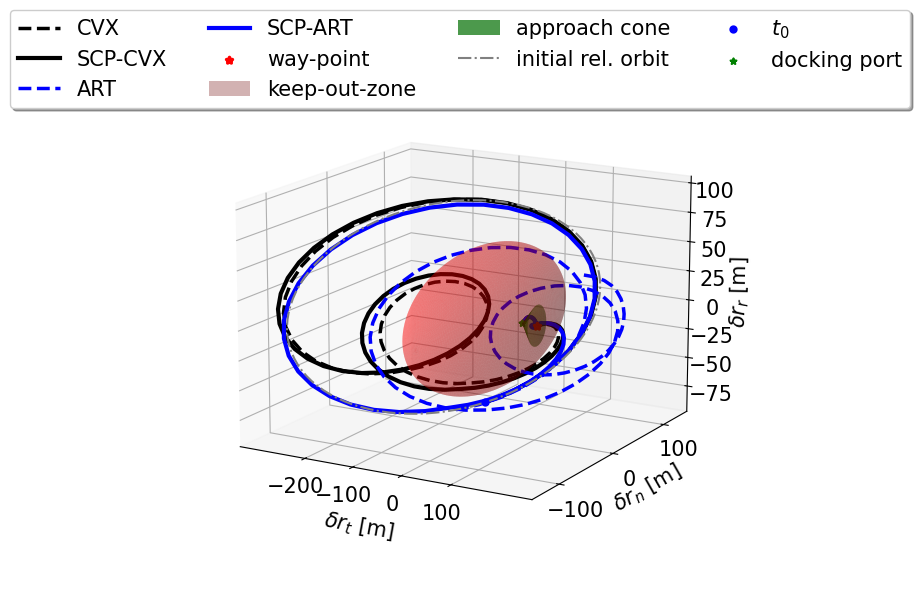

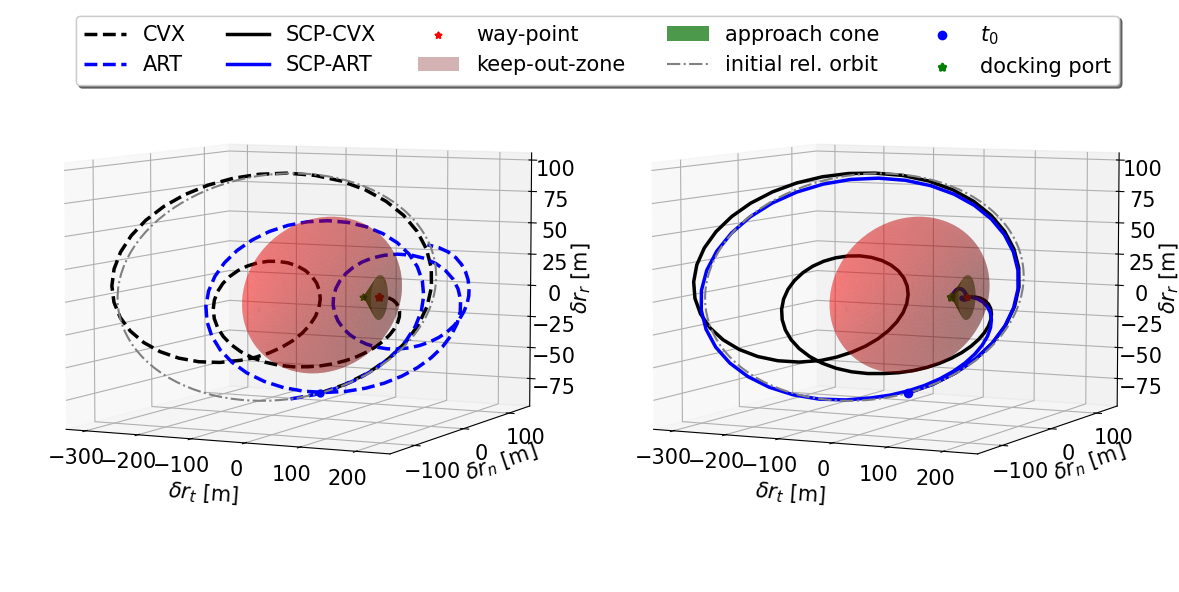

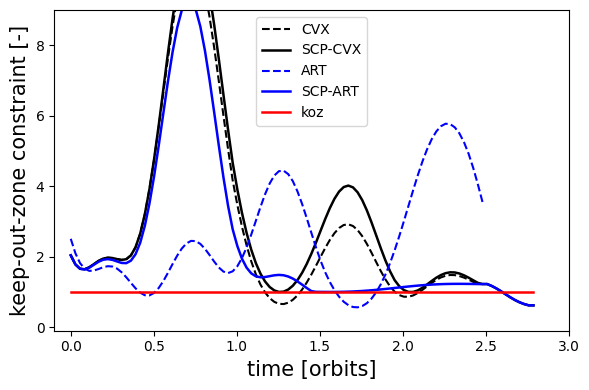

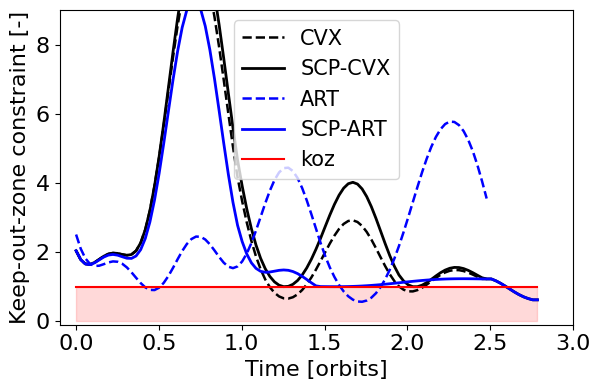

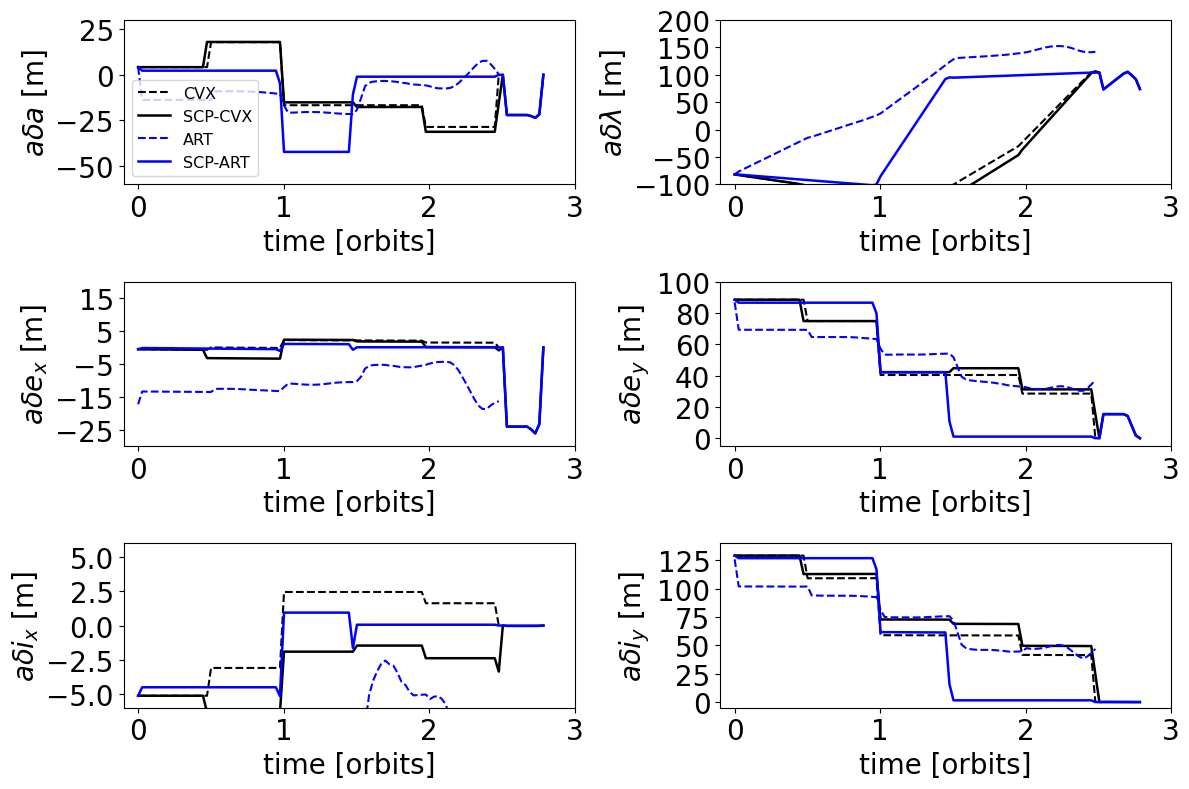

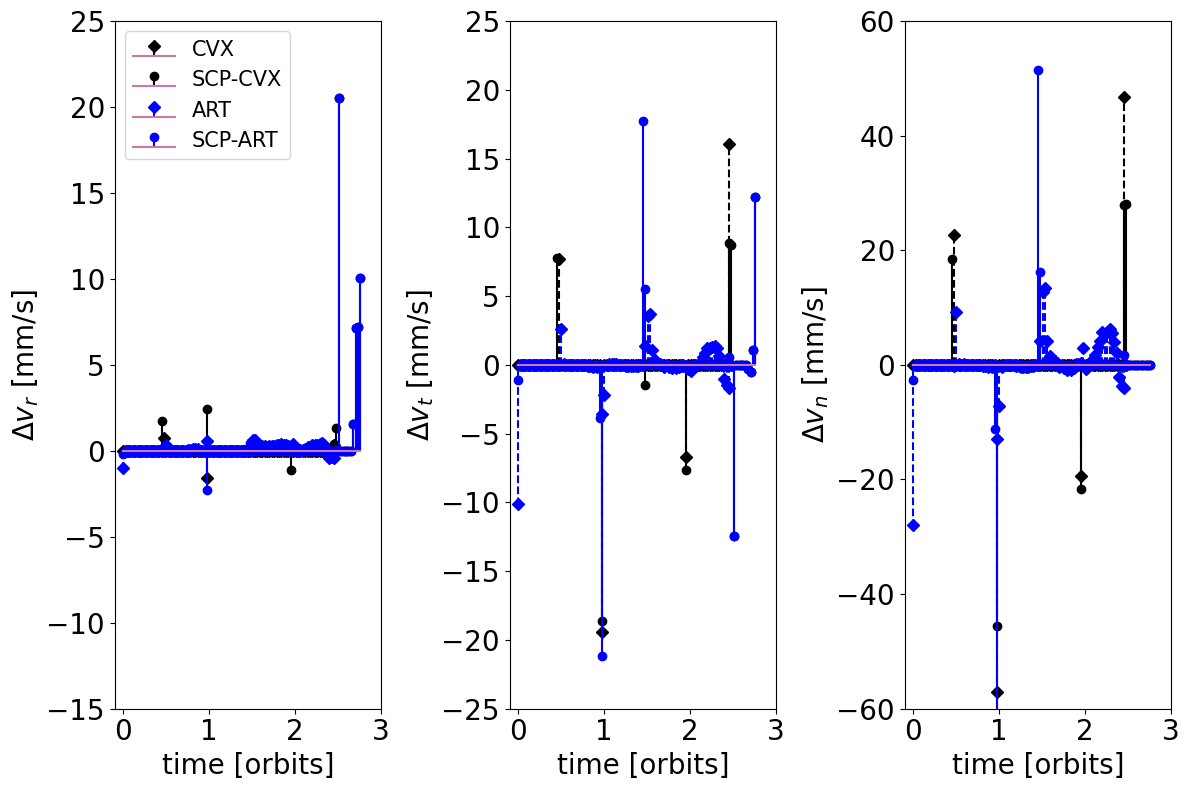

In [47]:
import os
import sys
import copy

root_folder = ""

#print(sys.path)

# Initializations
warmstart = 'both' # 'cvx'/'transformer'/'both'
scenario_test_dataset = True
state_representation = 'rtn' # 'roe'/'rtn'
dataset_to_use = 'both' # 'scp'/'cvx'/'both'
transformer_ws = 'dyn' # 'dyn'/'ol'
transformer_model_name = 'checkpoint_rtn_art_train'
select_idx = True # set to True to manually select a test trajectory via its index (idx)
idx = 18111 # index of the test trajectory (e.g., idx = 18111)
exclude_scp_cvx = False
exclude_scp_DT = False

# Scenario sampling
if not scenario_test_dataset:
    # Transfer horizon (orbits)
    hrz = 2
    # Initial relative orbit
    da = 0 # [m]
    dlambda = 75 # [m]
    de = 1/E_koz.item((0,0))+10
    di = 1/E_koz.item((2,2))+10
    ph_de = np.pi/2 + 0*np.pi/180; # [m]
    ph_di = np.pi/2 + 0*np.pi/180; # [m]
    state_roe_0 = np.array([da, dlambda, de*np.cos(ph_de), de*np.sin(ph_de), di*np.cos(ph_di), di*np.sin(ph_di)]).reshape((6,))
    relativeorbit_0 = roe_to_relativeorbit(state_roe_0, oe_0_ref)
else:
    # Get the datasets and loaders from the torch data
    datasets, dataloaders = DT_manager.get_train_val_test_data(state_representation, dataset_to_use, "checkpoint_rtn_art")
    train_loader, eval_loader, test_loader = dataloaders

    # Sample from test dataset
    if select_idx:
        test_sample = test_loader.dataset.getix(idx)
    else:
        test_sample = next(iter(test_loader))
    states_i, actions_i, rtgs_i, ctgs_i, timesteps_i, attention_mask_i, oe, dt, time_sec, horizons, ix = test_sample

    print('Sampled trajectory ' + str(ix) + ' from test_dataset.')
    data_stats = test_loader.dataset.data_stats

    hrz = horizons.item()
    if state_representation == 'roe':
        state_roe_0 = np.array((states_i[0, 0, :] * data_stats['states_std'][0]) + data_stats['states_mean'][0])
    elif state_representation == 'rtn':
        state_rtn_0 = np.array((states_i[0, 0, :] * data_stats['states_std'][0]) + data_stats['states_mean'][0])
        state_roe_0 = map_rtn_to_roe(state_rtn_0, np.array(oe[0, :, 0]))
    # relativeorbit_0 = roe_to_relativeorbit(state_roe_0, oe_0_ref)

# Dynamics Matrices Precomputations
stm_hrz, cim_hrz, psi_hrz, oe_hrz, time_hrz, dt_hrz = dynamics_roe_optimization(oe_0_ref, t_0, hrz, n_time_rpod)

# Build the oe vector including the target instant
oe_hrz_trg = np.append(oe_hrz,np.array([oe_0_ref.item(0), oe_0_ref.item(1), oe_0_ref.item(2), oe_0_ref.item(3), oe_0_ref.item(4), oe_0_ref.item(5) + n_ref*(time_hrz[-1]+dt_hrz-t_0)]).reshape((6,1)),1)
time_hrz_trg = np.append(time_hrz, time_hrz[-1]+dt_hrz)

# Warmstarting and optimization
if warmstart == 'cvx' or warmstart == 'both':
    # Solve Convex Problem
    runtime_cvx0 = time.time()
    states_roe_cvx, actions_cvx, feas_cvx = ocp_cvx(stm_hrz, cim_hrz, psi_hrz, state_roe_0, n_time_rpod)
    runtime_cvx = time.time() - runtime_cvx0
    print('CVX cost:', la.norm(actions_cvx, axis=0).sum())
    print('CVX runtime:', runtime_cvx)
    states_roe_cvx_trg = np.append(states_roe_cvx, (states_roe_cvx[:,-1]+cim_hrz[:,:,-1].dot(actions_cvx[:,-1])).reshape((6,1)), 1)
    states_roe_ws_cvx = states_roe_cvx # set warm start
    states_rtn_ws_cvx = roe_to_rtn_horizon(states_roe_cvx_trg, oe_hrz_trg, n_time_rpod+1)
    # Evaluate Constraint Violation
    constr_cvx, constr_viol_cvx = check_koz_constraint(states_rtn_ws_cvx, n_time_rpod+1)
    # Solve SCP
    states_roe_scp_cvx, actions_scp_cvx, feas_scp_cvx, iter_scp_cvx , J_vect_scp_cvx, runtime_scp_cvx = solve_scp(stm_hrz, cim_hrz, psi_hrz, state_roe_0, states_roe_ws_cvx, n_time_rpod)
    if states_roe_scp_cvx is None:
        exclude_scp_cvx = True
        print('No scp-cvx solution!')
    else:
        print('SCP cost:', la.norm(actions_scp_cvx, axis=0).sum())
        print('J vect', J_vect_scp_cvx)
        print('SCP runtime:', runtime_scp_cvx)
        print('CVX+SCP runtime:', runtime_cvx+runtime_scp_cvx)
        states_roe_scp_cvx_trg = np.append(states_roe_scp_cvx, (states_roe_scp_cvx[:,-1]+cim_hrz[:,:,-1].dot(actions_scp_cvx[:,-1])).reshape((6,1)), 1)
        states_rtn_scp_cvx = roe_to_rtn_horizon(states_roe_scp_cvx_trg, oe_hrz_trg, n_time_rpod+1)
        constr_scp_cvx, constr_viol_scp_cvx = check_koz_constraint(states_rtn_scp_cvx, n_time_rpod+1)

if warmstart == 'transformer' or warmstart == 'both':

    # Import the Transformer
    model = DT_manager.get_DT_model(transformer_model_name, train_loader, eval_loader) # can add optionals here
    inference_func = DT_manager.torch_model_inference_dyn
    print('Using ART model \'', transformer_model_name, '\' with inference function DT_manage.'+'dyn idek'+'()')
    rtg = la.norm(actions_cvx, axis=0).sum()
    DT_trajectory, runtime_DT = inference_func(model, test_loader, test_sample, stm_hrz, cim_hrz, psi_hrz, state_representation, rtg_perc=1., ctg_perc=0., rtg=rtg)
    states_roe_ws_DT = DT_trajectory['roe_' + transformer_ws]# set warm start
    # states_rtn_ws_DT = DT_trajectory['rtn_' + transformer_ws]
    actions_rtn_ws_DT = DT_trajectory['dv_' + transformer_ws]
    states_roe_DT_trg = np.append(states_roe_ws_DT, (states_roe_ws_DT[:,-1]+cim_hrz[:,:,-1].dot(actions_rtn_ws_DT[:,-1])).reshape((6,1)), 1)
    states_rtn_ws_DT = roe_to_rtn_horizon(states_roe_DT_trg, oe_hrz_trg, n_time_rpod+1)

    # void nans
    nan_mask = np.isnan(actions_rtn_ws_DT)
    actions_rtn_ws_DT[nan_mask] = 0.0
    art_cost = la.norm(actions_rtn_ws_DT, axis=0).sum()
    print('ART cost:', art_cost)
    print('ART runtime:', runtime_DT)
    constr_DT, constr_viol_DT = check_koz_constraint(states_rtn_ws_DT, n_time_rpod+1)

    # Solve SCP
    states_roe_scp_DT, actions_scp_DT, feas_scp_DT, iter_scp_DT, J_vect_scp_DT, runtime_scp_DT = solve_scp(stm_hrz, cim_hrz, psi_hrz, state_roe_0, states_roe_ws_DT, n_time_rpod)
    if states_roe_scp_DT is None:
        exclude_scp_DT = True
        print('No scp-DT solution!')
    else:
        scp_cost = la.norm(actions_scp_DT, axis=0).sum()
        print('SCP cost:', scp_cost)
        print('J vect', J_vect_scp_DT)
        states_roe_scp_DT_trg = np.append(states_roe_scp_DT, (states_roe_scp_DT[:,-1]+cim_hrz[:,:,-1].dot(actions_scp_DT[:,-1])).reshape((6,1)), 1)
        states_rtn_scp_DT = roe_to_rtn_horizon(states_roe_scp_DT_trg, oe_hrz_trg, n_time_rpod+1)
        constr_scp_DT, constr_viol_scp_DT = check_koz_constraint(states_rtn_scp_DT, n_time_rpod+1)

# Plotting
plt.style.use('seaborn-v0_8-colorblind')
relativeorbit_0 = roe_to_relativeorbit(state_roe_0, oe_0_ref)
t_ws_show = dock_wyp_sample

# 3D position trajectory'
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(projection='3d')
ax1.view_init(elev=15, azim=-60, roll=0)
if warmstart == 'cvx' or warmstart == 'both':
    p1 = ax1.plot3D(states_rtn_ws_cvx[1,:t_ws_show], states_rtn_ws_cvx[2,:t_ws_show], states_rtn_ws_cvx[0,:t_ws_show], 'k--', linewidth=2.5, label='CVX')
    if not exclude_scp_cvx:
        p2 = ax1.plot3D(states_rtn_scp_cvx[1,:], states_rtn_scp_cvx[2,:], states_rtn_scp_cvx[0,:], 'k-', linewidth=3, label='SCP-CVX') # 'scp (cvx)_(' + str(iter_scp_cvx) + ')'
if warmstart == 'transformer' or warmstart == 'both':
    p3 = ax1.plot3D(states_rtn_ws_DT[1,:t_ws_show], states_rtn_ws_DT[2,:t_ws_show], states_rtn_ws_DT[0,:t_ws_show], 'b--', linewidth=2.5, label='ART') # 'warm-start ART-' + transformer_ws
    if not exclude_scp_DT:
        p4 = ax1.plot3D(states_rtn_scp_DT[1,:], states_rtn_scp_DT[2,:], states_rtn_scp_DT[0,:], 'b-', linewidth=3, label='SCP-ART') #scp (ART-' + transformer_ws + ')_(' + str(iter_scp_DT) + ')
pwyp = ax1.scatter(dock_wyp[1], dock_wyp[2], dock_wyp[0], color = 'r', marker = '*', linewidth=2.5, label='way-point')
pell = ax1.plot_surface(y_ell, z_ell, x_ell, rstride=1, cstride=1, color='r', linewidth=0, alpha=0.3, label='keep-out-zone')
pell._facecolors2d = pell._facecolor3d
pell._edgecolors2d = pell._edgecolor3d
pcone = ax1.plot_surface(t_cone, n_cone, r_cone, rstride=1, cstride=1, color='g', linewidth=0, alpha=0.7, label='approach cone')
pcone._facecolors2d = pcone._facecolor3d
pcone._edgecolors2d = pcone._edgecolor3d
p3 = ax1.plot3D(relativeorbit_0[1,:], relativeorbit_0[2,:], relativeorbit_0[0,:], '-.', color='gray', linewidth=1.5, label='initial rel. orbit')
#if not exclude_scp_cvx:
p4 = ax1.scatter(states_rtn_scp_cvx[1,0], states_rtn_scp_cvx[2,0], states_rtn_scp_cvx[0,0], color = 'b', marker = 'o', linewidth=1.5, label='$t_0$')
p5 = ax1.scatter(states_rtn_scp_cvx[1,-1], states_rtn_scp_cvx[2,-1], states_rtn_scp_cvx[0,-1], color = 'g', marker = '*', linewidth=1.5, label='docking port')
ax1.set_xlabel('\n$\delta r_t$ [m]', fontsize=15, linespacing=1.5)
ax1.set_ylabel('$\delta r_n$ [m]', fontsize=15)
ax1.set_zlabel('$\delta r_r$ [m]', fontsize=15)
ax1.tick_params(axis='y', labelcolor='k', labelsize=15)
ax1.tick_params(axis='x', labelsize=15)
ax1.tick_params(axis='z', labelsize=15)
ax1.set_xticks(np.linspace(-200, 100, 4))
ax1.set_yticks(np.linspace(-100, 100, 3))
# ax.grid(True)
#ax1.legend(loc='upper left')
ax1.set_box_aspect(aspect=None, zoom=0.9)
plt.tight_layout()
# plt.subplots_adjust(wspace=0.05)
handles1, labels1 = ax1.get_legend_handles_labels()
first_legend = plt.legend(handles1, labels1, loc='lower center', bbox_to_anchor=(0.5, 0.85),
          ncol=4, fancybox=True, shadow=True, fontsize=15)
plt.savefig(root_folder + 'optimization/saved_files/plots/pos_3d.png', dpi = 600, bbox_inches='tight')


# 3D position trajectory'
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.view_init(elev=6, azim=-64, roll=0)
if warmstart == 'cvx' or warmstart == 'both':
    p1 = ax1.plot3D(states_rtn_ws_cvx[1,:t_ws_show], states_rtn_ws_cvx[2,:t_ws_show], states_rtn_ws_cvx[0,:t_ws_show], 'k--', linewidth=2.5, label='CVX')
    if not exclude_scp_cvx:
        p2 = ax1.plot3D(states_rtn_scp_cvx[1,:], states_rtn_scp_cvx[2,:], states_rtn_scp_cvx[0,:], 'k-', linewidth=0) # 'scp (cvx)_(' + str(iter_scp_cvx) + ')'
if warmstart == 'transformer' or warmstart == 'both':
    p3 = ax1.plot3D(states_rtn_ws_DT[1,:t_ws_show], states_rtn_ws_DT[2,:t_ws_show], states_rtn_ws_DT[0,:t_ws_show], 'b--', linewidth=2.5, label='ART') # 'warm-start ART-' + transformer_ws
    if not exclude_scp_DT:
        p4 = ax1.plot3D(states_rtn_scp_DT[1,:], states_rtn_scp_DT[2,:], states_rtn_scp_DT[0,:], 'b-', linewidth=0) #scp (ART-' + transformer_ws + ')_(' + str(iter_scp_DT) + ')
pwyp = ax1.scatter(dock_wyp[1], dock_wyp[2], dock_wyp[0], color = 'r', marker = '*', linewidth=2.5)
pell = ax1.plot_surface(y_ell, z_ell, x_ell, rstride=1, cstride=1, color='r', linewidth=0, alpha=0.3)
pell._facecolors2d = pell._facecolor3d
pell._edgecolors2d = pell._edgecolor3d
pcone = ax1.plot_surface(t_cone, n_cone, r_cone, rstride=1, cstride=1, color='g', linewidth=0, alpha=0.7)
pcone._facecolors2d = pcone._facecolor3d
pcone._edgecolors2d = pcone._edgecolor3d
p3 = ax1.plot3D(relativeorbit_0[1,:], relativeorbit_0[2,:], relativeorbit_0[0,:], '-.', color='gray', linewidth=1.5)
#if not exclude_scp_cvx:
p4 = ax1.scatter(states_rtn_scp_cvx[1,0], states_rtn_scp_cvx[2,0], states_rtn_scp_cvx[0,0], color = 'b', marker = 'o', linewidth=1.5)
p5 = ax1.scatter(states_rtn_scp_cvx[1,-1], states_rtn_scp_cvx[2,-1], states_rtn_scp_cvx[0,-1], color = 'g', marker = '*', linewidth=1.5)
ax1.set_xlabel('\n$\delta r_t$ [m]', fontsize=15, linespacing=1.5)
ax1.set_ylabel('$\delta r_n$ [m]', fontsize=15)
ax1.set_zlabel('$\delta r_r$ [m]', fontsize=15)
ax1.tick_params(axis='y', labelcolor='k', labelsize=15)
ax1.tick_params(axis='x', labelsize=15)
ax1.tick_params(axis='z', labelsize=15)
ax1.set_yticks(np.linspace(-100, 100, 3))
# ax1.set_xlim([-200,200])
# ax1.set_ylim([-300,300])
# ax1.set_zlim([-100,100])
ax1.set_box_aspect(aspect=None, zoom=0.945)
# ax.grid(True)
#ax1.legend(loc='upper left')

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.view_init(elev=6, azim=-64, roll=0)
if warmstart == 'cvx' or warmstart == 'both':
    p1 = ax2.plot3D(states_rtn_ws_cvx[1,:t_ws_show], states_rtn_ws_cvx[2,:t_ws_show], states_rtn_ws_cvx[0,:t_ws_show], 'k-', linewidth=0)
    if not exclude_scp_cvx:
        p2 = ax2.plot3D(states_rtn_scp_cvx[1,:], states_rtn_scp_cvx[2,:], states_rtn_scp_cvx[0,:], 'k-', linewidth=2.5, label='SCP-CVX') # 'scp (cvx)_(' + str(iter_scp_cvx) + ')'
if warmstart == 'transformer' or warmstart == 'both':
    p3 = ax2.plot3D(states_rtn_ws_DT[1,:t_ws_show], states_rtn_ws_DT[2,:t_ws_show], states_rtn_ws_DT[0,:t_ws_show], 'b-', linewidth=0) # 'warm-start ART-' + transformer_ws
    if not exclude_scp_DT:
        p4 = ax2.plot3D(states_rtn_scp_DT[1,:], states_rtn_scp_DT[2,:], states_rtn_scp_DT[0,:], 'b-', linewidth=2.5, label='SCP-ART') #scp (ART-' + transformer_ws + ')_(' + str(iter_scp_DT) + ')
pwyp = ax2.scatter(dock_wyp[1], dock_wyp[2], dock_wyp[0], color = 'r', marker = '*', linewidth=1.5, label='way-point')
pell = ax2.plot_surface(y_ell, z_ell, x_ell, rstride=1, cstride=1, color='r', linewidth=0, alpha=0.3, label='keep-out-zone')
pell._facecolors2d = pell._facecolor3d
pell._edgecolors2d = pell._edgecolor3d
pcone = ax2.plot_surface(t_cone, n_cone, r_cone, rstride=1, cstride=1, color='g', linewidth=0, alpha=0.7, label='approach cone')
pcone._facecolors2d = pcone._facecolor3d
pcone._edgecolors2d = pcone._edgecolor3d
p3 = ax2.plot3D(relativeorbit_0[1,:], relativeorbit_0[2,:], relativeorbit_0[0,:], '-.', color='gray', linewidth=1.5, label='initial rel. orbit')
p4 = ax2.scatter(states_rtn_scp_cvx[1,0], states_rtn_scp_cvx[2,0], states_rtn_scp_cvx[0,0], color = 'b', marker = 'o', linewidth=2.5, label='$t_0$')
p5 = ax2.scatter(states_rtn_scp_cvx[1,-1], states_rtn_scp_cvx[2,-1], states_rtn_scp_cvx[0,-1], color = 'g', marker = '*', linewidth=2.5, label='docking port')
ax2.set_xlabel('\n$\delta r_t$ [m]', fontsize=15, linespacing=1.5)
ax2.set_ylabel('$\delta r_n$ [m]', fontsize=15)
ax2.set_zlabel('$\delta r_r$ [m]', fontsize=15)
ax2.tick_params(axis='y', labelcolor='k', labelsize=15)
ax2.tick_params(axis='x', labelsize=15)
ax2.tick_params(axis='z', labelsize=15)
ax2.set_yticks(np.linspace(-100, 100, 3))
# ax2.set_xlim([-200,200])
# ax2.set_ylim([-300,300])
# ax2.set_zlim([-100,100])
ax2.set_box_aspect(aspect=None, zoom=0.945)
plt.tight_layout(pad=1.0, w_pad=0.2)
# plt.subplots_adjust(wspace=-0.01)
handles, labels = [(a + b) for a, b in zip(ax1.get_legend_handles_labels(), ax2.get_legend_handles_labels())]
first_legend = plt.legend(handles, labels, loc='lower center', bbox_to_anchor=(-0., 0.85),
          ncol=5, fancybox=True, shadow=True, fontsize=15)
ax2.add_artist(first_legend)
#ax1.legend(loc='lower center', bbox_to_anchor=(0.8, 0.9),
#          ncol=4, fancybox=True, shadow=True, fontsize=8, zorder=1)
plt.savefig(root_folder + 'optimization/saved_files/plots/pos_3d_split.png', dpi = 600, bbox_inches='tight')

# Constraint satisfaction
plt.figure(figsize=(6,4))
if warmstart == 'cvx' or warmstart == 'both':
    plt.plot(time_hrz_trg[:t_ws_show]/period_ref, constr_cvx[:t_ws_show], 'k--', linewidth=1.5, label='CVX')
    if not exclude_scp_cvx:
        plt.plot(time_hrz_trg/period_ref, constr_scp_cvx, 'k-', linewidth=1.8, label='SCP-CVX')

if warmstart == 'transformer' or warmstart == 'both':
    plt.plot(time_hrz_trg[:t_ws_show]/period_ref, constr_DT[:t_ws_show], 'b--', linewidth=1.5, label='ART')
    if not exclude_scp_DT:
        plt.plot(time_hrz_trg/period_ref, constr_scp_DT, 'b-', linewidth=1.8, label='SCP-ART')

plt.plot(time_hrz_trg/period_ref, np.ones(n_time_rpod+1), 'r-', linewidth=1.8, label='koz')
plt.xlabel('time [orbits]', fontsize=15)
plt.ylabel('keep-out-zone constraint [-]', fontsize=15)
# plt.grid(True)
plt.xlim([-0.1,3])
plt.ylim([-0.1,9])
plt.legend(loc='best')
plt.tight_layout()
plt.savefig(root_folder + 'optimization/saved_files/plots/koz_constr.png', dpi = 600)

fig, ax = plt.subplots(figsize=(6,4))
if warmstart == 'cvx' or warmstart == 'both':
    ax.plot(time_hrz_trg[:t_ws_show]/period_ref, constr_cvx[:t_ws_show], 'k--', linewidth=1.8, label='CVX')
    if not exclude_scp_cvx:
        ax.plot(time_hrz_trg/period_ref, constr_scp_cvx, 'k-', linewidth=2, label='SCP-CVX')

if warmstart == 'transformer' or warmstart == 'both':
    ax.plot(time_hrz_trg[:t_ws_show]/period_ref, constr_DT[:t_ws_show], 'b--', linewidth=1.8, label='ART')
    if not exclude_scp_DT:
        ax.plot(time_hrz_trg/period_ref, constr_scp_DT, 'b-', linewidth=2, label='SCP-ART')

ax.plot(time_hrz_trg/period_ref, np.ones(n_time_rpod+1), 'r-', linewidth=1.5, label='koz')
ax.fill_between([0, (time_hrz_trg/period_ref)[-1]], [0, 0], [1, 1], alpha=0.15, color='red')
ax.set_xlabel('Time [orbits]', fontsize=16, linespacing=1.5)
ax.set_ylabel('Keep-out-zone constraint [-]', fontsize=16)
ax.tick_params(axis='y', labelcolor='k', labelsize=16)
ax.tick_params(axis='x', labelsize=16)
# plt.grid(True)
ax.set_xlim([-0.1,3])
ax.set_ylim([-0.1,9])
plt.legend(loc='best', fontsize=15)
plt.tight_layout()
plt.savefig(root_folder + 'optimization/saved_files/plots/koz_constr_v2.png', dpi = 600, bbox_inches='tight')

# ROE plots

# # ROE space
# plt.figure()
# if warmstart == 'cvx' or warmstart == 'both':
#     p1 = plt.plot(states_roe_cvx_trg[1,:t_ws_show], states_roe_cvx_trg[0,:t_ws_show], 'k--', linewidth=1.2, label='CVX')
#     if not exclude_scp_cvx:
#         p2 = plt.plot(states_roe_scp_cvx_trg[1, :], states_roe_scp_cvx_trg[0,:], 'k-', linewidth=1.5, label='SCP-CVX')
# if warmstart == 'transformer' or warmstart == 'both':
#     p3 = plt.plot(states_roe_DT_trg[1,:t_ws_show], states_roe_DT_trg[0,:t_ws_show], 'b--', linewidth=1.2, label='ART')
#     if not exclude_scp_DT:
#         p4 = plt.plot(states_roe_scp_DT_trg[1, :], states_roe_scp_DT_trg[0,:], 'b-', linewidth=1.5, label='SCP-ART')
# plt.xlabel('$a \delta \lambda$ [m]')
# plt.ylabel('$a \delta a$ [m]')
# # plt.grid(True)
# plt.legend(loc='best')
# plt.savefig(root_folder + '/optimization/saved_files/plots/roe12.png')

# plt.figure()
# if warmstart == 'cvx' or warmstart == 'both':
#     p1 = plt.plot(states_roe_cvx_trg[2,:t_ws_show], states_roe_cvx_trg[3,:t_ws_show], 'k--', linewidth=1.2, label='CVX')
#     if not exclude_scp_cvx:
#         p2 = plt.plot(states_roe_scp_cvx_trg[2, :], states_roe_scp_cvx_trg[3,:], 'k-', linewidth=1.5, label='SCP-CVX')
# if warmstart == 'transformer' or warmstart == 'both':
#     p3 = plt.plot(states_roe_DT_trg[2,:t_ws_show], states_roe_DT_trg[3,:t_ws_show], 'b--', linewidth=1.2, label='ART')
#     if not exclude_scp_DT:
#         p4 = plt.plot(states_roe_scp_DT_trg[2, :], states_roe_scp_DT_trg[3,:], 'b-', linewidth=1.5, label='SCP-ART')
# plt.xlabel('$a \delta e_x$ [m]')
# plt.ylabel('$a \delta e_y$ [m]')
# # plt.grid(True)
# plt.legend(loc='best')
# plt.savefig(root_folder + '/optimization/saved_files/plots/roe34.png')

# plt.figure()
# if warmstart == 'cvx' or warmstart == 'both':
#     p1 = plt.plot(states_roe_cvx_trg[4,:t_ws_show], states_roe_cvx_trg[5,:t_ws_show], 'k--', linewidth=1.2, label='CVX')
#     if not exclude_scp_cvx:
#         p2 = plt.plot(states_roe_scp_cvx_trg[4, :], states_roe_scp_cvx_trg[5,:], 'k-', linewidth=1.5, label='SCP-CVX')
# if warmstart == 'transformer' or warmstart == 'both':
#     p3 = plt.plot(states_roe_DT_trg[4,:t_ws_show], states_roe_DT_trg[5,:t_ws_show], 'b--', linewidth=1.2, label='ART')
#     if not exclude_scp_DT:
#         p4 = plt.plot(states_roe_scp_DT_trg[4, :], states_roe_scp_DT_trg[5,:], 'b-', linewidth=1.5, label='SCP-ART')
# plt.xlabel('$a \delta i_x$ [m]')
# plt.ylabel('$a \delta i_y$ [m]')
# # plt.grid(True)
# plt.legend(loc='best')
# plt.savefig(root_folder + '/optimization/saved_files/plots/roe56.png')

# ROE vs time
plot_orb_time = True
plt.figure(figsize=(12,8)) #figsize=(20,5)
for j in range(6):
    plt.subplot(3,2,j+1)
    if warmstart == 'cvx' or warmstart == 'both':
        plt.plot(time_hrz_trg[:t_ws_show]/period_ref, states_roe_cvx_trg[j,:t_ws_show], 'k--', linewidth=1.5, label='CVX')
        if not exclude_scp_cvx:
            plt.plot(time_hrz_trg/period_ref, states_roe_scp_cvx_trg[j,:], 'k-', linewidth=1.8, label='SCP-CVX')
    if warmstart == 'transformer' or warmstart == 'both':
        plt.plot(time_hrz_trg[:t_ws_show]/period_ref, states_roe_DT_trg[j,:t_ws_show], 'b--', linewidth=1.5, label='ART')
        if not exclude_scp_DT:
            plt.plot(time_hrz_trg/period_ref, states_roe_scp_DT_trg[j,:], 'b-', linewidth=1.8, label='SCP-ART')
    if j == 0:
        plt.xlabel('time [orbits]' if plot_orb_time else 'time [steps]', fontsize=20)
        plt.ylabel('$a \delta a$ [m]', fontsize=20)
        # plt.grid(True)
        plt.xlim([-0.1,3])
        plt.ylim([-60,30])
        plt.legend(loc='best', fontsize=11.5)
        plt.tick_params(axis='y', labelsize=20)
        plt.tick_params(axis='x', labelsize=20)
        plt.yticks(range(-50,50,25))
    elif j == 1:
        plt.xlabel('time [orbits]' if plot_orb_time else 'time [steps]', fontsize=20)
        plt.ylabel('$a \delta \lambda$ [m]', fontsize=20)
        # plt.grid(True)
        plt.xlim([-0.1,3])
        plt.ylim([-100,200])
        plt.tick_params(axis='y', labelsize=20)
        plt.tick_params(axis='x', labelsize=20)
        plt.yticks(range(-100,250,50))
        # plt.legend(loc='best')
    elif j == 2:
        plt.xlabel('time [orbits]' if plot_orb_time else 'time [steps]', fontsize=20)
        plt.ylabel('$a \delta e_x$ [m]', fontsize=20)
        # plt.grid(True)
        plt.xlim([-0.1,3])
        plt.ylim([-30,20])
        plt.tick_params(axis='y', labelsize=20)
        plt.tick_params(axis='x', labelsize=20)
        plt.yticks(range(-25,25,10))
        # plt.legend(loc='best')
    elif j == 3:
        plt.xlabel('time [orbits]' if plot_orb_time else 'time [steps]', fontsize=20)
        plt.ylabel('$a \delta e_y$ [m]', fontsize=20)
        # plt.grid(True)
        plt.xlim([-0.1,3])
        plt.ylim([-5,100])
        plt.tick_params(axis='y', labelsize=20)
        plt.tick_params(axis='x', labelsize=20)
        plt.yticks(range(0,120,20))
        # plt.legend(loc='best')
    elif j == 4:
        plt.xlabel('time [orbits]' if plot_orb_time else 'time [steps]', fontsize=20)
        plt.ylabel('$a \delta i_x$ [m]', fontsize=20)
        # plt.grid(True)
        plt.xlim([-0.1,3])
        plt.ylim([-6,6])
        plt.tick_params(axis='y', labelsize=20)
        plt.tick_params(axis='x', labelsize=20)
        plt.yticks(np.arange(-5,7.5,2.5))
        # plt.legend(loc='best')
    elif j == 5:
        plt.xlabel('time [orbits]' if plot_orb_time else 'time [steps]', fontsize=20)
        plt.ylabel('$a \delta i_y$ [m]', fontsize=20)
        # plt.grid(True)
        plt.xlim([-0.1,3])
        plt.ylim([-5,140])
        plt.tick_params(axis='y', labelsize=20)
        plt.tick_params(axis='x', labelsize=20)
        plt.yticks(range(0,150,25))
        # plt.legend(loc='best')
plt.tight_layout()
plt.savefig(root_folder + 'optimization/saved_files/plots/roe_vs_time.png', dpi = 600, bbox_inches='tight')

# Control
plt.figure(figsize=(12,8)) #figsize=(20,5)
for j in range(3):
    plt.subplot(1,3,j+1)
    plt.stem(time_hrz[:t_ws_show]/period_ref, actions_cvx[j,:t_ws_show]*1000., 'k--', markerfmt='D', label='CVX')
    plt.stem(time_hrz/period_ref, actions_scp_cvx[j,:]*1000., 'k-', label='SCP-CVX')
    plt.stem(time_hrz[:t_ws_show]/period_ref, actions_rtn_ws_DT[j,:t_ws_show]*1000., 'b--', markerfmt='D', label='ART')
    plt.stem(time_hrz/period_ref, actions_scp_DT[j,:]*1000., 'b-', label='SCP-ART')
    if j == 0:
        plt.xlabel('time [orbits]', fontsize=20)
        plt.ylabel('$ \Delta v_r$ [mm/s]', fontsize=20)
        # plt.grid(True)
        plt.xlim([-0.1,3])
        plt.ylim([-15,25])
        plt.legend(loc='best', fontsize=15)
        plt.tick_params(axis='y', labelsize=20)
        plt.tick_params(axis='x', labelsize=20)
        plt.xticks(range(0,4,1))
    elif j == 1:
        plt.xlabel('time [orbits]', fontsize=20)
        plt.ylabel('$ \Delta v_t$ [mm/s]', fontsize=20)
        # plt.grid(True)
        plt.xlim([-0.1,3])
        plt.ylim([-25,25])
        plt.tick_params(axis='y', labelsize=20)
        plt.tick_params(axis='x', labelsize=20)
        plt.yticks(range(-25,30,5))
        plt.xticks(range(0,4,1))
        # plt.legend(loc='best')
    elif j == 2:
        plt.xlabel('time [orbits]', fontsize=20)
        plt.ylabel('$ \Delta v_n$ [mm/s]', fontsize=20)
        # plt.grid(True)
        plt.xlim([-0.1,3])
        plt.ylim([-60,60])
        plt.tick_params(axis='y', labelsize=20)
        plt.tick_params(axis='x', labelsize=20)
        plt.xticks(range(0,4,1))
        # plt.legend(loc='best')
plt.tight_layout()
plt.savefig(root_folder + 'optimization/saved_files/plots/delta_v.png', dpi = 600, bbox_inches='tight')

# # Cost
# if not (exclude_scp_cvx or exclude_scp_DT):
#     plt.figure()
#     max_it = max(iter_scp_cvx, iter_scp_DT)
#     for i in range(max_it):
#         if i >= iter_scp_cvx:
#             J_vect_scp_cvx[i] = J_vect_scp_cvx[iter_scp_cvx-1]
#         elif i >= iter_scp_DT:
#             J_vect_scp_DT[i] = J_vect_scp_DT[iter_scp_DT-1]
#     if warmstart == 'cvx' or warmstart == 'both':
#         plt.plot(J_vect_scp_cvx[:max_it]*1000., 'b--', marker='o', linewidth=1.5, label='SCP-CVX')

#     if warmstart == 'transformer' or warmstart == 'both':
#         plt.plot(J_vect_scp_DT[:max_it]*1000., 'g--', marker='o', linewidth=1.5, label='SCP-ART')

#     plt.xlabel('Iterations [-]')
#     plt.ylabel('Cost [m/s]')
#     # plt.grid(True)
#     plt.legend(loc='best')
#     plt.savefig(root_folder + '/optimization/saved_files/plots/cost.png')

# io.savemat('plot_data.mat', dict(states_rtn_ws_cvx=states_rtn_ws_cvx, states_rtn_scp_cvx=states_rtn_scp_cvx, states_rtn_ws_DT=states_rtn_ws_DT, states_rtn_scp_DT=states_rtn_scp_DT, dock_wyp=dock_wyp, x_ell=x_ell, y_ell=y_ell, z_ell=z_ell, t_cone=t_cone, n_cone=n_cone, r_cone=r_cone))

plt.show()

In [48]:
# comparison to base costs:
base_ovrl = 0.20998219236290414
base_art = 0.2724136

print(f"radial/base art cost: {art_cost/base_art}")
print(f"radial/base art+scp overall cost: {scp_cost/base_ovrl}")

radial/base art cost: 0.6294563121353318
radial/base art+scp overall cost: 1.000885597522926


# Conclusions

- 0.09% ish loss of performance is not too bad! Not exactly what we were aiming for but things could be worse
- do we really train over all those params???? - that could be difference
- interestingly inference is much slower...not sure why this is? Maybe I messed something up

In [ ]:
#